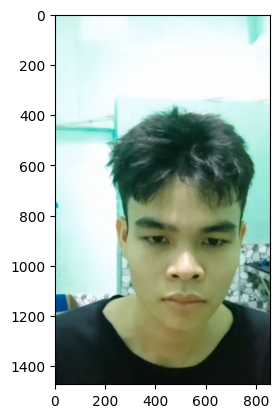

1/1 [==============================] - 4s 4s/step
/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/2wBDAQICAgICAgUDAwUKBwYHCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgr/wAARCAK8AfQDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9q/LjYYEYpotyG9fwqZVcHlcfU1NHAQdxavy2KOe1yKGzDHd5Yz27U9ogpx0I9BU+3B+/2pcEAjOc10KMUty+WxXMRIHOP6077OSA6t+nSnmJcZJNOQqqFQ

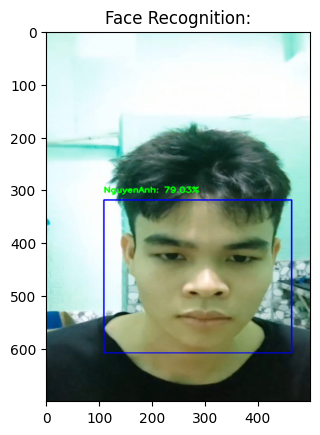

None


In [2]:
import base64
import cv2 as cv
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import pickle
from keras_facenet import FaceNet
import matplotlib.pyplot as plt

class FaceRecEncodedImg():
    def __init__(self, encoded_img):
        self.encoded_img = encoded_img
        self.facenet = FaceNet()
        self.current_path = os.getcwd().replace("\\", "/")

    def face_rec_encoded_img(self):
        faces_embeddings = np.load(self.current_path + "/faces_embeddings_done_4classes.npz")
        Y = faces_embeddings['arr_1']
        encoder = LabelEncoder()
        encoder.fit(Y)
        haarcascade = cv.CascadeClassifier(self.current_path + "/haarcascade_frontalface_default.xml")
        model = pickle.load(open(self.current_path + "/svm_model_160x160.pkl", 'rb'))
        # decoded image
        
        decoded_image = base64.b64decode(self.encoded_img)
        
        img_array = np.frombuffer(decoded_image, np.uint8)
        img = cv.imdecode(img_array, cv.IMREAD_COLOR)
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.show()

        rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

        gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        faces = haarcascade.detectMultiScale(gray_img, 1.3, 5)
        for x,y,w,h in faces:
            img_face = rgb_img[y:y+h, x:x+w]
            img_face = cv.resize(img_face, (160,160)) # 1x160x160x3
            img_face = np.expand_dims(img_face,axis=0)
            ypred = self.facenet.embeddings(img_face)
            face_prob = model.predict_proba(ypred)
            max_prob = np.max(face_prob)
            if max_prob < 0.75:
                final_name = "unknown"
                text = "{}: {:.2f}%".format(final_name, max_prob*100)
            else:
                face_name = model.predict(ypred)
                final_name = encoder.inverse_transform(face_name)[0]
                text = "{}: {:.2f}%".format(final_name, max_prob*100)
            
            cv.rectangle(rgb_img, (x,y), (x+w,y+h), (0,0,255), 3)
            cv.putText(rgb_img, text, (x,y-30), cv.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 3)
        if img is not None and len(img.shape) > 0 and img.shape[0] > 0 and img.shape[1] > 0: 
            # rgb_img = cv.cvtColor(rgb_img, cv.COLOR_BGR2RGB)
            img_resized = cv.resize(rgb_img, (500, 700)) # Resize image for display
            encoded_string = base64.b64encode(cv.imencode('.jpg', img_resized)[1]).decode('utf-8')
            print(encoded_string)
            plt.imshow(img_resized)
            plt.title("Face Recognition:")
            plt.show()
        else:
            print("Invalid image shape")

f = FaceRecEncodedImg("/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAXBA1sDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9DNgprqF6U+l2561qfC2ZDTwoxTtp9BTlX2oGNWH5s9ak2VIsZ45oaPb70GiTIqX+HPenH6UbaAtqMXmlp44Ip5Xd0FMEMj561ZiY59qij47VZXHpQjaJLGMtVuFRk1Uh+9VyP5TT1OumWVXjrShdvfNMWpl5rRaI7Ii0q0lKoqTcSin0AdOKAsMp8a5qTaPSjGKm7Gg2j0o2j0paKRYm0elG3FLRSIsFN2806igdhBmloooKCiiigApjA5p9H4UARHNMY8e9SnPPNRsvy1aIKs+WWqWfartxyKo+uTWiOCruOpNoo49KD0p2RzWG0U7IpaLImwylWnUoWiyBIbtFG0U/aKNoosirDNoo2in7RRtFFkFhm0UbRT9oo2iiyCwzaKNop+0UbRRZBYZtFKoGadtFGKLIdg2ijaKKKLIoNoo2iinbaNAG7RRtFO20bDS0Ksxu0UbRTttJg0aBZibRRtFLRT0FZibRRtFLRRoFmIRRtFFFGgrBtFG0UUtGghlJT9vtR+FLQbQ2inbRRtFOyJ1G0m0U44xTQu2iyEG0elNYU+iiyAhPSm1IV4pu32o0M9RtFO2+1G32osg1G0U7b7UbfaiyDUbSGn7fagjrRZCsVttGwU7ac9KNp9KgmzG7aCAKftPpTWGKZLiMz70jU4DJxQy807hylVuvSo2Jq1Iu5enNQsvtRoYyuZ8/3jxWTer8prelTIJxWNqC7VarR5WJj7rOduu9U2XrV6aMsxqvJHtrc+WqJ3K0rYXrzUcbbqkkXPamxrzUmKb7lmHtWna84OKzofvCtW3+70rOR3UVcuwD5q0rQYxWfbrzzWradqg92gtTVtei/rV5Qc8iqduOnrWgg55pM9+nsOCgUtLx1pdorQ3sc/T6btPrT0WuQ4EJUq9elIFAp6iqSKjuKv8AWl3e1JRSNrgfpTcUpzS/WhiuiM9alXpTN1OVuKOhNx27mpkfcvvVcmlhzvNJGsS7D/rBV1V29aqwAZBq7H81ao66Y8Z7VKlIq/LTwMUztiOVqWmU5eak1TVhactKox1FOHTrU3KE3Uc+lLRUlWEWloooGFFFFABRRRQAUUUUAFFFFBOoUUfWg+1BQhFNYfKafTX+7TuJlGdTgiqW2r83UVX8sVojz6mpCqnbkil2+1SZ28UFuKq6MuUh2mjac06imKw3n0p1FLtPpTBREopdp9KKQWYlFLtPpRtPpQFmJRS0bT6UBZiUUu0+lG0+lAWYlPWMsM5pu0+lSLkYFA9Rm2jaTVjaKNg96jmZfIQ+V7/pTx8vGKftpDGM9TSbuUopCZ9qOfSnbaNtMdhuNx6Yo8v3p+MUoFIdiHyaUQ81NtFG0etGocqIvLFN8nmp9o9aNo9aNR8hD5dJ5dT7R603FAuUiCc9aNpqRlpNp9aLi5UMximtUu0+tNaOnclxIKT8TVjYKRoQ3enzEcpA1JU3kimNGBVLUnlGUUu2jHtQTyiMpxTdtSHpSbTTFyjNpo2mpNoo20aCsR7TRtNSYFJxRoFhm00mD6VLtFG2jQLEXl+9J5ZqbaKNoosBD5ftTGWrO0Uzb3okTa5W8o9jTJFOatMmKjdAanQHEpt3prL8vWppI+aZjFGpzyRUlX5ax79Synmt6ZeKxr5f3bVS3POrR0Zzky4aqkwq7P1P1qlLWp8xUjqVX6dKro58z2qaY8GqkZ/ffjVHmvc04uGFatuDtxWXD1Fatr2rOR6NEvw1q2YrMt+ta1mvI+lZs93D7mrbjkVejXpVS36ir4GKSPoqUfdE9u1LRRTOhRsY2PajbtqXbRtFc5w8qIxmnqKdRVREl2GbDSj3qTafSjafSmVYbtptSbT6UGM0BYi4pv8AKptp/uijafSoDlGLHu5qeOPH1piqRjjipo6aWppFFqFRgcVajqvCOBVqJTWp100Tr90UtJ060tB3RHbR609Fx05qMdaljFQy12HUUUVBoFFFFABRRRQAUv1o70NQAlFFFABRRil20AJRRx6Uu6gBKKKKACmv92nUjUCKU/WoW61PcfrUDCtEcc1ZgFz9aPL4OaGNG72pGd0N8v2pNoqTIo607hYi2+1S0UUXFYKXaaSigdhdpo2mkooCwu2jaaSigLC7TRtNJRQFhdppMCilWgaHUU8UU7FDKKfSbRRYY2in4FHHrUjsM607tSgelPC0BYZSGpNgpfLFVcLEdFP207aMUrlohNJt9an2j1prRjHBoGyLaKdSjIzxQQatWM7DaRl4p200c0aEke2jYakpBSKsyPafSm7RUrU1s+lNEMibHpRT/qKOtMzsRlabtqSgc9KRNiHy6d5X+c1JtNG00XDlIzF6U3yzU1G00XDlI1jNHlf5zUmDRtNFw5SPYaNhqTaaNppDsR7DTW6VNtNMYH0oJkrEWymSR+lT7T6U0+/WrIZUZRzUbR5XNW2Qdqh2H0pGEkUZVPSsu8Tcj/pW7NHuU1lXEf3vSmcFaLsctcxjJzxVGVBWvfLtYnNZUlaXPmqsbMzrheDVSNf3vNaFxkrVONf3v41SPGn8Rowr92tO36Cs+H7wrQt6Uj0aJoW/3vxrXs+1ZFv978a2LLkrWL2ue7h90a9ryRWiq8is+zHzCtONTuFQfS0VoO8rdR5JqbbRz6VR08rOczSr1pKVayseXcdT05A6UypIyKZcR+D60tFFBdgNJ2paQUCsIy01mNP7Ux6kbQuCwqVU6c1GnSp17VUSoliI9Ksx8VWTrVmPqKp7nZDoT8nvRRRQdY4ct6VKny01YwuDT6zuXEKMUUL7UixdvvSU+koGNxRR92igQUUUUAFFFFABS80lFABRRRQAUUUUAFFFFAitKMjOKh2ip5Pu1AtbR2OSbYnlijyx6U+ipZNiPy6Nm2ptoqNqdhWG7aNtLTvahIYxVpdlOpdposKxEylaXbSt70nPalYLMNtG2lopahYTbRto5padgsJtoXIPrRzSrnNFgsx9FFFUXZhTlUFevNM59KnjX5aBpDPLHqaPLWpdvtRt9qgrlIhGB3pfanMMUmO9AconNLRRVaByhS8UlFKxVheKSiimOwbd1Hl+9OWlqR2I9tG2lpV5q7k2Q3bRtFP2ijilcdiPYKR0GKkYU1qaYnEj8te9IYgKfSY96ozsyNkAzmm7R9Kmbn603y6hu4pRGbaNtP8AKNL5dTZisRbaXbUnl0eUaaXcLEe2jbUvlUnlGiwrMj20bak8o0eXSFZke2mbe9T+X/nNMaMjmmgkiJjuHSo24qZk4pvl561ehk4kW3d7U3bt71MVwtRN3pkSiQTLuWsm7jxmtojIOaoXyDaeOaDlqx91nIalHtzWNKvzGt/VRzisSZetM+UxC94qSr8tUox++q9N9zNUV/1w9K1ieJU0kaUXUVfhOKow84q9D6UpbnZRWlzStRn862LMbStZFoK2LUcr9KyfY93DbmxapjBrTj6is63+6K0Y+SKzufU0FdFqiiimd1jmeKcBT9tG2pPEsN2ilxS7DTgvFAWHUUUUGkQooowaCgoUe1A60rUAHFTp2qvU8famhrctJ16VOnaq6NU0Z6UHZDoWlxT1UGoV47VMtI6x1FFGKgsKKKKBhmjNFLtNAhKKXaaNpoGIPelOO1GKA2KAEopetJQAUUUdKACijFHbNAgooooGFIelLRQJlZulMx7U91PHFM+7W0TmkhdoptOptNhYdTW606kztPSmS0AxR3pN3tS/eoBIAKWkxS0BYbtpVo55o6UtDSwvFFJ+FLTCw2nUbRRS0FYKFUbqKcBSKsLRRRSGJ+dKCR34opyrkdKBobmjNP2mjaaVx8oi/MeacVBo59KOfWkVyojHWpGxTcfNTmX0FArCKooO30pUBx0pjA5oE1oOpKcDS7aChFApdoo2ntS7TQMj20oXcaXafSlVTnpQTyi7aNlOoqbjsMZB60hT6U/aKTb81MLXGiMUvl+1O2ijbRcfKQ7eaNvoal8v3pPLxTuZuDGcUm0+oqTZRt9qLiUSPb70u0etPKk9qTafSgOVjdvvRt96dtPpSbTRcORibfekZfen7T6U1lNArDcfSmsODTqSquDRE6jFR7BVjy8jtTSpoeplysiC8Go/Lqfb680u32qoicSq8IqjfQnyya1X+lUrxfkYe1F9TnqQujiNWXbmsOauj1hfvcVzk1Wlc+Jxek2ijN92qY/1lXbjhaoqf3laJHh1LXNW37Vowr3rMtWFa9mu5sGiR6FHVF+0rYs1JI4qnbW3RR1rYt4CorBn0WHpuxZtFKtg1rRLyKo28XOcVqQx52msz6LDq25MqUvlinkc0bak9LQ5vAPak2ilorU8MNoo2j1oooARqSl6+1IRipauA9fpRj5aatG75sVFhg1JTm6U2q9QCp4+lQVNH0FNBEsL96rEfWoI19+ani60I7YdCepR0qKpQp24yKk6xFY5qQHdTAvvTgAvekNC0UUUi1cUdadTM0bvegofRTQ3vRuoAU02lyPX9aQkUBKLCijNGaBWYUwtnpT+tJtpkWFXOKPbtRRSCwYoozRQUFFFFAiKSmU5qbWiMnqJtFNp9JtqhWEprdaXnPSjbQDGipRTMU+gEFFFFA0FFFFABRRRQAm0UbRS0UgCiiimA7sKVVJ4pyrkCnBcc96zLQ3YaVQcU6lApXKSG7aNtO2mjaaBjdpo207bS7aAGFKTn1p+2gjFAWEXjvTduc06ndqAfYj2Clx81LS7aQWEop22m0ALtpVBFLSH2oHYWmUvNJQMXPSlpFpefSgEFLiijHy5oGJSNS55ooENo9acc9qbQJoKKKKBBR2PFFFAhOfSmspbFSN9KM+1MViLYajPWrFRGMZzTFYbtNIV55p+0jvTW61SIEpjZp9B5qibEW3NQXEY2mrWz86guP8AVmkyJR0OK8QJ8zelcrNXX69HlWNcfcZ3VvTPg8xjyzKd192s/kOTV+Y7lrNdtjHrWyPmKr1NWx+dh6V02m2u514rn9Dt2lcEeteiaNphWMMR+lKdj38uoyrNNIktLEKBxWxDZ/KD3qxDCABuWrawjaO1cjmrn3lDDcq1KawbDVxF2gUu0DtTwtZt3O+NPl2AjpS0u2jyz61JtY5mkpwU0ba2PAG0U7b70vPpQAyjFPpDQOw2inbaNtIQFRim7RUm3im7dvWmBG1OV9tRyP8AN04pOevaiPuk9S2svvVmN+RWeoOQc1ZjkC4o3OqEjQSTI6mn7veqSzBR1qVZlYfep2On2iJt3o1KrFu9VvM9/wBKUSYpaAqhZzTw4qp531o8760rF+0Lm8UqstUvO+tKstKw/alwuOwo3ewqr5gHXNO3e9FivaFjcPQUbh7Cq+8078P1osaKp3J8j2o/KohjvTt3vSsP2iH5+lJupmc9KTaaLA5XJcj2oz9Ki2mgCgkl/KlU9ajBpw70rFB1PU0+kUYoapH0IWpKcwpMVojESil2mjBpgGKTB9alprrzxSuNoj59aWlwaNppiSEoopQpPSgBKKdTwopXHYioqfaPSjaPSlzC5SCip9o9KTb7UcxViGlUE1Lt9qFHtRzBYUDpS0UVJdgpw6U2nLSKQtFIelNoGOyKTdQOKX73aga9RaTij8KPwoHoGaTbS/hScUCshc0Zo/Cj8KBhmjNH4UfhQAZoo/ClXrQAlGBT6KVxaDMYpdpp9JRcoTbR/DilopBoMxTiaWigVhu72op1FO4yMD1peKc3Sm/nTEFJxQcmjFBIdaXApBSZoJHbRSbRSY96XPHvQO4mM03yxnpTqXdTIsRtGPSm7fapSfamt0NFwsMAFRXSL5fSpaZODsNUS9jkNcX923FcVdR/Ma7zWv8AVtXE3iEMeK3gfD5pH3jNkj+WqE1g00gK561tR27THGK6LRPDhuCjsOta8ySPAhhZYiVkSeENBP2eN2Fd9bWYiUA1HpmnCzjVewFaFck6mp+jZfgVh6auN2Cl+6KXaaNtZnsDKevWihetArWHrTqatOqTVHLj6UD6Uu2l2iuqx82Jx6UbqXAo4pWGNpdpoK0uPeiwxMUooFLRYYUyTtT6ZJ2osIqTH5qcrHgUSRhj70zaQRUMxehZqRTmol6U9atGiY+l3be1Rs1LTHzMsbgec805XqJelLSsbxZNuo3VDuNKrHIHalyormJd1L3zTGJA4ojYmnYaZKDmnjpUdOVqRoSBaetQ7j609WOKS1NOhJRTKfTGhVp60xaUkip6mqFNFMzT6QwpV705VBXpRgc0DQ6iiioKI2GeBzTcbetS+lDAGnczsRbqTdUnlUgj296oTDOe1B9+KkprUrlDO3vTglG0U+gEhuwU9QNtAo/lSKsJsFL5fNKKKRVkGw008dafk0h5oCyG0u33pdopaAsN20lPoC5oCwm0UmPepPLHpR5Y9KVx8pHj3peKk8taPLWi5dmR9qTA9al8taPLWi4uUix70q1J5a0eWKLi5RlFO2ijaKLjsxtFLt96XbTuKw2inbfajb7UrisxtFO2+1Hl0XHZjaVaXy6UJQOzEopSMUbaQWYlLtNLtox70DUe4mPekp2PejbSK5ROPWjj1pce9GPegdhtFO25pNtGomrDadtNDCkZjQTohrU3nFSCjAqrk6EePejA9al8taPLWi4cpFj3pKl8sVG3FO4uUNppKcuPSnbaLjsR0hGakIppFBLTIyu3pzUcjbgRipm5FN2A5zzVIiSOb1m13I2BXLzaeZmwRXoF1a+YpFVYtGUnLDvWqlY8PEYKVaV0YGlaCrFC44HoK66xs0hQKq4xTobVYVGBVqJQKzlI7cJg4UN1qLvHTFFB+lJWdj1Wx9Bam5NFFh9BN3J4pV61FI21s0RyHIpklil3UxqMmpHc56jrSZ9qVa6bHgAAfSlCjuKdn60lMYbRRtFFFBQbRTKfSFeDQISkZc9aVetDcUCsQSLzUe0Z6VOxzUWR6UGUkIrYqTPpTcUL70thIfTqanzU6mUPBp2RTPSloNY3HZFL9KZg05e1AxaVTRuoWhlLcmWlWmrT1FBrEWnDgUKvNK3FZ2NAqTIqOnVehcR6kU7g1GtPWpZqhdo9KWm7qcrc1JRIvSlpFYU4EetSMSiiikMKTaKWigYhX0pTS4pKBWE20Yp34UDFMQzac+1OpeKSgYUUu00lIZIqj0oZR6UL0pw6+1TfU1GUDHcVLTSPQUFWE2ijb7UU+gQzaPSl/Cl3e1G6gA3UbqbRUlDsim5PNFFAuoCiiigYUtJSigYlFFFSGgY96WkoqgsLmjNANO49KWoaDOtFO3e1N70XDQWkp2OKbTCwbSaWlBpDSCwlFFFA7BRRRQAUtG007GKQDWpKVutJTARs4oXrSmgKR1ouS0FFKaSkgYUUUVQgpGXNLRUjG4PpRhvWnUVQhu00u35elLSqcKOtMCPB/u0u32qTdR1pkWREyZ6il2CpaZRcdrCkACk47GkY8Cm5pi5kKaaKTNFMhu46msKAwpGbnigLjX5pqnpTz3qMpiqETfe70vNRqyrTvOFSIwNx9KdHk07bSgYroPHsFFFFAwooophYKKKKQDV60MOaF60rdaAIn61D/FU8nWo9ooMpCt0ptObpTaCWOjPBp9NjXOTT8YoKDJpRlTS0CgpDlNFN6UZNOxSY6nLTactJlomTrT14pidafSRrHceOtK33qav3qc3WmWJTqbTqnQ0iKtOpq06gsKUUlFAx6nFO8w1FmjJ9amxRL5ho8w+lRZp47VLKRLRRRUlDl6UH3oXpR2oKE+9RtpaWgBrUo9aKM0CsGfagLQvzU+kMRe9PHFJwtFSzVDqKbk0ZNABk0vJptLk0kwA0lLRR1KEooPtS7ai4rCUUppdtV0HyvcbRS7TSULUQUUUUDFpKKKBhSsuKSl60AJRRRTAXrSUUUgFyaSlz7UZ9qAEopc+1OoAZRTtoo2igBtFKcdqSgGLk0ZNKV9KbQwFpKKKAClo+lJ0oAKTnFLRTJYUUtJU6gFFFFMLBRS0lMAoopV60BYQA07FLSiqBREplSkUzaKQSiMkXimbamYZFM2+9MzcUR00mnN3plWQFI1C0NTELv+XFQbj60/mk2D1qQG5ozTvLHr+tHlj1/WnZgZlFFFbnjhRRRQAUUUUywooopEWEApaWkoGxjJUe0+lTN0pM/WghohI7UCMr2zUn4UbhQZgo2rxR/Fz0pVop3KClFJS1QxGzzShTxSr0paLjSBactIvWpU+lQzaKHJ1p6g4po61IOlBpERfvCpOtItC0F9BaKKKC4ir1p1JH97FS7R6VBsloR0U+m4NK4rCUqilJxSbqLlDtme1O8sKo9acn3aOcVFx2FopBx1pw6GkUhR0o59KcvSlb6UrmiSGc+lLS55pfwouOw2k8v2pQpqTbxRcViNeKdS8jtShs0gsNNFDHrxRUstaBRRRSGLSUtGKB2EpTSUUhjs0tN20lFhimlGabRRYB9NoyaXk9qQhKSl20VQCUtHvQvWgBKXtSlaTbQMXbSU6jGaWoDaSn4xSEc0+oDaWkpV60hCUu00uDSYpjYlFFLQIAKG60q9KO9BVhKSnGkoJEooooAVaVhmhaWgBu00lPpCtAWE7UlFLSASl2miimMBTqbSUhCn2oFJRTAfQxzTQ3tS/xVQkxaRaWm59qYMVqbRRQZXIm70ynt3puK0RmFJRz2FITjtTJ1GmOm7fanjBGaXNKwakfl+1Gz2qUnFJuosFzIooorY8kKKKKACnKu402nxdaChWj9qTb7VI3Wm0rlDXj2rkcUypW+6ajpksRulMNPamUGbG9aU8UHFJQQKtOpFpaBoXZz1o20AUtO4dQoopaDSwqDJqYDFR7cdOtPXNI1iPUZNPXpTV4pwoLVxc06mDrzT8igrUKdtpuRT6TLiIvBzT9xptJtJqTVD91G6kVTijbS0GrkqrjvSYG7nmkDGn7e5qLj1Fx2FFFFIsUc0tItLQUhefWjJ9aTNLQUC06mUu73pWKuOpc8U3mlqWNC/e4oztJoWgrQmNidc0UUUhpBRRRSHYUUu6kWkoGFFO4o2igA3U2nbfem0AFLn2pKKAFxxmkpfakoBig0UlFAC0LSUtADqKbk06gsKKKKACiiilYBNtItOooYrBR9KKKXQYm2hqWiqFYFooooGFFFFACbaNtOWlwKCbDQMUUrdqSgdgooooGJtpaKKVxWE20dqWimFgpp4p1FAWE202n0jVNwsN2nind6FPIoOe1UTYWk20LSmqAbtNGKdRTM+UhI+Y0bR6U5vvGkpogaRimlc0+kamRYj27eKNpHYU7rS07gR9fak2mpNoo2incmxi0UUVseSFFFFABUkYqOpI6C0iXjvURqSipjuaDaXaPSlNFUStNyOSq7feq0y5qtJ8rUGctxx6CkpeuMUm01RmC807b7Ui/epaRSA8UUUUgClXrRtJpQKCyReWFS1GvUVKtPpc0jsOUfKaF7Uo+7Sr2pG8R9FFFSahRRRQKyClWlUbjTtpqWykPX7opOM0q9BSlfeoKE4zS0gFLikUFOpMU6gtCU5RSU5VP1pMaQ7aPSm4FPpDSNLDaMe1GcUinNQMPpS0U7bTQ0IKTvTttG2gY2inbfem0gFpKU8mhRQAlFOK03y6ACinbabQA4qPrSgUUUFWCiiikMKZT6TbTFYQCnUCigYUUUUAFFFFABRRRS1AKKKKYBRRRQAUUUVIBSelLRT1AKKMUuKYCUoWkFPoAb0pR0oxzSA0ALRSbqdQAyiiigAooopLzAKKKKNQEGc0tFFMBO9KaKKVgEUetPpop9MBlNqWoaCWOY0lC9aG60CG5H403NKetK1WmZNCUlLSVRImKWjn1o59KA5Qoo59KOfSgfKzCoooroPDsFFFFA7BUkVMp0fWk2UiWikU0tOO5qBpFpaKBPYRjzioG+bPFSt96o2oMn7zuhNo44ooopmdgooop6FJBRRShSakdtR6fdp1CrxzSD72KBjl61KtMVaevWn5GkUOpy9qNopR2pHREdRRRUGgUUUu00ACnBqVW3UyNealC+lQytRcUHtSihqkob6U5abTloKQGnN0pKTrQWPC80vNNxjpk05M45qS0L2obpRnNN60igxRiiipCwU4ZptKPrTKHUU3p3o5pgONJtpw6UMKLlWG7aFpaKQgoopuaYh1IRzSrz1p20UXHYTaaNppM0bvepKF2mjaaTNGaAF2mjaaTNGaAF2mjaaTNGaAF2mjaaTNGaAF2mjaaTNGaAF2mjaaTNPoAbtNG00FqTd70ALtNG00maM0ALtNG00maM0ALtNG00maXmgBOlOHNIBS9KACm5pxptABmiiik3YAozRSNRcBaKB70UwCiiigApFpaKACiiigAooooAVetOpq9adQAVDU1Q0CYq06mrTqTeoxpWkI4opaLmbG7aVflooqibDvwpaZRTuMdxSZ9qSilcRz9FFFdh4YU5abT4+9Ah1OGD0prUL1pWLQ+iil60LQsSkOadikpieo3HrUT9TUxFRP96gz2Y2iiigkKKKKBkgHqKcq0UDrQNbjvwoX73Tml2mlQfzoLtdjwtHQ0q9aUig1itQzzTlpoFPHSpNIsWpI1BXPeo6ljb5alljto9KNq+lAOaU1BoG3nil6ULmlxzSKSG0Uu00oFAcqG05aRs44pRQULSfxUtFAEtFFIOlSajaXFHelalYSG0UUVJqFLSUuDSELkN2pDRyKMmmA4dBzS54pu6jIoKuLRRmigYueKSiipUu4BRSetLVAFJ3paKAG8UuPajn0paQ7iY9qMe1LRTC4nHpRj2oOe1HPpQFw49KMe1LRQFxMe1GPalopX1C43ind+lJupaYgpNoo5zRz6UaFBj2paTmloJYjUtJn2paAClXrRikWgB9I3Sk3UtACc0lOpp4oAKKTdRupNXELRRRUpDCiiirAAaKRaWgApM80tIRQAtFIF5paACiiigBV606mr1p1ABTKfTKAEFLSd6WokgGetLRtOaF61S8yAoxTsZpFpjEo4p2M03FIQlFFFMVjn6KKK7Twelwp8femU+OgQ+hetFKtA0LS0lFQajm+6abS0lOwBUL/eqaoW+9VGbEpKVaftHpQIYATUgiHelXC/SnUFrURhihRk04c9aXGDxQLl1FpVpuMe9Pj5FBrYVadQBS7aCoiU8Um2nKOlQbId5fvTwmKXaKfgVncuw2il4pKRSCnLTadQUhaKTn0oz7UFWYtFFFAgo70nPpTtvQ0h2JKKKKRqM70uT60lFQxXCiiigsKeKbTscUmCCmml20bRSiMTnFC4p1JjHSp1KFooHvRVrUAooopaAITS0nelp3AKQ57UtJjpQAm4+lO60UUbgFJkUtFTEAooooYBRRRVgFFFFQA3vTqTbS1YBRRRUgFJ2paKb8gE7U5aNppKkBxpCMUmaKoApy9KbTv4eKYAaa3Sg9OtH8qAG59qSnbRRtFIkWiiimUFFFFACLS0g70tD0EIxpaKKBhRRRQAUUUUAKvWnU1etOoAKZT6ZQAUUUUgCkxS0UwCiiipaYBQaKZTsJhRRRTJOfoopQM12s8DyEpydacq4pdhz0pXHYUU7jtTaVQe9SMWiiil1LE3CnLgml2j0oAArUWocVG33qm24qCSpYmIe1L1pD2o5FIl6ijpTxSKueaftFWhxQg61IvXpTQvNPoNAXHNO47UwU9e1SMUdadSfxUtI2iOHSlHUUi9KVetQakvcUrdaQGjrUDCiiigoVadTKcOaBoWkbpRkUpHFAxuPelWk209FoCI/GO9Np9N2moZqJS0v3aQ1JdhKKKdtoAbRRRQA7tS00HinbqhooKKKKaGFFFFUAUUUUAJzmloooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooATIpVPNLtFBGKAFptFFJq4BRRRTAKcvSm05elACZpKUikpbgFJzS0VDiAUUnahV2981UQFoooqgCiiigAooooAKKKKHqAUmRRilpWAVetOpnenLTAWmU+mUAFFGaKzkAUgzmlozTiAUjdaWkxVgNope+KSgzYUUtLtoFY52nL96nbRS7R1xzXXc8MWjcfSinACmCGrTqMUUrMuwUU7bRto+F6jFpV60lLxmruHUVqgkGTU9RsOakJbEWDxzSHNTKopWjHakZ3GRk7akoVRincVZWo1akWk2j0pemKDRbjtvWlAptA+tSapD6KKVakqzvYVelKKVQKdtHFSWOFL9KUAelG0elQaWE7e9JTtoo20DsxtOWkalXpQNbi0p+7Sr2p9SarUj7CnJ0pdtMcc9eKQkiTNFRgetLSKQ5qRqKSkWFKTSUtAhKKdtFG0UdBiUuKO1AzRe47C0UUUhhRRRTAKKKKACik5zS0AFFFItABn5qWjvmigAooooAKKKKACiiigAooooAKKKTnmgBaKTIpaACil2+9LtFAC01qSigAoopuTQA6ikGaWgApy9KbTl6UADdKbTjTaACiiigAooopAFFFFMAoopRSvrYBKKdtFG0UwG0U7aKNooAbRTtoo2igBtOoxzS0AFMp1NoAKKKKACjvmiigAooooAPemU+k2igQLS0UUBYwqKKK6zwApw6U2lDUAri0q9aSlXrVFjqKXFLSY7i8bT60UUUkMKY1PpklUJgpGDSk1GnQ0+mJIdtpcUR85p1IoKO4o70UFpdQpR1pB70o60i0OpV6UlOWoZSQoUt0qRVK0Rin1BdgBoyKbRSNLjsil3GmU+gaEyaKCaFoAenQU7IpI/uigjFSa7DqacGkzilz7UguJS7cUu6kLUWC6EpcUNxSrUliUL1pSKRetADqKKKCwoooqNtwCiiiqAKKTIpaYBRRRU7gFFFI1IAyKF70baAMU+txai0UUU7oYUUUUwCiik5oFqLRSNRtqeZBqLRSLS1Q0FFFFJq4Bt9qKdS0WAQGjIptFMAooooAKKKKACiik3UALTl6U2nL0oAWmmlPSm0AFFFJ61D1AWjIopMfSmAtFFFUAUq00GnLQA6iiigAooooAKKKKSAKKKKYDTSU+igBlFKelJQAUUUm2gBaKKKSAKKKKYBRRRStcDD20qpmilUV22PBsIy4o2+1PpFqhpCbTTvLopy0h2E206igUhi7aTBp1GaZXUTbTXHFPqNz8o+lASGIvXmpNvvTFqSghCqu2loooGHcUUnpS0GkRNtOjXc1JT4fvCpbNUO8upFTbSqPWnHFZXLQlGaKKRQopf4qQUvegYmecYpf4aO9FAxFpaKWgYqt8vWlzuqLOKUNn2pWC5Lg0bTUZb0NLu96LDuSdqGpFPy0pYetItCDmnUi0uag0SE20g606kHUUAO280bBS5ozQUJto20uaM0AJto20uaM0AN8ul20uaM0AJto20uaWgCPnd7UtPpNooAbS4paDQAzmjB9aXNGaSHoJzRg+tLmjNMNBMH1owfWlzRmgegUmRS5pOKAFpOaXNGaegtBOaUfd560ZpAaQhQafTc/SkLUAKeKSiigAooooAKKKbzQIUcijbS0fWodxidqevSm5o/GqAcfu0zJpaTaKYCc+tLg+tApaTdh6BRRRRdXEFFI1LTEJxQCc9aOKBQMXNGaKKADNGaKKADNGaKKADNGaKKADNGaKKACiiigAoooqeYBDQKWihAFFFFMBDSZNOpOKYjFpV60lKv3jXaeGh1FFFMYU5abTlpDFpe1JTh6UAIfbijHrS9xRQMTj0qGRvlNTN1NQS9xQJ6ix1LUKvwKk3UCQ9aWkWloKE757UtIM05RmkzVABUsfCgkU0LxS57VDLRIrdqdUa/eFSVBogNONI3Wl3UikNpVpKVaAQFeadRRQMBSHr7Uq9aa/y5JpdRvYhkmVWIpPNDdDVCaf98anhbOK0Ofm1sWt9O3VDuo8z2oZSkTK1KpBNQCSpFqbD5iwWo3VGr0Z9/1pWNuYmVuOaN1R+YBR5opWY+Yl3Ubqi84UeaKLMfOS7qN1R+YKTzhRZhzku6jdUXmA0vmCizDnJM0bqj8wUeZ7UrD5mSZpd3FReZ7UeZ7UWDnJsijdUIk46Uvne1LlH7REu6jdUXne1Hne1HKVzol4oyPSovO9qPO9qOUXOiXI9KMj0qLzval8wd6OUfOiTI9KMj0qLzh6Ued7UcocxLxRkelRecPSjzvajlDmRLkelLxUPne1O8z2osLnQ/I9KXiow2e1G6iwcyH54pv8NJupTSsUpIQHFLkUlGPeiwrjqRqXNIeaLD5kNp3FNoosTdDsik60lJuxz2pWDmHAe1OqMzVG10I6LApJEtOWqv2xf7wpjX6KOvNOzJc4ovhhTMisyfVkh5yDVX+3k9DVcpm8RFbm7voLY61hrrSucDrVmK+Lds0cqBVkzSLUVFGdw6YNSfw0rFqQA05aaqnNOxSsUpDqKBQaWppcTIptLijaadiLirS0i0UtS7oMilplOWgVxaZT6ZQHMOXGeBilpop1Go7jT1pfSkNJnHNKwh9FM8welLv9qeg7odRSeYKYZKAuh7U3NNM1Hm+wo1JujJopaSu08UXmjDetOC0UXKBadSL1p1ACr0pabRk0AOooNIQfWgBrDC9aryseasv9yqcx4oFLa4Rt2q0v3aqQ8tVwUmKOw5aWhelFM2Q7bSr1opRUGiHUi/epaF+8KksftwRTqQ9qWpGhWpKKKQwXmnUZFIT6UFjqKZTsigBV61WvpPLiPrVjnFY+sXHlqRnigic1GLZlG4Zrgj3rZtDkDNc3HcbpvfNdHZ/dB7VvoePRqc02WSvPWmk0Nkk0Z5pbnfcTdTxIabxSkfnRYrmHGRhR5xqOipsO+o4yNuzxR5h9sUylp2FqSbqTzD6UzcaKLAO81vanbqipdxosA8yFego800yiiwX1JVkPeneY3rUIbgUM3vTsg5yVpDSeYagZvelHSnyoXtCbzDS+fUBbtmm7D60rIfOWDMWpPMPrUIDDvTlPrRZBzEnmH1o8w+tNzRRZBzjvMPrT/tG2odo9aRqLIfMT+aPWnbh61QLYapNx9amwKZcVh607cPWqBkpwlOOlTYfOXdw9aXd71S3+9BkNPlDnLu4eppPMA71S8xqPMPpSsHOi55g9aXzlql5h9KPMp2Q/aF3zh60ecPWqW+jzKWg/aIu+cPWkM4FU/MprMfSnZC9oXPtI9TUcl3sqrvNMkYMSKLGUqtguNaWNSeTWbJ4oOcAVJcWiSdutVJNJibtzVcqOSeInfQc3ihm9qibWpZG4IxUUmipnjNVm0GQMWSdgPSlynM8RUuXt13cLkSflU8VnO2N0hPrWb5N3brtSWqd1e6tbt8h3ChK5Xt7ayOj/ALLMpyzNmnR6KC+CTXLLq2sdzmp4dc1RWAZarlZH1ilJ6s62HR1RgT+lXo7dY+lc5Z63dyY8xMVsw3m5Bljmptpc9CnUj0NDzPwpfNqg10O2aQzmp5Tq9qjT8zd0NO8zb1NY/wBqOaQ3TGq5CPbo2PNPrS+YfWsZbpvWl+1P60cgvrBseYfWjzD61j/aj60faj60uQPrBseZTfM96yftR9aT7V70+QaxCNhZhT/MHrWOtyd3WpPO96XIX9ZTNPzl9aTzl9azftH+c0NcCjkH7ZGi0wprXA9aypLph3qI3ZP8VHKQ8SjY84etMe8Vc1z95fSKPlOKzRfXUz7Sx2mlZXMfraOnm1gJyOtV217visZIyW+Y5q7BbRMo3DNHKNYi5cGvD+6fzpG1ZmU4FMWxgJztqZIY14A4osaOpfYg/tOT0o/tKSrywRH+Gn/Z4fT9KQJyGUZxRSNW1jIev3RSHpSZ207tTEItOpoFOoAKMUU5aBhSHOaWigENf7lVJ1q561BN34pEyiQ24596tiq1uvzmrW00giOj5U07n0pFBANOpGuoUUUUzQcvSlHakXpS+lQWS0rUxZOelOqRoKKXdSUigooooAKKKdQNA1c54ikEa8+ldE1cl4umKrtpo5cU7UmYlncK9wBnnNdjZN+7B9q4DTX/AH4PvXc6ewMY+ldFtD53A1btmhketHFMWndaR7qYoxS03Bp1BogIooooGJ68UpFJupN2KCdBfwpdopN1Jk0FWHUfhTdx9KXdQJ+Yufaj8KTPvSZNK4XQjdKTPFNZv50m72oZmOo3j0ptJS5hClvmzS+YaZmk3GmhcxIWJ9qTNM3n0o3H0qhcxJuozzUe7imGQjvSFzE+aQzBRk1Wab3qtdTHbkGqSuyJVLE1xdqvIP61Tt9SMjHB4ziue1rWo7OMszY4rCsfFHnZ8sZ289auySPLljUpNHpq3SNjmp1lGOK86sfGUd1MSrfKpwwPaut0/U1mjByDnpWbRvRxcZ9TY8yjzKpG4PanJMWNKx1qrct7jQZMdahElJuyaOU05yfzKPMqDNI1BPOWN+adv96roxGaXzD6UrIakS+ZRvB71BSgmmPmJd1RNRupKZlJ3DFIR7UuaKCdBu32pGXNPpppiIWiGM4qF0APIq0/3TULrk1Gxm4oh8lW/hp4hXg7acsdPFF2RyoFjCnoKk4XHemZNOp3NFpsOpcnFIOlN8yg16C7qRmpu6kZ6i5Fx26m7qbu96axzQTcfuo3Coip9qADS1C5Lup2ah5qRT60BdD93eneYfWo8ikZsU7j5iTzMd6Z5jetRtJxSeYfSlqPnHyMdvJqLzPah3ytMp2IkxrkNTFxkHpSnLMc0bcYpWMW3ceG5qVZdoFQc0oPrTGp2ZbFx+VOFxz3/Oqe6nKx68VNjdVWaMd56mpPtXvWbGT60/B9anlRpGu0au2nCko5roOkXbTwvFMDU8HikULtFG0UZooAKKaetL/D70FJikUUUUF2DHvUTKOalqOTgUESGQL85q1VaPhqnLe1SKI6iiig1CiiigpDl6UtIDS1BQq/eFSVGvWn5FJlIWiiipKCjFFG7FAC4NLz6UnmCjdTNIoVulcb40+X8q7AmuS8ageQzd6qO55uO/gyOS0pv9IH1rvNO/1YrzrSHzcgA16Lpv8Aq1+ldT0PmMt1bL69KdSL0py1kfTgKWk45paDS4UEe9GRSN0oBsSkpFpc1JmGPej8aM0h60DFYe9NzSHpS1VhNhuPrRmk/io55oAR6jVqSRiCfSoGmCrmgxlLUsNIFpvmZql9oVzw4P41IsgXnOaVkZc9+pY3Uu73qu9wickgfU0z7SD0INVYXOi3vps0m1Qar/bExk1FJdJIuAc0mLnXcc96cc1WbUOKqXkxXGPxqpcyK0LBWwxHrUamE6tkai3oZutR3k37o4rjG1d7RmV24HU1YtfFdq8LCSXJXjdmqV0zhniFKJynxI1f7OggDBZG7mvKdN+JR0eaa2ml/ex579RVj9obxEmk3FndpPhGB718tv4mudU1i4vp5gsa5Uc9RVyqI+YqTlGdz6N8L/Ep/M1BnkZkklyOa9+8B6xcXlgjzHC7cqtfBfgnxSJtWS0Unyg24n3r7W+Edy2o6T5zy5bACrnpWXOpbG2HlLmPSIdYZXeNvWrUOsbe9YOoJ9nUyk49ad5JECSKSV61se9CbOhs9eWWcpIQB2xWqJt3TpXkd1qbwagWVsAV1+h69JeW6gfNx1FP1OiNXWx2AkpfMB6c1jx30isAy5DGr0ch8wHNB1KRb3elHmVEZgo+Y1E025vkpaG0blzcPWgtiquWNS7WVM5zSsVcl3UKwPeod20UgkAPSkDJ/r0oY1F56BRzTHkB6NQRsTbzRuquG96Xdx1oFzEjN8uM1ET601ic9aYzNnrUsXMTA07IqBXPrTt1SS5Ei0tM3U5TVIaYrE9M1CXNSt1qMgVIMQ5pMmikpkXCl3UUlIY7ccU3cR60U1utOxIu8+ppfMPrTaTtSYD/ADD60m8+tNpCfSq0JuSfeo7VH070u7igL2FopjNjrTd4o0C5JtpG6UitRuzTM29RMijbS0VIxdvGc8U76VFu+brTg1Bdx4bFO3mmfepNtQVc36Kg8ynIxY1sz0VJEv3vanCmq1LupXuajqdUe6nK5PagQ7NI33aSlP3KBi5FFNFOoNAqOT7v4VJTJfu0CkRqRuqeqqn5qtUGa0HLS02nVJqtgooooHcKdkU2ikWmShqM02kLc1JXQlXpS1EJDR5pqBXJPxpjN81R/aNvNMaYE1ewc1ibd70m73qAzgdxR54pi9oWM571y3jLmxaug+1BepFc14tnElmyimtGcWLknRZxGif8fgzXpmmf6tfpXmOkSeXeCvS9Lc+WvHauiWx8zlbtJpmt2oqNZCe1OyaxufVDqKZ5h9KfRcApG6UtNkPFMBrdaSkXpS0wCiikY0CTuKaTIppk4qPzKCXIlZ9tN80VFJKOuKha4T1qb6kc6JZSOapzqGjK043IZWJ4rPm1GNcguoHXrTOaUkVJbV4stG/PpWdN4mayYpOhAHVu1SXHiC3hYkyqR7GuZ1rxdpwZ0YiTd69KXOup5s5Nao6C+1Yahab4XyPY1Uj1Saa3CRT7GH96vLNe8SXGjkzaa58rqU64qHQfiRHcrtvT5cpPGOKPaI8/6xJPU9B1rxVqGiqDMA0f94VxifFu6tdYUOc2zn1rVvNYt5IPnlW4t3HKsea4zXPC9pc28t1aSApgnZ3Bq4tNGVXETitD0ab4ibow24EEcc1Uh8XS3Ux8t1Jx614BH4kvrHzEljZolOMmr2m+NYyQ6XHlSEcKTSuupw/Wp7M9W17XpNJ3STSKVlJHXNcVdeNIbFJSZQUb3rj/ABd4va4sj58+THyOeK828V66zWpYSYQrkYNZzlfY0jN1GUPiv4+fxNftbu5a3hzs5ryvVLjdYhInKnPPpVXVdY866YB+/JzVRr4eXtIBrn1kdXsl1Oq+GMwj1xA7kqOT719ufCPxhBa2qQofmNfCfw+uo18RKrfKGFfRnhXxKdPKGMgc8VEfdeppRoWkfV+pa39ps5Oc8fd7Vf0fVV1DRRHFncqYbFeM6n42jh0mz8uVfNf7/wA1afhH4kxRLJDb8lvvM1dPtD1lTLmtXk1vfsnzn5iAMV0XgfVrq3vo4pR5cR/vCuK1T4naVoeoNJdyRzyZztyDXH6/8czc3Ly2aqi4+UKelbKcTKVG0r3Pru4vrWGPd5icDPWoLHxPp80rL9oQFe5YV8GeKPj7rbQ+XbzSRt0yDWJoPxT1mSffeXcmG9DSvfY7ITifoH4g8d6Tpm1UnWeT+7HzUVj4pF/tMULKDXyx4f8AivYQ2a+aoefP32OTXZaP+0Ha6fINsAc+5qbnXFqR9K281xIu7y1x6VYW5P8AHtFeF6b8arnUZvMMqQ2/93PNb4+LGn+Wo+0K8h75oiytD1hriFeNwzUM0wYEAV5zovjGPULlpFmG0HoTXdWusWlwqgTLuNK5SSGyLJnJPy+lSRsMDv8AjRrWpWWnWRlluEHturibr4m6fa25KMJHHYGmctVuJ3qsFX1pTcLivI5PipLcOTGRGlalp40ZoC7SbnalfU5udWPR/PzSM241wEPi6VuS4C/XNaun+LEuW2kj60O5PtF3Oo3AU/cOK5248UW1tgs4/A1AfF0EkZMXzt6ZqLMPaI6zcPWlXr1rmtP1w3TfOAn1rdhuF4I5FabFwqKWxboqMSZ6Uvme1UbDjSAc9KXdRQQFNbvTuabuNJjG4NJ3pWbcPSmnrTEI3WijNMzU2J5lcVqSg0xmNO2hLY+mDpR5ntTVpAx9JQ3FJup6iHKaUCoy9HmGpI6ktFR+b7U3zDQUPOKRWGetNLnBpF6igVycUVGZMGjzaLF3NmnK2CcVFmlXrVnoKRZVjjrS7j61Bk0+PvmoWhrcnHNKtNj61L+FWaCUv8NC0tACYpc0UYHpQXcM0yX7tPwPSmsuQRQIrL1q2O1RJGFp5PSgVx1Lupit707IoNFsLup1R8dM0vyjoaQrj6M1HuHrUZkX1/WlqKMiyre9DdarBuRg0jSc9anoVzonZqRmwvWq5k96hkmzwDWZHOiWWbHNUpdSSM/MaWRjt61k6hZPN9w4oOapPsTz6/Ch4Oaqt4mTHX9azW8NtIxZ5T+BoXwxCPvTHFXc5HVmSXHinqFOaoahqX2qDJJJqzNoNpCu7dkj3rC1KSNGIiPA96aabOLE1moWZHp//H2D716Xpbf6Oh9q8w01v9KHPevTdJ/490+ldEtjz8s1m2akZGetPyKgjXk1LXOtT69BUg6Co6kHQVVgFpklPqKWqARTS5qNVpdopkj6Yx+aimM3bFBMtEDdKgZgq5zikuJvLzg1zesa19nyrsNjehpGEpJG5cXC7fvVz+qXv2UFhMB/s5rPutWj8kFJcjGc5rhtV1uG6u3zNnaf71QefVrK+h0WoeJJl3L9qRPQZ6153rfjmW2kdftDvyQcd6xtZu57m4cxzZA965XUZlh/1slWct5SNK88cxib95cuG9AeKyLzxsWaRslv7ua43ULy2+1vznHc1l3HiC2RSvmDNclRm8ad9zq5vG92ysnm5XH3a5XUNcuZbgSB9hXnrWVNrkDMdsgJrNu9VVslWGPrXPJj+rRe51LfEG/tYQBcMQBypq3o/wAWpI28iWWRdwry26vGlYgNzUP7yHEh6CrjJocqEex6r4h8e2zWpiR23seT2rjLrWht3pJjHQ965yZvMXcDn8azrm6dUZM0OTOGeHje9i14i8ZSSW7RCUseh5rG/wCEoOpae9u8h3KOtYV8zLMzE1lvcbDhTjccHFaxZCoqOxDP+5kYs2STxVRrwq3tWlNpssgDkfKe9Zl1amHtTNXHQWx1iSx1BJ1bBU16toXjh7yHDNs4ByK8WkUiQfWuh069+zw4zjis5GtNHsNj8RJre8JkkMqAfKrUjfE+9imlMEjRIc8CvJzqgGSGxTBq5PG6pudalodhrHiq6upnmkmd5COuaz9N8XXSyOjyMy44rAXUBI3PIqSNoskg4P1rRGMndnSR+IJZZPnbcM/xVd/taVuUf5a5aJxuO0/nVlWde9brYnrc6qx8RSRyAM/FbsXiM8FZK87WQrzVhL9l6VDZ3U5aHrVn4tljCr5rAfWtqy8aiPjqc+teXaTqKTRjzT83rWm19Eq5jbDUI0VRHsml/E25seInYGup0/4vX0a5ExzXgOmahJJjc2D610FnfJuwWxUyeptGXU9T1rxdq3iLJkvZFj/uhjVS112z02NRNd7j3y1cNca4beEqsnGK5HVLh7hyc8E9qnmsRUSke4N43srcZV/MX0FM/wCFplv3URKq1eNaSzlRyT9TW7ax/MCQc544pc5gqaZ65Z+LrvhjMdp6DNb9p4nl8olHbJ9DXlmmzCRQrPgj1NdhoWpW9m374h19BzTjMidCLRrXnirUN+Fy6+9bvh2+1iU+YpVIicN61SS80y6hkcIFfGRipPDuvbrr7GCViz97rWqkeZOlLoem6Nb3Uksb7yy/3u1d3YZjVQTmuX0O8gitVSHLjHOela9rqyNKqNwapyuKmnA6dSMcU7cKxrjXFhUbVzTYdZM/OMU7neqkTb37u+KXcazorgyVOsh9a0KUk0Wt59aYWqNW9SKNwpMq5Ju96azU3cKTclAuYfkYppo3DHWoz7UzNkjUxqSkanfQGLRTKkXpUXFETNFLgUcU76lDG60lK33jRxiszKW4lKMd6SigoKKKcBTExGpKfScU7Aa3PpTxUXm+9DSelU2egT5FLu9s1XWU9+aUTHFTctSLscgyOKmMg9az1nxTvtA9BSN4yRdWQY6UvmiqDXm2j7ZVcyHzov8Amil8wVnfbPegXnqaOYXOjR8wU0zdeKzn1FU/iqBtUj55pSlyjU0an2ge1Nabd7VktqSBeDk1C2rCo5+wnNI2vOGaja8298Vitq4545qrJqrOatSMed3ub8mpCNSR17VkXHihIp9jkA9OtY15dTNyma898XTXtvPDKu7hvQ1PMQ6mh7TFqJkUEHOak+1E88ZrifD15c3mnxsCQcDNdJZ29yfv073JjUcmaf2k+uKQ3JJ+8tRNp8rRnBwaqWekXnnN5jfJ2qGmaPmL/nZHWm+Yc9amWxC8EE1ItmF/hNVysrUqscVDJJt6c1pNap6UqWkZ6ilZhytsw5JJP4RkVAY5mPfFdQtlH2WpBZr/AHKVg9k2cHq1rOsJOcKRXFXG9ZWBNe0ajp6zWrrt7V4z4gBs9QdT68VtSjqfN5vF0Ycxb0pt1wvrXqWjKTbr9K8j0O43XSn3r13RWH2dT7VvUWljmyWfNJmiw/ClyKSm/jXLG6PtkSUu7pxSL0oqkwHFvams2abv5pGNLXqJsbv9qdUJbnpUm75c0EJji23tmql3P5Kk1LJIRVS4ZWQ7jTMpvQxNQ1B5Mrnr0xXE6tdvJdPDGPNyOnoa3fFGt2OlqfMnRXHbOK8q8QfGbS9Ltp1BEsrHhl6ilJ6HmSk5OxleJtcvtJ+0QmdkV+3pXlmqeNnsZHDz59wab4o+Jy69v+bC+p6151ftBeyFmkJrOMrrUxlRle53Fl48Sb92Lggn1NZ2q6xJNI377eO3NcStnb28vmB8bfer51u2VcbgTiocjvp0tBl1JNMzDPFczqkcsOTlq259YTazIOfesS71B7xWDj5azs5FmDJcyw5Jc061vpJJM9qrahHJGxwdyZ6U+z3TR/IpX2oUdCZE0+qeQ2T0rp9LuLK+04lm+fHeuOvrVpIyrLg+tYdnJe6fcNiQlPSq5VYzbdzrtSb7GWMfTOKxJrzvnk1ahvjcRbZeWNZF4jtIQOnahxIlqQ3f76M45rBmUwy8rxmt5Y3jXn9KzdWkWOMnFStzDlNePVLeW1WPPzAVk3wWTnIrnPtvltuU81KuombgnFaxTJkhl9hW9KiW6bb1q1cRiaPg4NZkkZj71MrDjoi19oZgeaZHOd3LVTkk2qearNcHP3qixaXU3o7zPANSG8ZRya56G4O7g0+a7ZeM0x8tzp7XVNjAZz+NdJY3HnLk8ivOdNuDNOilv0roI9aewcIOa0TK5TtfIDL6VVmXys1S0vXDdKxI21XvtajZyuf1otctaF6O6bdgMRWrZ3DKy5Yn8a41dRAk61fi1nbgZpjSses6RHG8O8yBR6Zq75luuSJgMe9eS/8ACUTKm2OQ4xVCbxPP5g2sx9s0bmvNY9dm1ZDlQ+70NSWsyynBIxXllrr8kmMk/hWsuvSxR5V8UWDn7nrVjHDFHuDCp21pYyVxk15RZ+Kps4LnH1rWt/EH2hxk8/Wo5UEZanoi69tbhea1dP8AETK2W4Febrft1zip0vJ5RtSTFSkkbNHo/wDwnDeYY49y++a6XQfGC27K23JAzXk2kxyySqrOOe5rrII4bdQfNy2OaGS4No9o0n4rvCyRJEyhu9ejeG/GVqVaW4bLMOBnvXy/a38kZ+Q8DpW9o+syJcx7meQZ5UGlzaXOSpTPqOz15NWuAiJ8nrXRQIo4xgV4toHjHy4U2xtCw7kV2eh+OlupvJkatYyR58rxep6JGQvSp0kGayLW6E6bkPFWkZ+cHH41pc1hLsX9woqvHK3Q81MO1CZrzEoTNGz2pokLHFPzVovQNoHBFMpWBz1p4XpTuMaelMZTU1FIZAUb1p6t8o4p7dKh3H0pbEfCKX46UK/tTaXFSMD8xNJTfMwaPM9qdiXZirQTim+Z7Ub6LCVkLv8AaneYKiopi0HswzR5ntTKTn0oDQn/ALSX+8KF1If3hXA/20M/e/WpP7bA/iNZ8xXt0d5/aAbvinC9Vl5NcANe29G/Ol/tws4w5x9am7BYiJ3v2wdd1KLvPQ4rjoNYz1OTWhHqO5eead2P6yu5tz3hAyDVKTVJV7iqf2gSc5xSblPvUaj+sRJ/7Zl6Ypf7Tmk6VGqxdTipY/J/yaauT7ZMb9qkfrzSqjsc5qXMIpRMikY4pOLZXtkKtu7CrCWH97mmx3gXuDT/AO0AtVFNFxqpijS9xJBNTJpqLjNC6smPvUv9qp6/rWhqpw7kq6dH/dzUVxoNnd4EsCtg55oXVowev61INYT2NBXNDa5asdOitUCxRqij0FaUcYwKy49WjHG6rKakhxgip1OqlKCNHjGMUqqvGaprfIe/609bxaaudXNBliRR1HFMpnnKwPNNZht61ZI9ytIuPWo/kP8AFSY3cg1asZOVtkWkYVJ5nvVNcdN1TbgB70maxkySRty1418S41hvwVGCa9hkYbTzXknxCUT3jHoBWlP4j57PI82GdznvD8n+kL25r2TRWzbp6YrxTRWH2lceteyeH2/0VCT2repsfPZFP3mjbU5paj3j1p27PeuI++THc0pb3pm7nGaZu96LE82oMxpN5xQ1QXAJXg4qo7XYmx5PPWn+YFXk4rnn1hoLhozwazdW8ZWVjG4nnWMgdCaTZjzJM39S1y2sVzNKq/UivNfGfxdi0UOse2QdiK4bxl8QLS6aRVlabnjB4rx3xJr019NhGOzsD2qbmMnKWxf8aePJvFF9LJudcnGATXDNZfaNxllIC881Dq2pG0j3KQG9RWGuvfaYyrPjBx1rOT0HTpqLuytfCMXRWM/L7VUmJXIFTNcQJuI61l3V87Mdq8Vkjr0a0CbdJkZI/GoG02RssvNOhZpGG7jnNT3mopaxfJIAcetVYlRsUm3RttY/WrULQ5w+PeucuNcEkjMziqEmrYYlXqWLRHU3kNq0nysD7VGkkacABcVnaXJDeLuZwG9TVkNGk2GkUL61okJ2ZJd3EEkJ3de1czcyKrEAg1saxZxNbl4ZQfYVxdxdPCxB5q0jncTR+1GNiRUM2oDqTzWJJqRJPaoJL/cp5pNGRqR61+8KtwPWodQljuIyMiufuL4BT69qojVpF7nFZ7E2LU1qY2J7U3hee9RrqIkHNI8noaLmcokz3nlrTGmEy+9VpFLU1flxSZSiPkXdWfMu3tzV0zBe1Mm2zKR3pFWKkcm0Zpskjs2e1IyGM47U3zh06mlqaxRas5vJkyDgirjagN2WYGs3A6g8elQTgCkjTlOgh17y1wj4qNtQ8wltxJrmvMxVmOQ7etbra5Lia/20huDirK3jbRlsiudkuCrYzU0d2xxSCx0UN8R3qzCxkcGudt5SzcnAras7hVXrTIaNq3baw9KuNcnaAKxF1Abh2qeO93MOuKB8psWjs5yRxW5ZwOWVhXO2t2F5UV0mk3wXbkUmEVY6e1tyygE4q/DbSIuUBNZ0OpQDng8etbdj4msrSFg+OfWs7M64+8LazTxcgHIrWg1CZo8eXk1zs3iaKSQmPAFKPFEsSnZtqep0xVtTpTqlzHwCE+tSaf4ol0mcSicM3XFcbNrb3Zy5I+lVpo/MXcCQ1K2hyztc9z0X4qCWRVmkX8a9B0v4nWzMuIIFwAN2ea+RxJNF8wbkVraZ4iuIWCkk1CdjkqU00fcPh74nwvIIS0YTtzXoen+Ira+jHlyDd9a/PqHxdd2/MUjFu2011Xhn4ya5o10s8s+9B/yzNdMZ6nkzjKmfdlvdPJjAzV+OT5a+fPh78eX8V3CQeT5UnQljwa9y0+4M0KFz82M1vozOnXTdjVVuadvPrUKtnkUuTRax6EZXRLvPrS+cfWosmgmixRLub1o3H1qHNGaNSNSfcfWm1Fu96Td70hk2cc0bgepzUO73oyKfKxX1Eb7xpcim96KBjsilXFMpV700D8h/FHFNpaoyF4o4puaM0AeJjUN/V+aGvjgc1Uj0O544ap/7GuSPumtvZxPkHi6rFOof7VOGpdDuqs2lXGfuGj+ybj+6aXs4k/W6hfTWWjIw9XofFbxpjrWD/ZM/9005dJnXnaauNOJDxU0jp18Wuq80f8JqF6k1zjafcbPumqLWM2T8pqvZI5ZY2qjsx42iPUsKG8bKv3c1xX2G4/umnLYzHsar2UTCWY1uh2DeOfc1GfHP1/OuU/s+X+6ab/Zcv9w1SpRI/tHEHZQ+OQXwWNT3HjMdnH5158bSWN8bTT5LOXy84pqjEpZnWSO5Xxl6yZobxoF/jrzmaOWOq0jSqD1q1RiczzipE9Lbx8ifxVND47iYbt/6147JNLuP3vyoW4mX+9j6U1h1c51n9RPc9qXx5GuMyCr0XxCt44wS/wCteGxyXDrnLYqC4ubhVYZYYo+qo2XElWKPoKH4gQMQwl4rWsvHFvNHnzQPxr5x0vUpGtxkmte2u7gL8jnHpUvCnbh+J5vc97n8f2tqu4vn6Gq0fxMs26k14fJdTsMM7Go47h16tip+qndLiea2R7wPiRYbsFsfgKvWvj2xlBxKB+NfPDzE8hqd9udF++RR9VQQ4rmnrE+kY/GVi/8Ay8Ln61ctfEFrcsAk6kn3r5SutauI87JG/Ok0/wAV6jaNuE5496X1VvY3jxhCL95H1y+oRrGx8xTx615V4q1Bbq6nAYMRXl7fFPUkVgZz0rno/HF1NqRZ5CRIea0p4Oad2YY/ijD4mlyR6np+jv8A6YoPrXtGgf8AHqn0rwTwzeG5u4mz1Ne8eH3P2VPpU4iDjudfDtWMpXNqhW2n1oVsimNkZrzz9GUhxk7gU5arecMdapXuvJZIWClitMjmUXqXJrjyKzLjXE+YkhVHJJNcV4j+J32XcEhyPevIfHPxijs7aXy528x+NvpWTujmqV43tE9E8deNLW1Z5ortFkX/AGq8H8S+PF1a9fM7M3qDXl/iLxpe6reE+cxRj61RhvTkMzYb1rNyKhByO5u9YEibVfNYl5PKzfLk1QhvFkbaH59avIpZcls1ldnUoaHP65BJNbuWfB9q8rvtRuNOuHUuetex6lbq1uSec1weseGoryXzGFF+4pU2Y+m65vVfMOT9a6fT7iK4UYAJrnv+EbjhBAO0VLYzR6fIy+aCQcDmplvoOPu7m9eWrxxlwp2nuK5+68N3F4rMshBrfHiIfZ/LYKw7GsK88USWmdgzVahJ6HO3Xh+a3OXJOOtZN1+5BFdTqGtvdRAsoBNczeNGxbdzmqOdyuZN1rz2MJEZIPsaSx8VPH/r2Jra0nw9Z6xceS7qprT1b4T26x4imGa0uhWlYxP7eS4TCS7vbNZ02pRqSXINX/8AhWtzDJmOT8qLrwDM0Z8xxmquRr1OXubxGc7Tke1U5Lo+uK0NR8KSabIX80FfrWPMVHBqeo+pUvLzDYBqutzupLyMFsrVNm2Cs5D6l3zj1zipYbvbjLVjNcnGSc1Gt4VbkZqROJ1K3Csuc0vmBq59b4kfewasQX3+1mmPlZpujSEqKeLZl71Da3IZgS3Fa0d5C0fzAZpCsjLuI9y+9UfLIbGK1XkEjEgYFS2WniZjLIyqgpxHtsY8iGNA3aqks+5cCugv57FVaNRkjua5y4K7sqMCm4l3Kzsc8VKruq800MB15p80yiMAGqT6BcY0m45qeGX3qjv709ZCtLQRpLc7e/HpViG6PY8VjecfU1NbzbeM1QmdJa3BkGM81pwZ4zWBpcn74EnitxbpcjjFAG5p+OOa2YZkjAy2K5a3m29Gq0ZGZsZzViOhk1gR4Aanx3huuC2RWBHZyyPwOK6PTdHKqCSaXTU3jfoallaEqMcitFLVgvSm2rLbxgdDVtL4McDFZtdjbWxCIMfwmrMZ2jBp0k22MknpWZPrMUIOeTStdGMu7NRtuOarNhT8prCfXwzE5NR/20GP3qh2uZtpnTQ3fknr9KmXUFmbEh4rm474PyWzS+cWkVS3yk04nHVXMrHtnw71K3huoWgYrIGyWBr678G6hdX2n28omWTgZXdzXxD8PNN3alH5cmUPXmvpvwfb3+kzxtDcMFGDtJ4reD1PBqJUZXPoKzkkKDfwatqx9KwPD99PNaq0/wB+txZMmtnqehRqXRIWHpSbqSl2+9LQ6eZWDdRuo2e9JSGpCmkoozSG2kFFFFIykIW5xSbqQ96bnmqFzW3H7j6UeZt9qSjbSC7F3+9G6m8UrVVxXF3D2puajkYj2pNzeopCObEKf5FL9nSpPLoC7a1ufP8As0Q/ZYv7tJ9jj/u1PTwtBXs4lX7EnoKRrBR2q9tHQUu0r1FO7E6cX0KH2FehFRNpKH+EVqqvtUqxBgK2uQ8PCS2MX+x0/u/pQNHT+4PyrcMIx1NNWKi5P1WHYxv7HQfwj8qBpCf3VraaP61GY807g8NTXQxZNBt2bdtBaq8uhRHtW8YzTWh3dqrmMZYaD6HLzeHYGPKZqtJ4Yttp+TFdXJD83PNRfZweoqudnDLBwb2OJk8Jwc/JUbeEoeyAV3f2MD+HNH2NKr2jOb+yYdjiE8Moq4xUNz4RSVSCgrvfsKen6VItigxxnNV7YX9j03ujzGPwP5ajZwM1aXwvLGMDIr0j7EvXFI9quelL2zEsjpxWiPOz4blZcEk/hVd/CshzmvSDar6VG1qvpR7UmWURPMJPDMyfxcVUn0GccV6o9mh6qKgm0+IrkqPyqvamMsqikeQz6HMrc9KqtpsikgrxXqd3pccnQVnzaInOVGK2hUPLrZa7HkWoaeYSSTWHYzhtWWPtmu58aWsdjnb/ABV5/o1sZNa3578V61KV4nx+Lj7GoontHhH93cQ5PcV9BeHPmtk+lfOvh2bF1Dg+lfQXhOQ/Y0z6V5GK6n6vwtJcyR0TZ21VmkIU+tTzyBV67TVGSdGbH514bP1GcuUhLFmyxrJ1S8t7eGR5mCqOuaTWvE1no8Ls8vP93NeE/ET4rLeRywxSrGq579aSdkckpX0KXxX8eabbxypbTAEZ6d6+XvGPi1bidjnPPFaXjDWzqE7kPuBJrhbq3S5fBIzWU2ZUoa3Y+z8RGSTB5Nai3kjAVhLpawNv61vWs0AVd3XFZnoR3NLTyzMGPB9quz3d1GMK3y4psN1bwxZ2gmoJNRjfknig7dEh3m3NxgFiBRNHuAU1Rk1cchG5qBtUb15pxRPMitr+YY/k6mvOdU1Q2t027IbNd5qFwZ1O6uA8T26yTFiMUWuzCRYtdeS6j2rJ83vTL7UDGmAQxrjpyLdjsba31qS1nmm/iLVdkRZmtda7NtIIrEn1eTBJ9akupCqnfz9KypmDMeeKdiVEktvFlxpd0JYmy3vXT/8AC1LuWFfN+auGms1lfcDim/2bIykKxOKgvmSPQrP4qlc+YCamuPiRBcJ15rz2HQ/3eZGxSSWcMPJOasyclc2Na1kX0gZJ8BuxNY8sIZS3m7jWBqd55DkIeBVRNUZl4Y4qepFrmtcSYO3OTVaRS2aqrcGTnODUyTH60nqWtCvMpzx071X3ENV+Rg2ag8sNQiiHzD6UsczK9S/ZhUci7OOhp2JsaFrfAdeB7VfiuFbkHiuaMh7Gpobtl4pWA6T7V71FNfMF+/xWV9sPpUE0xbmqVkJIvSS+YwINRtis5boo1L9sJ7UirMvRxiWRVJ2g0t/Z+TgiRWGO1Z5uifpUMk7t3NAWLZzjNM8xqgjkYcE0SSfhS5kXYnExyM9KnjaqKsTVm1JYiq5kK3c17S5MeDWrHcCTBB5rBUlcVet5sEEGquSbtqs88gC9K6K30+dkXb1rF0u7wgIABrqtMuicEjNUT1N/SNNItlMnJ+lbFvCqqADWVb6su0DOKuR3SSfdakzaG5qR2KSHOamXS8cg1DZtwD2rZgkG2oOvdGW+ms64JBHpWFrFnBaRtnk12kjZH3QPpXJ+JrVpgSB2qkc9SNkcHeXf7whKrC9kHU1fl0t9xJU/lVS4sWj7fpU8pxOLNGx1AbQDWrFdAjrxXIK5jYEA1q2NwzrzWfXQysz0jwr4ubTpkKjaVIr6y+FvxCsdc0+GOUqZ0ABya+H7GdUxu45rrfC/jSTQLxHilYJnsacbpmNakpI/RPTdWZpkMbEIP4a623undVycV82fDH4qJf2cQlfeePrXuWi+JLe9RVV+feui55fK4M62OYmpNx9apwyblzUqyg454rRao3jPoWNx9akU7ulV93vTg/HpQbJk4FHlrTFPHWpBQXcTy801l208tim5HrmkMiOfxp20UcHmipJCj1oprMO/NMTItx5HejcaQ/eNJuHrQRzC0UBg3SimRe5lU0AHtU/ke9L5XqKo87kZX2+1KFqfYKPKHpTFysr7eaUZ9an8mjyaYcrI1qaPpTfK/CpVXgUcxolcMNSHK9cVLtpjJTuVyjcn2qKpvL96Qx+9PmZLiR9fWk8upVj29807n0pXYKBWeEd6YkILegq20e8UiwlW45p8zF7Mg8v2NOEXtV1YGPenfZjRzI19j5FDyRS+TyOKvfZjS/Zz61VwVIrLEDQ0OO1XY7cqcmh4+aXMX7LQzjD7VFJb9eK0mXtUbruBp3MpUkZLx1BIgPGK0Zox9KrSIM1XMcdSnZGXJbfNmq80AZSK05lwetU5PvEVakzzKlNWPIfiNaM0h6kCuI8Pw7b5mxyK9V8eRpl9wySOK4DQdOlkuJmC/KO9e1Qn7up+cZrhv9oTRv6PcTw3iELlcjivePCPiBYrVFfOcda8U0dkW4KkbWB716Fpd8Et/lmiBA9a4cRJM+tyGUqM0zvtc8SYgUwD5v8AaryrxZ8ZH8P3flyAx46471X8WeOLeK3Fv9vht5Qcli3FeK+IvFWlTSyvc30d7IB8vl8V40muh+jutUm0a/xA+MEuuW7fZY2Q45bvXhOpateXl4zyzSfN/D2q9r3jS3hkxbr+7P8ACao2+tW1+oZoMe9c9zrVOTaK8luGhc55IzXLXEc8N0QORmuxvDBIp2yhTjpWFNbv5hPmqwpXR3Ri1oUY2mk6mtKGxdlDZx9aqySNFyBzVC61S9UHy+DjvSsbRRtST+X8m79aZJvkiOzrWNatPNh5PmNdDpK+Z8pFJXRs9dGc99oltXZnyKuW9x5x4rrpvB6alZuAMSMPlb0rJsfBM1heL5sgK+laKwcpQmtXkjJCnFc/qWjyXSuduT9K9OkgjtUMfVapQwxNMF2ZBp6D5TwTWNHlWcqYyDnritbQ9ETycPwcV7DeeBo7+YukQYHtWfL4VtbGYRSI0bf3j0pNofIeYan4X86M+X2rjNQsXsWIZTXtWoaLLbzHyiHSsW98OxX3E0ZyfapJcWePqfMbj9KtpILZcg4zXba58L5Ps5msOp/hNef3vhPX7WRt8BdR2qjCURl5qoXdk5I96w7rWGdjgECtP/hH9RcYaBl/CpI/DNy3VAPwpkcpyVzMJw+7ioYEA6c10Wo+H5Ic4jyfpWL9ilTOEbismy1Gw5BxgnFSiTavWqskMy87WFRKHPXNBXKXd1SJIep4qCHPQ/jSzMc4BpkWLSy+ppkhDZNU1dvWgyNjrWgD2QDNQFT9KXezP1qTbu6mkXZCRyFetK0ny8HFNZOetRu3ao5mNREOS1HmD0pu6kqSnElVd3SmspzTo+BTZG20DsIGpykNx/OocmnI3zUFdCdat27LHziqi1IrHbTILbXCtx0qxbzbe/FZEkxU880sV0eB3ouZtanX2V6qYG6um03VkAxu4rzmCcs3WtmxlcEHJrRSItqeh290jNkNWzbSsoBHArz6C4kVQVDV1nhlrm+ITBC+pqtxxumdrpdwZGHOa3bfft4BK1iWMaWIOTkn0q+upH+H5feny6HZFmlHHKzc9KlbSWuwQ+MVlreTN/HU0d/Oo4c1k9NipJPQLnQ4Yvlxk1z+peGjNJuRcCtxr+XfljuqZbySeMgoVWldnO4o4dvD6KeRmof7LEbfKK6m6UKTWdJ61UV1OeUbGb9lxjir1jpokkU79ozUF1N6VFDcNGvLcduaTMNOp6b4b8TJ4cWMwXTFxjPFe2eBfjtYCSKO8mcOCBu5/wAa+ULe4GODitGzvhDMrkfdNZS5uhlKCaP0Z0fx9Z69bo1pMHyOFJ5rpdPvJJANwr4m+FHxCis72FZJTG27AGetfVfhXxhDqUKKWw5963py0Pn51HCry2PRIp93arC/drNs3Eig5rQRvyra+p6EGmrkyg/hTuaFNG6qNldBkr1o3CjdRn2pcrHqAb60jNSZFI3SlYzbdw3+5pjN81LtqOQc0ClLQDIOeKZmmH60ooOeUmh+cUm5vWiinYnnJPJoa396u+T6jNO8gUjp9kZ32daX7OPSrzQj1/SnC3GKpXF7DyM/yRR5HvWh9n9qPs4qtQ9h5GcIM96d9nq/5ApVhHpSZcaJR8mkaPb2zWh5HtSGDNFx+xM/y80nle1aP2f2pPJFFyfYmd5ftTvJ/wA4rQW356VJ9n9qLjVEoRwjvUq268etXEtRUn2f2ouaxolRbfsTmneSKveSOmKBBntSudHsSl5ApRbj1q79m9qeLU8cUczH7EpeTTHt+etaX2Y0n2c07sv2JlNajrULWhx1rcEAxyKT7GAOgNUjGeHRzslnlaoTWe3rzXWTWo2njFZd0kcK5dgB15p3OKphnbU5qaGs6ZduSas674o0zTY3JuY2cfwgjNeeah8RIdxJbyV9Sa0TPDrwUJFrxhDHcW7sV3N61zWnKLDT2cJyevFRXniuC+jYreR7T6NWVeak/kLsnDA+hreNTlR8zicKqlVOxzvibxBqUc2dPtzvzy2DWPaL401fciSzIjj7wyAK7C1a485ZCxMYPzAHrW3cfEuRLFrKzsFDY2+YBXHOtzM9jC4Pk948e1/4Z3YtTJqetTLN1Koc5ryfUNJaxuXjWZpVDY3HrXs/iT+0LrUM7mmUj517LXM3traknfHGrLyc1HKj6Sg5N2Z5wumtLgkZGa12iWG3CgAfhVqaaBpmWMrgcfLVW64HtWbjY9eMmZP9nz3UxMbED3NaFno8yn5yOKpnVEtWILbajbxZ5b/JIpHfJrPQ6omrNpXzegrPvI7SOMguoYcdadJ4gW6t2Pmc+xrl7q8VpGJyRmlzI3TR0NnNHbnJAYGrSaxBC24Db9K5a3ug3yhuPSpJGDdqa3LkzsYfGjQ4CPgfWrLeKI75hvfDfWvPADu6cVHIXeTCttpPyEpHol1M0q5WTd9DVD7dJA2QclTXKrdz28GPOY8etQNrklquWbNZl83c9O0fx9FHhZY9uO9aV94i07WFwSuR3NePw+IoJlww570smrpCcxtx6U7mkZI9Emt4VYlHyKoXUIXlQK5BfGJWHaDiqc3jORv4v1qipSVjrZNQ+zqcmqT3SXOSRn61yk3ixJuGkqtJ4niVSokINVdGLsdPeNa94lz6is8R2O75oQa5iTXAzZ83P40631pDnc4z2o0sYvfQ6abTdIuIyXj2muQ1bwvYyysYAFBqd9VEhI3jFRtdRjktgfWs47isYFx4Xj2tkArWNcaNZwoxAy4rsbzWLRUb5h055rjdU1y0j3Kilm/vVsLU564hKSHC4FVJFbk9Knm1ATOe1IGUrnOaxuKzKy7gTmjeO4qWQr3qA4zWq2uVYduUc4psk2BwKbIMDrULHjk1BoP87nrQWz3qDaPWmk8cGoLJwaVT61ArdOafu96AJ1brQ/PWi3XLDuKstH04oAqCOnrHuxU/le1OK47YoEMwAue9QSStnAOKdJz0GBTFhLNzQIRP3jYNWre3+bpU9rajgkVsQWa8HbQIhstJe4cAcV3Ph/wqoUNOQf8AZrF0+3dZAVJHpXbaJbNt+dyWrREW1uXFsLe1AUQqw78Vu6bKkUflw2+Ce6ipdNitV2CYBya7nSbKwWNXjiWriyktTiWsbtsgRt83tTF0G8kYZLKPrXf3Cr5hKjj0xWZeXTQnjimzYzIdLe2hBd8mnbgvQUSagW4PIqCbUk6FcUrAO+0YP3akbUiIyNvHpVRpEY9MUhhZj8p3CpFYrXF4suVAINZV1IyyYHSulj0xZAAVw396oZtFiRSxNC7HNUTOSut7YwcGohDMepyKu6kUhkIBGM1R/tBegNI5JRZKgli4zUy3hXjpVRLoM3JpJpFZuDmsHuKztY07LVpbe4V43IdTmvpH4QfFCa5jhhm5dcKGr5cg/wBZ0rtvBXiKTR7gugLbecCjm5djy61Lqfod4T1ieZ4y5JR+9d8pr5z+CfxK/tqxEU8bgqBhjXuVnqzSRqXVmB/iroptvU54SS0N9ckcU7NVLe6z0OKt1vqdSlcOaXdigcGhiPWncu4lFJkUhYetUYN6jqil60tMkwO+aWhEnoR96KKKy5iQzRR6UUNsR0vln0o8lm7Cr/le1Ojh2k8Zq9D6JUjP+zn0qaO1O2rvlj0qRV5xjilHQ1jRuUfsPtSNZj0rS8sUeWasr2Jl/Y/9mnCz4rR8vHal2jHSnoHsGZ/2MUn2EVpeWPSl8vHaloP2JnCxDdKX+zx6Vpqg9KkEY9KRaoXMj+z+ad9grV8selCxCi5fsEZ6WfFL9jFaqwrineWvpUcxssOjL+xA9qkSxFaO0UqqPSp5i1QS6FIWIx0o+w1o7BSbBU8xr7GPYofYRSfYfatDaKNoo5g9jHsZ/wBjFIbEY6VpCMGl8oU+YfsF2MK6tf3ZIH0rzXxjp97fLLHE8kR7Y717E1uGGDVC+0tJVzsBNUpnFiMK5x90+Rde+Hf2fUDPNcSNI46MTiuW/wCEat7ORxNC8qk87W3V9QeK/CaXDNL5QZu4Ncq3hfT44mSeMRtntXZGcXE+KxGCnGVmfOV9pUdhdIEtZjCedpyKbq0f7hfsymBQMlc16v4h0s+bNHFte3AwHbrj0rxHxtftpUjKJTs7CsJ3DD040376MS+8TX9u/kiVlTPY1NH8SLTSrUKQTKOr5ritd8SRfYpPKj3Nj7zV5deahc3EzEyNjNcjTPWhTpSadj2fW/io91askBWPf95u5rzDUNQv7qZnErlW/wBqsVZ5VxuatzTQJlAc8etJcx2fuoqyRNpLyxfO/X3o1XWysZAOKpalqyWiFVNc5cX7XTE9BWquK6toQatrEkhIBJrBuLycH5WNas0Ib5utVHjVetYak3KVrqt3DIv7xtprsdN/05F3Vi6fFbycMmWz1rZt5hbsPL4oR0JnTaf4dWQhqtXGgNnEZBNZFrrFzbkAKxHrWrZ6zOrbv51Zqlc1NM8A3Myh2Ax3qpq3g82rEr96tW18X3Eabc/rUN1rb3HLt+tPmRfKcbf2csDbSOaxdRt3MXSuv1C4S4YHOfrVC4tROnSpCxwTo8bccU37RIp68V0WoaeFzgVgXNoYst2pGZDNMVX0rJurwrnBqW6udoI61g31wzZpFblltQGeW5qncahubAJ/OsO7kk8zeDxVcXbdzQUjeW+ZV5P60v8AbGOr1hSXJEZ71QkvDuOBSKsjrF8ReT3Jps3iQyLjOK5KWQ+WCTUSTMehp8vUPZs3ri8MnO9iPesy5m35xUKznuc1G0w570wUCNnwaVZnUYBphlBbmkyKQWJvOduvNIJGDetR7xSb/mq+bSwcrJ/O3cEc0jc1CzHrSLI2etJMdiRuKbijNNP1oKsOXrUi/eFQxZY81bhi3OpFSIuQW5bavc1qx6a7YJHFWdB083d5FGFzk46V3OuaKmm2KMAM45xQB59LYYPAqpcQlVxtramu4w3XFY97diRsCgVimFFSRKqtluah3EGl3nNAPyNuz2DmteHbgcVzVvMNo5rSt7wKoBNBnY6vTZo1kUHFdZp95DGORmvNo9QEeDmtGDXiBjNUh6npcGoRSOMHBzXXaVqqrGFDYrxe11Zsgg10+k6wxPzNwfeqsUme4aa1ldKBLMoJ9DT77wvaS7mS6Uj0zXlZvpsB4ZTjvipodcumXDTMPoatLQttHWzeE8udkq47DNMPg12HEgNcifEN7G3ErfnT4fH1zY7hIxf6mhj50dxb+C9y5dwKt2Hh21s2YSvvxXnsnxQnkUqMiqp8cXkzHluaxb1GpI9Q1BrC2hAXbge9ef8AiDXIWBjiOPxqm2pXN8nzOSaq/wBhrcHfI+D3oRlJo5vUrppMgNxWYsjlutdDqmlfZ2Oxcj1rEePyyfWlLRHM9WO3t0zinxswb2qplqnhY7hn1rCTJdjqNGjSQAMOTXqXgHwn9ofc0I8lvUcmvG7W8MDZHUV7H8OPGkk0SwyPt2+lXTavqebiYOS0PoHwboMVjCqWTGJx94etey+Hbi4jjWKRiVAHWvDvC/iLbtkiwx9O9en+GfE7TSKssfFd8WjwbqMrNnqVihbnNagbj8Kx9JuRNEDyK116VUtjtovQKa3FOb5abnmoR1DD1oNI3Wms3FLUw6i7vb9aN1MyaMmqUWTKw7d3xSbqbuNHOOtFiOYXdRupu2jbRYZ6F5Y9KVVweKftFOUZPSqPteVEePapI4/l560MtO7CpGtBdvTilooqhiECjijj0o49KBjlxnrS4FNXrT6TKsJ9BS0U4dKllxGj3p1LQPekVYkX7opaYGC/Sn1DLuOwKKaDzTgwzyKRe4/n0oopcmoNBp6UDNOxmjoaAQdvSlNC0N0plDTS7Qy4Ipc5oPXioexZk6jYiZWryXxBZzWmq7LhgIm4Vm6V7TMPlrhvH3hxPEGnmNX8qTPyv3Fa05WPExlFSjdbnk/ipLC2sLkTTETKvyxKfvV8h/E7Ubi4uZVngaAKTgNXvHxAt5vAupE3tz9oOPkkds4+tfPPj7xI3iaeZE+YDpKw61tJnx8pNT5Wjzi9vfOjxvwB6GsWaZC2AM1c1We3sI2RpBv9q5pb4PISp71gd8djWUbqvQTtGvBxWZbTArUs1x5anBqzRu5FfQrMxJOKoTQpEvDj86bf6htU4PNc3dag3mH5v1pjT7mlNdbSRmqbTGQ5BqitwXbnmrluOlZSNUjR0+3eTkHFdXpOmQYDzSfnXM2V0IxycVZbUAeA3H1qbHQonXXGtWtumwBTt71nXPiWFVOxfm9q5mW8ULktWXdaukPCnNNami0Ojm8SzZ+Vtv0qD/hJphz5prk5rqW7dQvy5qT7DM/3WyabQ02dQniOSVsM3FaEOuKEwX/WuQXSbqOPcynb61XkjkXuQKkd31OruvEUYYjdn8Ky77UlmjOK5qZmVjl8moPth6ZqQsS3kw2tnrWNcuW596t3MpkzVFyPXikNIi8kMpyKp3Noo5HSrrvgcGq00vylTQWZkw2jFUZPvGtVlDVUlt+TTUWOJTbPl4qIMR0qzJGV9xUDD2xT1N0xpYnvikoprUEibh6c0bvem7TRtzQAjS+ozT1YN9KaV9qWPrQBJQBTgNy4qVY+/WkIiGe9Nqx5R9KaYSvamMSFQTzxWpYW+6RRisuNS0gFdl4b09rnaMfjR1Gdd4Tjgs4WuZB86DKisjxX4qn1BjHyora+y/Zodue1cnrVmfML9s0mLlOfkkeTk1Ey7eTVx8D0qjcTfN7UxcoFhmm7jUO8ualXpQBKrnsamjuSuA1U1HIqTrQQzQWbdirltKB1rLjYY4qxbyYYZ6UBY6OxlKnHWty1uGgwawdLZG5JzXQW8PmKK1iZM39O1ReAZMcetay3UfJLACuNfSZVYSIT9KmW4mUbWBrW5Dkdos1tKn38GsTVLdJnby2yKxluJV9QKct60f3uPWplJBcQqYWGRV+HUlVVBGDVCa4W4X5TzmoQhYVg+4zrtP1ZMelXbjVBHGSvWuIinkjyM4xSXGqTIuOtMi500ut+YrIy8HvWDcSbQxHPNZX9rOetJ9sMnU1MtRW6llpD/e5qSC4IbB5FUlbd3FOzt6Vg1oCaT1NiK4UNz0r0b4fyRM6FSC+cV5Qsucdq19Bvp7W6ieCUrhgetKOhy1veR9ZeHftVvcI0cbKAM5I4NeraBfQ3BjEpKS5x8pryP4U/EYTW8VtewLPjgNjmvaIXtppraS0ttueW4rvhI+QrUZRne56b4euHhjVVlMo967G3lEiDI5rl/D6wm1Q7AHxXRRkIBj0rSTud+HvFal2QfLmoe9MNwSuKb5m6kjt50Kx+Y01ulRswzR5gqrHPJj6Y+d1L5i0xpF96bJ0DNHNJnn0pPM+alcnQdmjNM3c8UZNMm56bTo+tNpynBoPvBzUmOM0Ue1AC7qX0po606gBGFHNLRQUtWKvanU1etOqWahTl6U2ikOI/aaOlGTRUmgqrmn7unFInShhU9QFxuPpTwKQdadSLQq9KcvWmr0pw61JoLupKKO9TcdrirRz6UtFUMbg0palqKZtualjuQ3UwVTkivM/iN4yi0HS7gI+ZmQhT6VuePLueGxPkswY8Daa+dfGl9czXgS43HnLbj1raETwMdifZqx4b8SptX8Q2t5d3dxLJGrEjdnB/yK8P1LULlbPaXZeTgV9ReNNUgm08iRUS0+7tA618tfEnU7dbk/Y12oTRPc+VjecuY8+1uZ5ZGdiSaq2MhbBwQO9aTWxuAGI60jWRjQnHFQ2ekkyeObavpWZe6kysRmpncRxmsS6mDMTS5i9Aub4yZGapMS5PrTWmj3YJqxCisQe1UpFRiW9Psg2Ce9WLgi3bbSCbyY/k61mXF6ZGOetKW5tylmW7KrkcVVbVWXtUDu8i4JqLyt3WmVzWHy30k3QnFJHCZBk8VJFb5xheKt/Zgq4I6VmlYtSbK0MZYgBiD2rQjuDakHdwPWqDSCN+O1Vb66MkZGcVoVc37rxwIoTFt3cVjSeJEm6rzWKFXvzUD9eFpXVykatxci5wU4NV8PUNsr8YBxWnHs2/PxU2NTKuJGXNZ80rc10j29tKcswrIvrWNZG2fdpMDLaZj3qCSXueatSQ9cVSlBxikWHnA03zx3qJwfpULK1O4W1uWyytUUkat0qvlvejzCvFFyiOVSp6VHwalZs+9R0hibRScDtTj7U3k0AHHcUqrzSDk81LGpZhQA6OM7elXYIsqM1JHbhVFSqmPYUEEkFsrL0zTpLRQvSiOXyql+0BloHcgt7ZdwO2vRvBVirLkpmuJhiDNmvSPh75cXDt+fpR5jUiDWt9tc7cYWuX1aCSRSy+tel6tbR31wVwOelclrNqbMFGHNDNDzW737iuKgWMydRW5daXNPM2xCefSq8dg9uw8wHr3oWwjONiypkCotpXjFdMwTycYH0rGu4dshwMCggoFqkiUt3prRnOQant16ZoAesZBBxU8Nu0nA61uaTpKXkBZvlxU8GlmGY459KdiQ0nRbmT5lIArrdPs2iAEi5/GseOaazXjKrWvZ3D3UIbdk+laK6RHKmbKtEqj5RiqmoTRqB5ac9+KswwNJEGwRVLUUMK5qVJkSSRmS3Tt94YFV5JDIuBTppg3U49aqecisSDim3dk6CFpIjnkGr9jeq33vvVXWZbhexqrLEY23DIFJorlZ0CxrOdyilu9P8A3O6s7Sb8K3lkk811EUf2qBh3xxQzLqcVdWhj5xVM7lxXQXkBZmRutZMlq/PpWTKKwuGB61dt5t45rIuI2RsinQ3GMc0nsZzWptyfdwDzV3S2NuvXkVhrd9M1pW8m5R70WMGtT2f4SeKlsNSjjufuswwa+4/h/fWOrWMQjQcD71fmVZ38ls6lGK4ORivevgz8cbvQ76CC4nZ4cgYY007anl4mjzPY++tPs/KbABCitjnArjfBnj6w8TWsbQyqHKglSa7FJFdeCG+lb05KRxNcpIretLuA5NRMxWm7z+FdBLkOZvmJoqIk5pQx9arlZHMSU1qRWOetG71NT6hzDgSBjGaYoPFLu96NxqQHE0m6m7vWjn0qhHqNKtJSrQfoA6iiigBVpaavWnUAFFFAoKjuKvWnU0U6pNgooooAfRRR0NQWPTpStS0u01BSBRzUgWkWnjHakaRQm2gdaXIptSapC0nvSig+1SUKvSlpoNLmqJDIpjruWnU2SgmR5146kvpAyWagsoyCw6V4lrfh6S4ElzfS/vWHK+lfSuteXHE4bCFgfm9K8C8f+JLfQZp/OAuoOdzAcV109j5XMoO90fOXxIHkw3FvGxKKCQ1fNutae9xM/wAuQGNfR/jXX7bxZcO1nGsFrH/DXkWp3djZ3jxBVbms5o86iuZHDQ6XKsH3T+VYl7I8LtG6lfrXqsOoafs2uAB7Vz3i6z0uSza4jILr2rJ2OxJnnF0zFOmBXP3TYY5PFdTNe2k0DrwrDpXL3kYZzg5FZalWRRFm1wwYZ61owgwxgNxVa3uha8seKqajriyZAOK1iaJGlfavHajbu3GsGTWv3u4nIrJuLhpHPPNQeWW71pY0sdIuvI2Bt5qxHdhyK5uKHbx1NaVu23HrS5RWR0MNwEX3p0lxvHWsPz39as2szbsNzUWHFE7BmY1DJas3rV2EGRshSRWhHZNIM7eKvlLZhR2IDc1pQ6XG6ElR+VaA09V7c1ft7Fmi44ot1Fc5lrVYmYLxUMkW5cHp2ro5tJ3sfm5zzVO80v7PCXLZrPlNFq7HMzAx5yazJpPmPOeau3svzFQayLmT5j6VBY8yA96ry4qCSTaTzVaW65wDzQaRLeA1N8gHtVSO6Oeam+2jtzQUTNbjbnIzVaSEbc0NeHBqFrhjwTQBG3y00Chm3UbaAEb2pq9alWPNHlUAR5+bFXLOPcc9qijtfMbFalta7eKCWyRQQopKtrCKdJCuzJGKDPUzZmKgc0yOQ7gM1JdKvQdaq4Kt70FGxYXRWQDrXcaDeiOaMdAeteaw3RjYEnFdVpusRSRgAgP60Fqx7FYaeLiZXV+ozV/WvBf9pWzyIMyAelcR4R8XfY5kW5G+IHBbvXunh+6sb63SSGVZI2HKg81aRa1Z4TJZrprPE8eHH94Vx3iSaPzuF2j2FfUHjP4bW3iO1EmnxhLnGSa8L8VfDy+0uR0vIGVh0OODVqJMrnmLXmzvQz+eM1Pq3h+4s5N7KQn0qjBIIyq5zUWGn3EVR5mK0LW08wjpT7jTCtuk6DhuvtWroNmLh0QHnvTimI7Dwf4fiurNt2RRdab9lumjCZ5612nhPT44LMjGOKiNrt1J1lTcmeDirIMvTfDsWow7JAVJ71paZ4HXTZGZpAyKeM966zT7K3VU2JW4NEttRtmj+6w6c9aBR3OLjtI2bYoFNvvDEdxDkcmk1rSLjRpXYyFR2NZEXi26sCEkXzFJ61NjSUboytV8I+SrcEVxOp6dJYybc7hXqepePLe4tTE8C7sYzXm2uXyXVxlOF9KhoxMeO4e374FbGm3C3xwxrO+zrNRaRy28xKj5aOZE2Oim0tLFPNU5xzWvorSXHK9x0rOsrjz4QsvPHWtrQ9lrcA4+UdcVd0zHqc9qc0kOosHGOe9LuRlBznNdZr2kWmuMGRvLk/vVj/8ACH3drGxXMqKM8DNRbuNO5yl7CGkORVU2JxlenpWnfR+VMVYYbpgikhcR8MMrUNdR2MplK8Yq9Z3PJU1opZwXWSODVO7037Kdyc1LkjGSL3mbkBFSWl3Ja3CurEEc8Vn2sx+61XEGWBqTlmrn1F8AfGc+pzRwtOyTAYGDivsDw34iljiSK5BBxwx71+ZvgLxhJ4V1qCZScZGSK+9/hf4qh8Y6PCQ4ZtgJyeaqnJJnlYim4q57ZFcLOuQcj61KuBXP6LG9su1nLCtxcsK9FWseapcwrH5jTcmlI5NDdKsY/dSdTTAead5gWpTKHBRjpSNjbx1ppk9KTcMVJNwyaM0mRSbqkLnq9KtJSrVH6IOooooAF606mr1p1ABRg8UU5e1BSDbS0Uq81BsJRTtoo2ii4xR1pSPmFN+lSKu3moKQ/aaAfWkzRUlEi0tIDS1DNohRS0lI1QtJSr1oakAlFFFACrTJmwuTT6guGwpJPFVEiSumYev24vLdt3AA5r5k+MviDSNJE1vdMhhwchTzXsvxa+KWneDNAuZXmVpQpwgPNfmj8UPiDdeMdeuJleRYWYkL2rtjsfIZk/MTxx46gW8kt9Oyltk8jqRXFtex3XzFiWNKmhXl8pMSGQ9yBmnr4eubO2aSZdmPaomebh52IfPC9DxWNrGoNJG6dvan3VwVXjjNZFyzMpJUmuS2p6fMYF6NgJBwTWNJevyDWtqUcjNgAhfWqcemqVJPWgEZV1cMF61lyfOxrXvohHu9KxJJcPhauJtGxKsQ3ZqykI9BVNJvmFaNs5k6DNaXLW4eXtHSlRtrVaVB0JANSJYNM2EXP0FTcZVDFmwBmtvTLXzGGVrZ0PwFLeKrOMNXc+H/AIYNH8zOOfWkWos5Kxs+yx5P0rRj0+dmwIiB9K9Fj8M2ml9dpNTR2SyMDEmR7CrRVrnno0KSbqpzVpNN+wr87Dp3rqdUmg03/WEKa4HxDqn226ASTav1oJehW1KVYZCw6VyOs69JICgHFaepTbdw8zca5bUH3P8AjWUrBHuZ0zFmY55rNuGK5Oa0pmCqTWVctuU1Bsio822qx5JOamcE1DQXYKcvSm0UDFLcUhpuTStzigBaN3akUUvfNAEkbfMCKsISeT0qGFeRU/oOlAFu1AyDitJUAGQKzbX7yiteNcqKCBYlDGrE1puTrUca/hUzyOqcelAjDuLcxsT1FVsCtK7YKDmqDDd0oEQmEMuCams4ZFkHl5z60igZ6V1PhfTYb0kO+w9qBoTT7h7famcHv6V6V4O1xbNo/wB8Uz74FefXVh9nkYZzg1ds7dplUqTuB4FWaxZ9OaJ4klhhjljkB/GtXVryDXIVa4iWQHrwDXzrouta3o9wAdz2xx8pFek2/iYx2yuQU3Lnaa1W1y9y/wCKfhtYalYlrVFbcPu4rwfxZ8M5tGuC0aErnOMV7VaeOpLW62hgyN/DV3VtQttYtXJjUsQetIho8T8K6Wkkf2W6TCycZbtWlH4Mn0XXVEEXmQZzux2rpP7Mht7tXbCDOflr0nw+9n4g014ItgnReKCF5nJaeq27KgGTj7tacu1mUGJc98iue8Yi58H3S3jBmTPzDFb3h/VbPxNY74pAJcZ255qilE3rG1jaAEKM+1Zd5dXNpdgxnAHapbWaePMf3QveuZ8Ra5NZzFXFS7MOW2p1dx4j07WLX7FqUe1yMLKB0rzTxZ4TurBnks51urbGQy9RTZNaVxyck1Ha+IGt5du/930ZeopA3Y4C7mmjYq+R9az2lIOSc13/AIi02PUG862AKsMkACuPu9MaMkAZNSzGTKlrdPvwK3bD5/vVWstCPlmVzgj0qfaY48rWbV9jNyNWOSEyBF6+tX0cxxnZWLb2pW083+KnR6oI/lLduauLRlZnSabYy30bFGYuOcCur8J3kkbPDP8AMnQqa4/wr4gFrqUYHRzivYJfC8V1arqVoPn25ZB3qpFxicF4k8OadcSPLt2SdcVwGp2Qt2ZVGcV2+pagkl9JHMWRhxg1yOqmS2uTuG6I9CKyaKtoYkMjRydSK0o5vOUhuar3EInHmIMU23fb8vesmRJEN4oRm28H1qS1kLAZNLcR+YTUC7oyF6U7HFJcruWZLh4ZEOeM19Rfs0+Pzp2oQQSyHa2F5NfKN1udc56V0vg3xJc6RqEDwuwKsCayn7uqImlUjY/WbSbhbqISA8HkVsRycV4l8AfiRF4p0OGGZwZ0AHXk17TGQxBHFd1KaaPn6kPZy1LHUk0jfdo6LSN83FdjMRjSKtNMoz1pzW4bqab9nwcDBrPlAUMD0NG4etOEOBRt+lOwhu4etGRTtv0o20+UVz1ZaePao1qRak/RxaVaSnAfLQMT6UuPelApKTZoloJtpyr0pKeKRVgpV70lOjbdmkxx3Fp20beRzSjr0p2KzuaDQo7daXnilHWn0FKIirSiOlWnrUXLSuIBRx60vcUjUjRIOPSikpw6VBYcdqKWk/iprcBCvpSdqfSN901VgI8muH+JHxDtvCulSgfPMVOAvY1reLNfl020KWi+ZORyB2rxTxZoupX1jc3d5G1xKwO2LHStKcHI87F4tYeJ8x/F3WrrxR9rlnmkyXJVM8CvGbTw62ouqIGEhPORwa+k9W+G2s+IFEMFjlmb52IxXd+G/gTY2PkPNAqugG5m4ya7FE/Pa2KnXnex5H4I8CxaHpIe4td5kHLY6VwPxW0uDT4y8UilWHKivpfxtHBoMMlpbyLIGXkDoK+PfiJqMmoaxNAW2qrEcngVhM6aT1seWalcfP8AKMAGqMmrCNTlQRVvWI/KlkHbNcrqV15asorC2h6aZW1jVllkIT5R6CmWdxvtySecVhs3mTEnpViGUooQHg9qVtDeJR1a6PmMAcVjjJbNa+qWojYE96z9i9qDdWRJDH5jV1/hjTYJTmQ54rnLG3Mm3HWuu0OFLFw87celUHNY6VfAltfqsq4U10/h/wAH6fZA73WR6x7XxNYLDtjbnHrTh4kiiyynFBXMdb5sdnkR4UCmQeKIYXZ5rrYi9s4rz3WvF0kylYzjNcVqVxc3Ebb5W56Cp5kXzaHuNz4+026JEL7yvUk5zXI3XxeMEjpbLsWvLtH+0W7vhiAc1bjsEXqMkmtUJTOovvGFzrj75HJWogROBuPPrWQkIhXgcVHPqv2dCB1qwcjXv7O2hUs0uG965TUbiJXOGBqjqGrSTs2SSKypZCzZJ5rKRrEtTz+ZnHSqU7fKaTzCVxVeZ8tjNYmtmOyNp9arYNPWQAgetTxx5PSmguVwp64prVf8sAcioJIAx4osBVyN3WnkZ6Uv2bHOOaeqe1FjPmGbOKTvU3kMegzTktWzyKLFp3GKvTFSor7uTxUixMuPlqWOPPalqMktv9YtbNvCzdDWVbxnzBW5pamSbbimFiSGH5huqW5jVV+WiZPKnKikkYbcYpCsZF3H5mPaqbLtXrWu8RkzVC4hwcUAipujU+lammsQ29JMPWPPCRz1p1mzRyAg80D0OvkFzIpPLDGansL97X5uciqmm648ShWUMuMV1nh+y07Voylx+6Zu9XZiUkja8O+J45Ai3USug6mun1aaw1DTzJaONy8bc1i2vw5H2dpLW5Dr2Ga5LW7O90iQxIxXnqprSL6D5rFu6upLOcvuzS/8JZJEpO/9a5C81K5Xd5jFiKzG1JyTkmq0Bs9DPjSK8VYmY7/U11HgXXJNN1WOWOQhc4I9a8Zs5PtE6Iv3ia6RtcOiRj5vnyOlSw1PpDx7pkXifw25+Vndc14H4NjvdD1+SDcyBWruvCvj57/TogXzxjrUt1ptvdXxu4yBIeTiktSrnaW7x3uliYYEy9vWuZ8Waat9ZNJj96vpV+xjeGB+SRjNMm3yqSPut2rXlDU8lm/c5ByCPWse8vDGxwa9N17wuklt5kQ/eHrxXmWt2DWsu1xgZqDGSLGha5NDc7T8yE4run0O1vtPa8XarAcivO9Ph8kGUDIFXLfxbLCr26sdjHB5qXqQS394bWGQEYHauct9ZO51c5WtTxJeQSWqKrAuetcnJgHOMVGwrGw+vybigc7O1VFvmmfdmsqSRe1PtZCsnBwKm5VjqtNvjDMrbsEc19JfDXxAmraCIFlAlAxya+V45uwrr/AfiuTRNQi/e7EJ564quYqKPTviJ4SkSZrqP5XPLGuBF5+78qfDkete03HiK217S1RwGZh96vJvFegm1uWlj45rOTuOS0MS4mSPcF4BrPmPljePxqSeJyCcc1Ay7vlNQcr3LVnKsh5xU01oshyK566kazkypOK1tH1A3S4ai5jKJI1ieRnNFiPs0w9avOetU0T/AEoemaynqZbI97+A/ja50HXLVI2Oxmw2K+//AA7qX9pafDMONy5r88/g/pBi1S0viu+HcMjFffHgu+jutPgEa7V29Kuinex4+L7nXK2FoyKaOmaK9LU81D91NJ560velouxDM0bvenUyRty8UlIbQu73o3e9RrnvS0+ZisetAYp602lWmfow6nj7tMqT+GkNAKNopaKRshNopaKKCrh1qSNQATTFBqZR8tZjQ4MKNvvQF4pRUmiALyKkZaYOtSNUs1iIOaVaFoHegoD2oalpGpDG0oPFJRUlC5NKvWm0q0AOqC6kKqQKnprKGHNWBhyaXGWd2yzN37isbXjFaWpBi3sxwMda66aPKnmse40v7VMpcZC84raMrHl4miqm6Od0XR8QbzBsZuakvfD4ulYSHYnfb3rqljK4A5AFVtQKwwszc8Vqps4PqcEtj5j+PVjZ+HdHlnto8yqpLMe9fDGsSJfTXN9dnyhkkIvevsX9qrxZDYwGzk+RZTyCea+Gtcum1W8ldX2wIflWspSPArR9nPQ5rVLkXjuyj5c8VyOrY3kZ5rrLmRG3AAAe1cvqqBmJqOhvHU5uTCyHPPNOjbDLg55qO+B3FV4NRrmJBnikdcSzqk3nKFxyBzWOybGq6rPJk5qJ1JNSayLdhcCH3Nakl4ZowAa55Yn3ZBrWt4zHHz1qjO5ds2aPLDpUjXT561VWZkBFMZiwIxSGStdDf159aguJvM6ZxULJlueaHXy1qLGhds7hIlwwyavjUYVxla5iScq3XFQvcn1qkykjpLrVomyR6Vz91MbgmqrSbiTn9aj8/aetWpJljvJPBqKa3qwt0FA4FBu0PYUro1WhmtGVJphhz1HNaLSIx6U1SrtgDBpWRerKsNspkGVHNaDQpHHhV5p0FrubOK0I7MMvNGhJieVu+8KU2+O36V0UekedyBmm/wBiySSBSm0UupSvY5yeHy1zjJqe001nG8jj0rpptDRR2NWbfw3Pc7doISrUTPU52HTlWpWsAq9K9C0nwSHwJQMdzWV4j0WPT2Ijzt96HGxaRxEluF7Uy3h3SquME1emmVWwKjs0M96nbmpuXEetmUuCp5re0m0xHI2OetMvLGWG+TAGGFa+jx7orlP4tvWoY2ZMkYky/XFUJX+bFammYaaW3YfNkgVSazKXTowxg0gRXVTioZofOOK2zbKtuzH0rJVgs2cUF8pReyIOGP6U3+z+flPNa0mJvTNLYoFkO4ZFAcqMdRJC4rf0u+eNFx1zTb+xB+YDml0fT3nk2ncD2xWkTKUUdfp/ie4s4lTzWVD6Grksp1JSxO/3rJ03T0ubk2lwpjOMqxroI9In0aJlI3xdmqjLlOJ1yxCMc965W8h8lia9E1bS5L7MidMZrgNYgmgnwysF9xTbRtEbosgjvFYnBFP1q/F1McCqMbEcjrg1TkkO8nNZtgdNoOty6fFtDsFz2rubPXriJopFfcrdea8s84La++eK6nT9Q8vQ0LNuepjLUD3fwjrkWpERTdH4PNdT/Y8VpIVU70PrXhfgrWN99bqGwxb1r6Hs4/Mt4cjcWA5rojLTU0RyWv2psbVpkBIHUCvLPFiJqsJaKPaRya968TWaw6c2V3ZFeNaxGId6ou0McdKmRMkcDDIVtWix81c5dRyW9wxHrXZXdqEkLDHNULq3SSM8DdU8pm42OVmnaVlzUF22B6VavojFJmqbDzBzQ0SVDKRz2oW43MOMU97Vunao4rc+ZjNZBoatnulxituw0e6usbRxnrVfR7MHBrtLe+j0zT8sMNt4pCTZ1vg1typaO+ZV461saxp5mRo5FJK+1edeD9ef/hII2JADNya9t1KydtNF2F3AjJIqbGtnJHjeo2htZGXFYl7Hhgw4r0LxBbJdRGVVwQMVxV3EFHSm/I5Wnc5nV13KCKXQJgrYPBqbUI85FZ1q3kSDioJkdfu3Lmq8knlMG71Fa3W9cE094/MrCVzHlPfPgJ4kiulFlKmGz8rV9veAYjHp8ZxgYr81fhjrz6H4ltPmxHvA4r9IfhnrUOpaTble6it6Hxang4y0dEehL92lpit8tOBzXpnlIXvS7qSipsVsGaTbS0UWFcTbRtpaKLBc9YpVpKVaZ+jjqUdKSnDpQMBTlptOWkbIcvSnDrSLSjrWZoSY9qWiioKQ9OlFCdKKCxV+8KecVHT+lSyx3Sk9aBzRuoLQ2il2mjaagoSil2mjPFJgJRRRTBipyKQ0fpRQCDtTWTuKdS007CaTIWUenNc34m1mHToJHuMCOMbzXTyMNpFeI/tFeJE03w3Pa27f6VcDYPXHf9K2jds4MTJU4NnxL+0Z4km8beKryddxtI3MaHsRXzzfQm3LqWwue1fTfi7QTcafbWNtCZH+/I2OSTnOK8U+I3g658K2iTXEXEoyuRWk6dtT4SpX9pU1PLryRVZsGuevZtzHNXL6680nHy1kXZL5NZM9CndlK4Vd2/OapS7pW9KkOWcg9Ktx24VOag6Vo7lZLcBetK1v+dWQo7U7yhQy1IZDbfKOKnVBtpy/dGKdGuaA0IStJtqxMu1c44qs0g9KCkRsfzqpcTbV61LcybVzmsa6vNzVOprHcdLNuPWoWqvuLPx0qYGhGqQtQSSBWx3qZulVNvmTHNU2Mk3D0pNhqdLYDB7VYWIcA9ag1RT2HbgA5q5Z27fxAirUMIXBxkVtWEIlA+UGquUVbO3JbpxVl7WWZkWLpWmsCwnHQ09pktY96DL0+YzZr2fh2S3slYr8xGc1INHa6YI52j8qzrbxNqNxCIo0zzgV2Hhvw5d6lCGuiUPtRbmY0UNH8L/a7pVC7ogeWNdv/wAItHHEvlhVReprWj05dJ04Oy7EXp6mub1bxBO0LLF8sZGM1tsirGZ4p1e30O3K5yx4+WvIdc8RS6kzgZUZ45rd12GfUbxjJKSCeBWLd6SkajjrWTkaKOpz0KvJNySa6HSbEsyH0PNP0zRTNIDtwK7bR9FTK4Fc3tNbFqDQ++0wLYx3BGSwxmqWkKF+0YGTtrv10pb7T2t8Y+XiuLjh/srWDG4+U5FHMhOLscxYyBdX3453dK0tet/+JgHVflYZpiWO7VHcLxvz+tbmowee6OVxxVpj5dDEW33Q4I4Nc5fWpiuGx0HWu1aIbQuOax9Q0lvmbYeacnYEmzDt5Ay++Ku28QYgjmqzWLwHgcVbtV8sgHrUcxXKa1jp5vJNuOK0Do0mlMtyqgqDmp9GjcKrIOa9E0nRRrVmI5U5xitYy0IcdTmb3R31rR0u7ID7RHhsL1roYbcat4ZibOJYxtkTvV2x8OXXhm+8poz5Eh+U9qvNo4hlMlu3lhvvr2NX0JUbHH2MKQq8TJw3AyK4XxZ4dS4uXUEqQeM9K9T1qzjtV808cZrE1YWmsaafJVRcp39ahh1PCb7TTaMVDZrJaMq1dlrNo8czb171gX0A2k4xUXHYy3l5q9DfbbMLu5HvWZIpyai2Enrx6VAHZeGdWa1uYpVbG16+tPhxrEXiDT7dHfDYHU18T6bOY5AMkV7p8L9cu9Ne0cP+7LCumLRCPpHxbo4iwucrsyRXj2q6PHcRXKvwy5Ir0vWvELT2kcrnJ21w97eQXDSEALuGKroVoeW6jp8UMgAbdjrWdf2kc1u235XHTFdH4k017dTJGc7jXPXi+VEXJ7cioTYSWhzUdqJA8c67ielZc2kPHMwCnb2NdLujeRTjrWhawrfXCw7MA96TuYM5O10V2hyRzVaazW3b5hzXd65a2+iwrmQF/wC7muX1JY7yPcnBqSVcdopywx061Z1e/WaQRf3eKNBjSG0mlYj5R3rlr7UWkmkIPG44qTSJ0VjIIZlaM4YHjFfRPg/xRHeeBmhuHDSIOp618p2urNCwJr0PwXr8rRyRbsIR3NBTbR2GpalGzOiHjPrXManKvJFV7i8b7Q47ZrO1C4J71Ryt6lG+k+bk1RZlLDFJdSF265quFPc1ncRsQS+WARyK1bJvPZVFYVqxwO4rY0cfv1Xpk1zvR3Oed0jotMsJLXUbaQ9GcV+hHwVkaHwvaFiA21e/tXyN4F8Cx+I7NJd3zRsCBX2b8L9F+x6XaROOVQV0U/iPnMV70j1G1y0ase9WdgGOeaIcRxqoHQUu8YxXp9DhtYa1C0tJuqQFppNG6miQUxD1NLTdwpdw9aQHrNKtR0q/Wg/R7ktL/DUeaev3TTBO45elOWmr0py1LOhC0+mU4dqhlk1FIppy1BaHL0ooXikyKRpYUdqe3amL2qQipZUQWkNOpp70rGiHUUm2lpcy2KQUynNRjigBtFKtLtFINxtFO2im0CF+9TsYooqblWKl9IYYXcfwivnfVNAm+JHjSSSYMtvG+NvpX0JqimS2dVGCQea5PQPDqaTNK+3DSElq6qbS1Z5GLg5aHlvib4UW9lI13BCqLDDgYHJr4S/aP8SNeahLZTY2W5IWv018dXS2ukXL7gESMscnrX5E/HLUZtQ8Wahlshp3Ix2GeK1lJyR8tiqMKMlY8j1WTaSynjOazI5vMUgmrN8zM7qR8oOKoCMhuK5kb02raDlh/eZNWCu7gU+3jOMtU20LSNfUq/ZyKTa3XFXFINTxW6twTxTuWU4YzIenNWBCV6irZ2W6g8D6VUuLpd2Af1pARXB4xVCaTaMmp5Lhe9ZWpTlgcHApGkYsp319uYolZrfeqx5YVs96YUBoWpvYZGh3Zq1GlNWPgU4Pt4qGaoWRcDrUdvCCSepqXOVpIBhsUIHuWkhXaKFjO7rUsY7Vbt7Yyc4pXKRLp9ibqRE5wa6eSG20uxwuDI1ZMDfZFyvBqJpmmc7zuoNLD2uDIMhuantrVrr5T+dOsrLdzjNdPoulCaQD7oHc0yGP8O2K2nHl7nJ9K9P0K8SONQy5bH3RXENf2ts/koVDr1ap4/H9n4fUOF+0zCri7DR13jK4uWsw8x8qIdB0ry+88R9YVwUzTPEnjy/8VTF5HZYz0VelZ+n6abrJIzWcqh0RiV7ibz33YpjWbXTKMVujRxGcYBNPgsSsgwMVxzm7G3KVNN09o+MdK63RdP8AugVJpuk71BxXTaTpojkAxXPzlcpe0fRy0iHqD1rkfiP4dNpq0Dbflc9hXrWk2W1F4+lQePNBjvtPhcjc6ndnFEampfLdHhlnpLR3zxsvOc9K6K78Ns9mXCFauapapZ3cEqjnAyc11cMiahpoKjoOtdkZaENKx59Y+E2m5P3qh1vwzNbLsKE16FoUHl3wBGRmvQ9e8J211osF0ka7iOcVbYRjofLdx4bZVOVOfpWcujyJcBSuQPavaNU8N7Lg7Y/lrFm8M/Pu2YqL9gsjA8OWKqpEg6V6l4Jt45Tx/Ca5bTdF8mT5hla7jwzYvY3aMg/dv1rRMz5dTd1mMX1qtsyDdGcq1cpPaGB2EvTtXp99BZW9oC7KZCPWvKtcvszOhbIzxWykFjH8Qab9qsXA544rzCYTaVdMVzmvTV1aLeInfkdea5rxZYo375Bx7VLZmedatGJtzN1rlLqEAEV2mqr+5bA5rk7peuagdjnJrcbiDxUS2205rWkjU84qBowtSTYhtoQXxjBzXqPhjUBa2MYBHyYNeaRqVYECu00HMlmauJDPX4fG0d/p/ls2WAxWCmsLJMQeDnrXFQ3TwzFUPNWo5TGysx6mtb6Ad+zJc6c7OAwHIrznxCrx7weBXYx3yix2ltvHc1zevW631nJMrZAGeKgp7HIx3AjlGT3q7ea8tpsMYIb+9WHcoYmznvTGjMyAEEipuzE0dU1hdUjLyNukHrWOb51UqDxTZLNl6c1VkiZDmmTyks2oSxwGMMQD15rJaRjzV1v3i1Uk+VsYqRrQIczTBAPmrufCDNDJtI7VyFjH8wc9a7DRSdhIPOKobL99cCOZjWbcXAkzTb6YtOcniqjHC1VjnaBsFjgYpNtRsxqRPm+9zWfKwukXtP2twetbemwlpgV/Cufh+XnNei+AtFTWYslv3uRtFZyiclaase4/Ae0uBc2sLEtHI35V9o6Bpi2YhK9AmK+dfhD4VfR7SN3X5geCRX0roLNJYxEnnFdEIvc+Rq1eaq7G2sh29KXmhV+X3pv16V3dCJMXzj/dprNu6inZpKdyBtFO2j0prfd96YAxJPpSY96TPrS7h60yj1uk5p1FQfoIq5x1qZDwaiSpEokVAkXpTlpi/dp60mdaFpwptLnj3qWWiRWGetSL1quv3hU9RI0TH0lJn1oNSVccKkPSo1606pZcR9JxSA0pFBomLRSH0oT5etR5miYtB707IqM5yaABetOpop2aBIKKKKRQUUUUuUBkkYas68jC81qbaoXke7mtInNVjfU8Q/aQ1xtB+Huo3KuUJjK5r8kfGWqS32qyTyPksxOfXJr9Nv2umuNWs7XRIGIhk+eXb9K/Ojx14ZFvNMkUeSjsgb6V2qPuo+BzGr++5WedrYSX7MVBPOTxUQ08R89cV7R8Pvh3LdaDezNDukUelcB4i0ltOvpoWjKbT6VzS0HRmrHJdDgcVG45q9JApUkVVaPNZXO1MZCm5qneQQx571Ev7sn1qndXHODwKZsiSS5Mi4PSqbyHdjGKRpCKTzMDrzTNbEc1Z10w+tWrqb3rOly1JmkRvVqTFNTLNwM1YWIluQaUYtG2gsa/LmorgbW/GtCGE+WcVn3S/Ngc80mO9xV5Wp4Y+QaghiYY4rRtbZ26gipQrksdv3FaFvIIl5FMVQiinMobvikUnqSySm4UYqaz09mb5h+lJZ3UNovzKGNWF1xGYkDFBpzHQ6fZooyaku9Sjs0ISTH0NcpdeIHXIRsfSsi4v5JAzFs0DNbUteLSsFbr3rO+3NI3c1mKWkatnTrcbkJGRUS2Kjub2h2DTAFq7fS7KONRxXO6P8oAFdFasy49K5JTO2CsS30K7vkGKmh08Mqso596sPDvQMF4rSsYgFXiuCczaKJtNtWjxnmup0mxO4MRVXT7VWxXVaXabgBisFMtxNTQtOabscVoappYltzE44xxWrpMIt4uKnu4/N//AFVal2NFE+evHWjXdhNvCF4geMVFpfiBF09I4/lccHPevbNc8PpfWzRumQa8v1TwCLGQlFKgHIrsp1SXEu+HVa8beF+bGa9F0mO5+xyRTEtHjgelcV4Q32cwGFx05Fen6RcC5wCoINdDqKw1E4nVLSNm2AYrBvNKZQSoyK7fxLphtdQLqv7t+nFY0y5GMVlzkSjynIxwMrccc+ldNZMY7WNvQ9ajltUznGD61Y85I9PckfdrphI5pRvsV77UiI23ktnpmuL1KbzJGY4rqvs51SyMkfHNcV4hDWfyH71aqRD2ucTrVw0epM6Niq0mrOy7Wdm9s1LqgEhLEc1z0zYkA5pcxm9C+5jY/Ngg1n6roMdxbtLBgsB0FNlkLADNKt5JbrwcCocyTjLq3aKQq3BqJoRtrr7m1g1QHokvrXO3Vu1uzoQRihMLmVtKNt613ng6286xcHjAzzXOWMMTKSy5ParsOqSWZZIyVU8YrW5BobkXUHUHJBp2oX0cYBBBIrDe4ZS0in5jzzVCSYk5LZ/GquI6K61tprTyw/b1pmk6nIbKS3dsr71z0dxtyCVH41ZtbjDEKaYGtcWcci5GCapNH5fB4/ComvPLkGW4qa7lWZVKnnvUEso3DfPx0qJ1WRSDxV23hWSQKR1p2oaaYY96jj1qtBNnPTw+S5Aqs0O45IrUYDdyMn3qNlDZ4pE3HW1udq45rpNKYW8ZB9KyrBgueav+ZtjY9KYNkN8wa4Jqu3IqOa53SU7zAw6VVzO45McZqTHIHSoVPrzR5xbAoMmjTgtzIvAyK+iP2XvBcHirWJI522CMZ9/avFPBlp/aU62235j3r6c/Z70f/hFtckkbIdjzj0pLV2PFxdaMVY+qvCvhq2jTyRyI/lFdvp9qlogRegrmfCdwLmSRwuAa6qNTXfGNkfNXUpXLf8PFMJo8wDAxxTaZYoopKUNt7UrpgL0FRN0p/mcGozzVAIfmpPLX1oZeaTbVEnsVFR7j60qNk81B+iEqVIDUOacrGguJYXpTlqHceOakVqTOhbj6Kbk05aRqmKv3hVharr1qdTUSKQrdaNvvTe5p46VBotRw607FR04txSNEOJNGTSA9aKksU9aNx9KB81H8VR1KQu6kNLtFHFVYoSnYxScCgGkCFooooKE5paKKQxR0qtdKNtWKZLH5imqRlNXR4N4p8Gya5rup3dyu+JUITPNfAHjzwgt38QprBCyBpWKr261+rzaWix3AcZDA5r4E+J3hGbTfiZeziHCNIxRsdOa7oy5lY+GzXCckfanHfDvTbjT7a/t2G795tJrw74uWbjWJ3CYAYg19U6V4fbRdNnlRgxlbdnvXz38ZIB5k7ZwSTxWdRXPnMLU9+zZ4MwLAio2wg55qeX5UJ96y5rhmzkYHauVtJn0lMJptvNZsx3N0qw2WHNVGzuPpSUkdIp4qtI3NWG+7VWY81RsVbhiT1quM9OpqxMp64471HGAWFJlxLlnbnrtz+FW1tixztxVnT7gQ4+UNWsYxMqlV4p7l3RlW0O3K44rPl0qT7QTjIrpY7E7uBVh4QuPlGaUkBn6boP2iP5lxim3uyzJTuK0vtBhjwGxXO6hM0srMTUhciaYjkHFJ5zN3qq0hzik3E+1SaR3LTMe5zUPmE9CaYeaekbetBuojG3Fs9aXaW4qx5XrT7KLfMQ1Q7sLDLe3Jbpiugsbc4Bxx2qey0kSMuBkVvDSzHGO1YykaxjqLo8DMwwM112n2ZLoGHBqn4f00rGsnY9K6y1sS2D0ArzatQ7YxHSWi+SFUYqSxsyJOelW1tS2Kt6fZt5uM15spXN0idUMESso5rtNAXzIlYjHFY0NqG2qRzXT6Va+Wig9KzTvsaI37bKoAKtR2rP8AMRx9aghj27ccVpR/6sVom0bxiV3twy4xzWZfaULjMZQMDW75LM2MVaWzIXnrWsZD5Tz/AP4Qt7dnljTPGRUem621hc+VIu1lr05gGhC46cGuM8QaPE14JEQBs1tzslWFvtQj1CHkcjpXN3CKWPpWu2nsFPl8Cqs+kzKpbt6VSkTy3Mh4wO1ULuMNGVXoeorTmjK5zWY2VkNdUJI5qkbGHDqk2j3gRVzD1Iqh4jWPUlebGDWhrUixKeOT3rmLi8/dlAflroU9Tm5dDiNY2xyEDJ5rGkRWzW7rVtukLgZFYMhw1U3c5ZFKVeetKfuc0TfeNQySBFxmgaM2aV4JtyZApLiVb6T5uG9akkQyk45qrJC0Em400Fhu1rU4GKZjdknrV1YTcJmqs2IWK1oRYoXcrR8dqp7tzdKt3WGPWq8K4Y09QsM59P0qW3JWYGnNHSwxhpAe1O7CwXQLSA4wKuR/6setK9ruXOKaxKrgGlqSx+4xncPWuhsYl1SxZSQGxxXOIN/Ga6fQ7Xy8KDgGhysYvc4/ULV7Wd1YYqvtOOK7bxNo/mKWUciuTis2X5T1pqWhF0QW6ssynsa0Lp9seAOtTR6O0g8wHj0rPvJijFe4o5gKkzfvKfFMTUJwzcihTtatUZF5WOelOjT94Nw4ptu27FXreEzSqOvNMwqSaTZ6d8OfDV3dypLbx5fsRX018M4XsY1a5iImB64rh/2b9JW4gbcoYjp7V9FQ+G1WaMhAoPt3renHqz4nMK0pVLI9D8EoGt0bGNy5rrgCKxvDdmLazTsQMVssT6122MKKfKJzS7valVjQy8VnJanQJupCaZk04U7IVwpop1IwpiuJRRRQI9aPtSx8GkpV61B+hElPjxjn1qNakT1pmsR9OUnFNpwqWbpjxmnL0ptOHShmqHL1FSbulRUqnaahopMmXt+tOx7UxW79qfzUGydthfaj8KFHPNPqbm0Y9wVTS4oWnGpGlYZS/wA6KKhKxQlJj3p200lMYUvNFHpQNDqKTIpaCgpBmlooEFFFJupgyC4j3KeOo5rxL43+B4JNPbUY4QXHXA5+te5H5qxfFGlJq2lzW7jIYcVrTk7nl4+j7ak0fGUkP/EqkiQbip6V8y/GLTme6lJBCZOa+z/Enhl9Dvv3S5BbBGK8B/aB8OraaWMRhXkyScV32TifkVfmw+IsfGd5AiTFAMhTmse+gXHFdBeWfkySZOTuIrFulPOBXlTVmfWYepzQTMryxg81Rk+9WlIuFxWdIpVuRUI9Bajcc4qK6j+QGrUUbOwxzU+oWwiiU46irOmOxhN8wPpTYYz5g9KnZdvHanQxlXqJG8UXoflXNXrfUHiwB0qgpGAK0LXTxMN2akpxLw1FtucCqst27MTu4odRENpHFV2I5qh8qEkuSP4qozncc9qfNIMnBqtJMFWncnlIZMDNJGC1C/vpMVdjtwq9Oam5tFaWC3tQzZ6VaaxIGR0pkbbFHPNWllMgxzS5jZFPyyX24rc0zQmbbJgc1WsrR7q5QIOc16FpWlvHbjcMntWMppI0hEr6XpZjQE1pTRjaBircNu4421NHp5kkXIry6lbU7IxL2gwnyVUjgV1Fvb/u+Kh0exX7PnbW/a2oI5GK8+pUudVOJWtbUdxWtZ2axtu701YdpAC1ehjLMB0rn5rs1lHTQuWdvubJ4ro9OtQQKzbGELjiuu0W0BA4ouEYtkkdn8gNTxxbeOorXa0TywtRra7W6UXZsk0QQwdzVtowU61KsHHIxUghGeOKqMrF2ZQuI2jhDBTjvWHeW5lbPvXc3EaS2RX2rlJo1EjDsK1jK+5NrGO8XlqKl8sTW+3vVqaBZIz+lZ37y3JyeK2i1YiRhalppRicYrmry3KscDmu6uJRJ97Fc7qkCrkgVSlZ2RzNa6nDa5amSLPeuJ1K3kiJIr0rUIxtPFcVqqDDY5rpizCWxyEkgkUqRXP3luI29ea0tTlNvM/asVpmmk5PFdUZaHG0U7j7uRWZIrM2PWulawM33OvpVWbTXhzuQj8KOYzsZlrCey1FfQ7u1bNrDjII5+lFzZjaSy/pVKQGRGyw2Z45rAmkLSFia1NQEgkKqDisuWF15KmtYS1EU7noTUCzdjU1xzxVJiB2rZAzRhkyOat2aiSZVHasy3YsvvitDTcicE0eROp0TWqtHwKwNRUxSbR0rpIpMpVHUNNe4Xcq8+9JyRkzFtZv3g5zXaaSrfu2HSuKa1aC6CsMH2r1rwrpaTaWrsMkCuZyuyGRaha/aLMt0wPSuIkssSMSO9eqSWoa1YY4ridWtfJkOBjNJMzZm26/uHX0Brg9WcwXznPGa7yJSSVXjIrivE2nvb3RODya3iHQrI+8ZBqQfeqK1hPljNW1h6HvWiepLWhLaArID2rotJjM00YUZNYtqoI967DwTpEt7rVqEzhnAwBWqvY4anvRPqb9mXRb2xmL3MRWGRcrmvqjTrUSXUSleM9a4z4ReFVsdCtDMmCFGOK9RtbdUmVgMYrrg9D5KpBOo2zUWPyQqr0qQkd6Y0irz3pPMEnSugzfu6Idmhs0m6loFcYc9qNpAp+8e9NLA9KCR2RSE0lFAwoopOfSgD1ulqNTS5NSfoPMiZakjbpmq65FKCaEXGRaoyc881EM4605W5pM2Uiwo+XPSjNN3dqX+Gg2i0SZopq9adUlkkfcVJu7VXVipqwvK1nI2ix4z7Uc0zNKGOetRY0TZIPlp9MANLSLv3Cig0lSajlpKKFXipAKSlIpKACn0ylBpMcR1FFFMoKZT6a3SmJgvWq91naR14qwvWopR1q47mFT4Ty/4iafb21q07Bdw+avkT4vWd54mhulVMooO2vrP4tHfAYVbAIrwvVdNH2SUbc8GvWpx5oXPx/PbRxNkfnn4k0qXTb+aKbhtxrmri3AJ5r2P456HcWeqS3Pl7AScLivFvNkkzu4ryKujPawbSpIpXEYB6VQmgBOcZrRmyWx3qIwlulc/Mz14vS5VhXa4xxUtxG93hSelTLZsPrVy0syWGTmtFJG8ZHN3lkbfnFV8bea6nxBZrDahgM1yQfJPpSurnVFj9x3Cug0k/uz34rnrZWnkIHQV0FivlwkdDU6GrZHcHLGqVxJt461clQ7iTWZc53c0aDiQuwwSaqsC7YqeTPeoo18x8UiizbxeVzjJqyuTSxw/KM1at7dnbAFS5JGiRFDavM2AK6PS9DLR7mU5rT0Lw4ZkDmuoh0wQ7RgCsXUR0QpsxtF0QQXHmEdK7C3jVcADjFUFh3SBV4zXQW1jtgBP3q86rU7HVGFiOGIM33eK1LezHBx+lJa2o2gkVs28IaPPSvJk3c7FsWtJtR5XTFbMNvt5xUGmINmMVpop4Has3JFxWlxscIfGRzVy3thuBxxSLGV9qt2a7mx2qU0U9i/YwfNkiuu0NRtGa5+zhHfmuj0cBcCldXKga4WjYA1SKtBj4zVXOhCLjvUpCquaiPy0bieO1AEvmfKwJ4xXMaxIY5Mjoa35GO01g6onmMciquQ0U1m+TrmopI/MqLft4p6zDtxWsWZtMz7y38v3FY+oRiRa6W+UNFmuXv5dvy1admYyjd6HOalDgEmuD1JtszdxXo022Y4bmuH8RWSW118ucE10RqI55Js4HxFp5I8wdO9cxsCtXpdzapdQMjDjtXDapp5tbhh2reNRdDklBjNOuDHIu6r19erISMce9ZMfysD1pl5IQtXzonkZehMbN0p10qFCM1n6fIWcdxWhcpuU01Mmxii3ja45GRmrdxokFxD8o5qFY8HPetSxYsdtaxnbUVjhdU0XyZCduRXN39qFfI4Feo+JLXELFRhq831RWDEHrWymTsVbfjpV+0YiQGs6BuuOK1LOHzFB9s1bloSdHp/73aOua3jbAQZ64HNYOh/e57V1liyyK6msOYwkcNfwmS5Z8Y5r1bwfj+wzz2rgNUhVbpgBgZrtfDqsumYUkDFZ3M2jorOzNxASelcl4s06SKZZCv7vvXpXhiENZbW5qv4w8PrJoE0oHzg8Uc6uS4ux48bTy5EcDINZPjq1jWzSQDk9669rcLYg45WuN8Xs0lmFz8orohK5Jx1nk4FXlt2Zc9Kj023A61rFQF6ZrdFPYoWuVkx05r3D4L6R9v1yziQfOSDkV4ptJvIlVep5r6M/Z702aXxRZMhxtIque+hwVVyxPvbwvb/AGTR4I+pVBXQW+D9aztJs2W1iHfaM1qRRtH6V6VOm+VHyNSac2TMg44o2j0phcnFKHPrW5zyeo8L70U3caTd70BoOopuacvNIQtRebUjZ5qs33utMZL5mad5ntUHHrS5FA7o9eVh61IvpUMdS0PQ/QLDqco3U3NPj+9UlpDxTqB9KKRtYkXp70/+GmLT2+7QVEcPvU6mfxCn0mbLVBU0bfL17VDT416moZpElWngimL2px4rM3WxIpFJTVp1SO9x3cUlC9aHpGiYlOHSm9aduqSw60lAoagBKXaaSn0DEGaDmlopbgJzikpd1NpgxV602Zflp60k1VHcl/CeNfFjcLoeleYbfMYgjIPUV6n8Wo28wtXmmmx7pOa9qhrCx+M56n9bufLX7S+lBrlSzbVUEBcV8pXUflyuvoa/QL9ozwuuoeHzLFb75c5LgdBXwjrtrHBeSr0KsRmvJxEOWVzswFa65TmpAA/qaniiDHpRJD+8AHWtLTbTewJ6VxR94+ii9BILBpOgBrW0vw7NcNuWJmA/uitXT9LLKAFBJHFer+DfC5hsEJTLt196p+6aw1PJdU8ImXTZA8eCB3FeOalZm1mdPQ19m674X2afLlAdwNfNvjXwqba4lwh6nnFczmehGOhyHh+2Eis3Srkshhlxjirem6e1jbkkdaxtQnP2gAdKakmaJGmkfn8jmoZrNTzXReG9HkuLXeUwNuarahY7ZioFLnNEjl7ix+bBOaltLBFYcc1pXFn5Z3GkRf3igUe0RQsdrgYCgmul8OeHRdSBmXj6U/QNFa+uIxgYr0mz0NNNtQRgcZzXJOodMFoZ1vax2UQCqF4qFm8zI6t2NJqF150jKo6Vo6DpLXLLI6nGa5JS10OuBY0nRTMiyMK31s9nygZq9DH5ahQmABU/lnsMfhXHKTOlGckO0Dirtqo2+tRzg8frVq1j+UYHNYS1NFsaenrt7VpwpucVX061baCeK0Uj2sPWspFp9BJ2IKrjFW7WPZgVBDiW6XPzCr+z5uKqNrky0Nax5rc05tprD033ratOMYHei3UuEjcjbnrU3mLtqpG1SbqR0qRISPSk+WoGek8wigZNIflNY1/jn1q/NMdprMumyufegZlyw9T3qHZirzVWmG05FUiWQTZ8kg1zGppudq6eT5sisbUbfvimmc079Dk5g0LZzxXOa4ouJPpXYXsXB4rm762BY44NbpmByMoMbFTxWDrtv5ylsciul1GExzfWsy+tzJH/ADqlKxDRwvlMslXX07zLUsR0rQbTCZg2OM1pSWoS0IHHFUjJnHWsfly4ArVWMSLg1Vhj/wBJYEdDWoqjHStlIysUJNN3tkVJbWZhkBzWpCgYdKla3G3NXzEsxNUtzcqa4DxPpgh5HGa9RmVfLPGa4XxdjYeO9aRlYyOHtbTdJiuksdP8uMEDPFUdNgPmjI+8a7S0sR5KkLjjmtWybGXp1uyTYHOa6S1tXXJORmqsEYimFb8CDygTxWXMYy30OL1u3dbgEZHNdj4VuP8AiXbHPNZuqW6XGOOauaJGI48VKlcD0fw648sDPFbWrRi50eSLPJrnPD52oK6WONZreUMcDBxUN2I6HkmtW4s7WUA5ANeb+JLpZAEBzXpPjCZY4LiMepryi7ha4mDY4rso6owmVbOPbyK0kQNgGkitWjXpSspVgO9db2uZOZo6PpomuCdoavsf9lXwfDN/pcoxKp4zXyD4ZaRrxUXkk9K/Q/8AZs0RbTwxFK0X76Rc5NOnrI83FVLo9ts12RgDtxUoYULGVXpg+1Nb5K96ErRPl5RdwZfSm4NSJ+dBb2pN3MuVkeDSKvzcjinNJg9KZ5w96WorElPVsdqjVt1SUIaELdaqv97NWG71CfemAzIpc08IrdsU7yVoCx6fZ3i3HsaueZ3PNfO3gH9oKDWL5bS+xFIxwGXgGveNPvlvoUZDuB54rsqYadF2kfS4LNaGPV6MrmmsgqRW5qqop6k8c1yuNj2YyLSyc4pWY+tRLSrzjNZHQmWVbvT+q1GnT2qVcYp7G8dhx4waXdSN0opGsWOBp6tt4pgFLUGpY7CikXoKWsi0xy0u4+lNWnUGiJFFI3anUjVBqNoooqNRjttG2lpD1oKG0+mU+mNBSNS0jUojY2iilpkMBSS/dopJPu01uH2Tzz4iaS17FuUZryr+y5bSfphc+le0+Mr5LS3Bb0ry261eK6kKqO9exh27H5fntGPtua5zfjrQzrHhu4hjXc5XgfhX50/E7wfN4f1yWOcBWZiQvpX6dLhomUcFgRXwV+1Fostp4uluZWwjngVzYpXVzy8IuWat1Pn9rX95nOa1bGPgY4rP8wNLweK2NNTzJEUdSa8vZH1MWeg+BtIOoXUZxlVr3zRtJSK3QKgGB6V5r8MdLMboD1Ne02duI4gK4K1SzPRox0MW/wBJE2Qy5BHSvIfHnw93M7pHuVuele/yQ4XkcVj6jp6TrhlBU1xOod6ifHniDwdPpsbPtyncelcjZeH/ALTefMgIz3FfXvibwbb3luw29e2K8m/4QeO01VgEPLdKqFTQpxdzm4bNrCwCIvGPSsJdL+1XzBhxXp+seGp44wNmFx2rAt9LKzHA5qpVEapHmvibS2hkGwHaO1Q6bpTTODg16DrWhm4wTxS6X4eG0etc7qotQL3hnS47SFXcfNjIq7q19KV8mIZ3cVoWemSLGqDnitLT/DxM/mSjPPSsZVLnTGNjmtH8Oy5EkqZ3HnNdnY2BgjCqmK2bfTeMY4qwbXy8Vzc2pukZywlRjGacY+xyauCI5pXh+WspSNopPcy5IVbjpViyjAbpUVwh83HStKzh2rnFRc0Na1wsYpZn4yKFIWOomJJxU+opFmxXv05rTjizVSxhO0fWtOOPbxQnZjjqXLCMAVuWkY4rJsV7Vt264ApXNorUtNSbvlxRJwvvULN71SZrYk3D1prScVFSM3FMAeQk4qrcAFakbrUc3+rNJvWwFBqr3Bqw/SoJFqltcn1IKrXaArVuq1192kjORzt5EDnisC8g+Y11F2gzWHexnceK2vpcwZx2rWe4EjrWI6/Iymu0uLXeDkZFYOpaU0Z3KMrTuTJHOwwFWYHJAolXbGVNaTQ9R0Pes++XbmruYO5y15GIb8sPXpV9VVk96juLfzZC3Q1o2Nn5ijI7U4shIhjG3oM1IuWQ5qw1kyN7U8QhUPFacwWMZ+QRXHeIIw5IIzXbTL97FcfrChpyPerjLQzcbFTRdL83BxjBrrobERxAHmq+i2Jit1J5rZWMjFXz8pkZS2X74EDFX5l/chRwatCHuaFj+0yYAyKxlUM3E5+4Uqean0c7pih4FWdWsfJx61Fo6bLrmqgzO2mp3ejr5a8V1hMEGiySOwVsda5/SbB5I1kXoal1rT7m4szApwp96pu5n0PKfFStPJKUG8EnpXM2+jyTMPlIr2a18G/6OTKN3GelY19osVnIVXgCumnK2hhKzPPrjTxbRjcOaxrlEMnFdr4hiUxEAVxbLulIrvWqOaRr+E0aPVYGQZO8D9a/TP4NTI3g7T3ZRHJsGcV+dPgCxF1q1ug5O4V+hnwqsZovDttEzZAUVpR+JHj4uVkentcBulRnnrVaNSq4qUL0zXudDwHK4/dgU1m5pGUAdaiYDPWoJuOZs55pvFO2D+9+lDRrjrWpmOR+KlMnSq+0etOyvc09ihxm61F5nFDBc1HuWoGSeZRv/wBo1HkGigD49hla3KSxnbIhBBr7F+AHjRfEnhtN75miAQjPNfHCsC3Ne6fsx3stvrF1AuREw3dOM19ti6fNSdz8o4XxlTDY6MFsz6v8wsVxxUq9qgj+6PWplbgV8XK92f0lBppMmz6UA5pKVaixsiaFtq4NS9faq8dWB0FGh0QJV+97VJUKvtIp+/d2qLGyY8nHWim9aVfuikWtSRc7h6VLUStyKlrI1QZp9Mp9I1Q8t6Un1pN1K3zCoZomFFC0VJaFFLxnmkWlJoKF/CgUm6nbvaquNDqa1G6jrSRQlJ2paTdTIENMfpT8bqbIpoW5Eloea/EyTbb9eK8ohdftKjuTXqvxTj22u6vILWXddpx/FXsUPhPyvPrqukdT5Z2jB5xXxp+2RaPHdQu/OM4xX2hCm5K+XP2wtIU6Wty/IGa5cR8Jw4fRpnxBC27v3rp/DamS4jA9a5raFuDjpmuu8EqG1KLPIzXkPQ+lovmPoj4d2bRxRseenNeoQtiNa5DwNbqtjHxzXX8LgGvIr7ntUtB0khqrIoZas43DNN2iuRnoLYzriyWZSCK5PUvDpa+DKn44ru2XjkVTuIwWHY0uZCt1ON1HQTJbsDycV5rcaPLBe7NpAY+le7NaBl5zzWFeeHEkm37RnOeaiUjphbqeXal4afaMjJ69Ki0/SRA+G9a9MuNBLLn04rJ/4R0vPxwc1g3qdUUrFO2sY1hGFyat21gTIM9K3rbRljRRirQsViAOKx1NDI+ziNeBVSSPmtyeIFelUGhK8dad2FzO8qlb7uMVca3Ze3WovKK1Mi0Zs0AeRTjrWlCgVBxUG358Yq/FEWUdqWpqNX5hip4bclgepqS3gLHOK0oIcYzSewWuFvHtUcVbXgcjmkjU+lO2n0qC47luz+9W3b/dWsyzh6cc1rww4UetNHRBaj2X5agbrU7nbgVA5+Y1SNBpxjpTadupOPWqI0E/Cqlw2M1b3LVW4GcmpGU5ahap2G6o2jNUuxkys3eqt13q+yGoZI+DSkTIwbr6Vk3S+ZW/ew4OcVmyQA9qZLaMaS3+Wqk1nvUgjIrpPs4ZcVUntRHmhGcjjbrSdpZwPwrEvNMMmeld5cRAZGKyLjTtzFl49qu+hlbU831BPssmKu6TIGUHjFXvEel/MSVycVg6bIUmKY4rS5HU6htjjOBVK82+WcDFLHu28HApWjz16Yp3JOfkwA2eK5K7jaa8+Vc/NXcXunM2SoPNUtN0QLcF3GeatMgNNhPkAbe1aCR5wMVrWmn/AC8JxRPZbWGFqiJWMG+zGmFrR8PoPLLvyalk0szZ4/Srun6W0agdqzk0ZPQq6xpqXcZIHI7iuRt4nh1NUwSua9Nt9PMgxjip9N8Cxzz+bt56mqUkc9Rm94Zs1axjyuDitdtHSTqKt6Vp62sapjoK1ktlOM81pcyZgTaakduygDpxXmHivTzDM5WvZb21yCorz/xrp7W8ZcjtW1M552seH65KfLYGuJd8XZwa7LxI3711xiuV+y77jOOtelF6HM9T1z4D6O2oeI4Dsyu4HkV+h/ha1S00uDau0bRn3r5G/ZY8Gh4DesO4xmvsSzjMVrGg42iu2hTbaZ89jJPY09y4oGKrxqTjBxVjoBXsvax4sfMTbupfIGeaf5m3tUck3GOlRY0Aqq+9NZlxURYs3JoZcirMXuJxSYFLTe9FyloNPU80tJnPQUu00rAJ0pePWjFLt96LAeDeB/gpqHimzN1IrQLngEc19B/DL4bx+EYd20eb0Zsda7nT7C301PKhUInYDpV+GQAEGvexGPdRWSPPynhfD4KUas3eSLEbcCplqvG2asLXht3Z+jR0RIpNSfdqNen41KvSpkdSFVttTLJx0qBfve1SL0rM2RPT1qAMamjbrQbRY/1pw6U3IqQAYqWdMdgHap6gHap6zkWgp9Mp9SaoF60771NHWnVL3LCigGlGO9KxSkFFLtFI2KVirgBmnU2l3Gp1KTFpM0tNNLqVfQdTePWig+1USKGxSN81CihqaA83+LCYsV968as4wt5xzzX0B480pdS09t3UV4W1lNa6pjb8u7HSvWoP3T8u4ipv26Z09l93kcYrw/8Aak8GzeIPCsjxJkRgmvcIPuVzfxOtzeeFruEZ+ZCP0qKyujyaOkUflHfQG1vZIzxtbFdP4JlC6gvc5qH4h6L/AGRr1xGfvb2P61X8HykajGffmvEnuz6TDdLH174DfzNPiJ9BXWPHurkPhxltOjyOwrufKzXjVtT36aK2NvFO21NJAR9ai55rjkdkSNhUDRg89asNUdZ3N0tRqw9CelRTQDrjirStmhoyfpUSZ0Iz3gGDxVQ2fzEqMGtdoRUXl81kaJopCEqo4pkkYIxirzKdvBqDyTkfrTsaKSM2SHPbioGt8tkCtWWEioAntRbWwzOktzVGaLHat2WPcKz5rc7s0MdzI8kg5HFaFpHuUDvUi2me1X7e3KkHFZu5omJb2/GKtx2+MZFSQw1aSPbjNK5sokSwEU8Q8irEahqkEXfHNTqaKI+zAU471qRr8oxWfDCSwI61rW8OEFI2joVp1KtVRm6itK5hyM1nTRtmqQ2RK2c0jHikCEf1pfLLd6OYgaGzSSfdPFSCOhl4osBUEfOelMfHTFWiBtyKhaPcfSqJepAy57VXmiJxWgkNI8I9KCbGNLbhsg81mzWwDYAroZLc9qqT2Jb2oYOJjCDb2qC6UbG4rSaEqxzVG5HysKm9jOxh3Vvv4qhJbureoraaMtTDCX7U+YylucnrNh51uxI5xXCR6W8NwWHr3r1u+td0Z+lcteaaVbKjvzxVpoxehgw2+1cVMsO6rxsW/wBqprWxO7JqrkXMxrYnoP0pbfTz5nTiuhXT9y5xUlvp53dKFNEyKkVmdoGMUklju/hz+FdHHZrtHBp62a56VXMY3Vzm7fS9zfd4rattGQYJrRjtwvbNW7eM9xUPUhsq2+lovGK07aHycKop8a7VxVqKMMAacUcsmPjXbg9asx9qZgcU9eMV0RMZSQ5ogxyea5Tx1aedYuQucL6V1oU5zVDW7VZrOQHrit4OzMZbHyf4tiKzM+MHPSsfRLRr++jQrg5H411vxCsfJvJ8cc1F8M/D8uqamjQqWZGFd0PeascUpciuz7T+APh8aT4ZtztwWAJ4r2eNgwArg/hpbvZ+HbeJ1wwUV29ux4r6ChDlR8jiMQqlTQuRruxzipz0qurAdKl8xcda7DFSGyNxTQ27rRJtxwcVGWA70WHcfRVdm5PzUnmr6mpI6k3mUwgseBSKytTtw9aY2LuAo832pOO5oOzFMkPtGO1J9pFRsVzyablKYHYWGptdacjk/Ma6Kyy0C9zXIeFVElgikfSu0sV8uIDFazdtEe9gZyqRuyeNcVaWq6/eFWFrFHtR7Ei/dH1qRelRr90fWpF6UpHUhy9aevemr96l3fMazNUS/hUid6i3dakU0dDeLHLnfUwzUK/eqVXqTqix2OlTKwPSod1Sx98is5FIdT6ZThUmqFp1Npe9Q9y+gu2ndKF6UpplWEyKX8KbtOadSKGn2oFJRSBDu9I1HQ0Gp6lCUtJThQALSNS/xUc00wOP8c3rWdrv7Yry37fBfMzKBuB716D8UmK6ecccV4Xpt1L/AGgwVjjNepR0jc/N8+qr2qg0dzF+lVfEUcUmj3Pm4xtOKt2vzRr6moNUsPt1m8Jz83FKUlY8OnBtH5ifHSYQ+MrzCZG41zHgxvM1GH3NeyftN+CW0vxQ7iFhGcndjrXiXheRbPxBCuTgNXi1dz6HCaRsz7O+Gaj+zY8+ld4yAYwK8/8AhhMJtPRh/dFegs/SvHq2TPo6SurkMgz0qqy8mrb96qlTvIrikdKRA4Pao6sMDuprKSfSspG8fMjTtUnOKaq4YVKx4oUTRSIWbFN2hqbJNyeKI5B3NPkdx8w7y6Xy6PMHrQJRT5GaKSIJIt1RLCoHPFW2ZKhkI20cpqVZo1qo0IY1cmqszYrOxRGsG01bjj6cEVDG2Wq0mfWpktLmiuSxxhcVOqbutMjXdgVdSMbQvesbG0SOPA4HFWFjJpqwng471ftrcyEZpJXN0iSxtdxGa11s9q8Utja7Rk8HtV1oyBVcqLRjXUGzPPFY8ynzD6V0F90asORCWJHSlKJRWMYXNMPPTip2U9KasZzzRZEES570SLuXPerHlmmycL0pgUwvBFKsYz60DvT1+9QITZjtSYHpVjHtTGXrSKK/lCmPEMHHNWAvzc9Ke0fFAvUyHs13cisrUNO3Dcv410skRqnNBye9RuZs5CS2Ctim+Tt9a3Lyz7rVBrc5pMxkupmzW6yA54rFurMbzgZFdLcRNH2rNkhG48URuYzMCaz21AYdhroZLUNVSS128hcir1MSra/MwWtFIQMcc1UihPmggYrRjQtjIxRFES1COOpPKDVKkfy1JGnoM1pqZNIiWE1OqBfepRGWp3ln0pGMrDAp6Vbj+VcCo1iOM5qRRtzWkbHPIep5qyV6VDDgtU/WtotmVr7kkeKqalg27+mDVlRVPUG/cyfSto7mUrWPm74qMI9SOCME8iuy/Zs8P3Ooa41zCubcYB9K86+Lk3l60/PBPSvff2RV22zKEba4yT2rvoayPHxVRRiz6f0u0aOFFUfKBitaGNlHvTLCErGT+VW14PIr6uC9w+Q3lzCopqTjbSB8A8U2g1AqD3prRL606kb71FwI/LXuWpnkrT+9FAvMRY1FOwBSUYpi3DaPWkZFYUvze1IxC0wsR/Z1brzSfZUqVZBS7h6UAdj4e01rWAq1dJDwgqrDHtUY/WrcX3QDzTk7n02GpqkrEyH86njquvtU8ZqEj0Y6ky/dH1qRelRqeB9alWiR1IXNHP40N2oFZmxLUi1HT1oLiOU4YVKtRfxCpFoNoskHUVLGfmqIGnRt83NZs6ItE6inUwGjNZmqHr1pWpgJzTvSgsk7Ufw0ZFN/lUlijrSnNLRSGMoooqSkL1oaj6UUuoxKXNJRQwHfxUE0nXrzS49qXKO6OE+KEPmaSW714YYFtZ2boc1738TbhLXQXdyBzxmvApphdMzA454zVVMT7KNj5PMMueKr8w+78XTaegAHAqKx+K1tJIsNz+7ZuM1zfiLeYiARj0rzLW43G5u/XNeVLGu+rNY5OorQ7D9pLwvB4i8KtfQqspVc71r8+LhZLHxUqkYw3pX2lpXxIlXS7rSNSLSW7qQu7tmvkL4jeVp/jGcI4YbiRj61f1hTWhzSwron1t8HZlm0OEg5OOa9JL8CvJPgAGm8LRTOefQGvWeteZiN9D0qHwg33TUD8c1O33TULcrXLqb7EOT+NI2c05vlqC6mEMZYsAB6mqFcnWMY681XvLpYVwWArkte8dR6arLFIrSfWuU1bx09xnDcHtW0abY3UR3lxrkSybNy0v8AakXJ3CvJLjxUIVJ35as+PxjMZMFjj0zXUqehCqI9nbWFB4P60f22PWvMrPxOJEw7c/WpZPEi9nNQ6djXnPSRrKt1NTR3wk6NXmVp4i8yQDdXR6dqWcEHisnFm8ZnXNMrD3qu0g9azf7QGetN+2g9+a55ROlSNeH71XE+9WPb3QHua0ILjzBmsJXsdMTVtl5FaUSj0rJtn6etX0ucDrWLOiMS6ox71p2KFcZFZdq3mOK3IMDFKJ0Rsadsm7GRU8q7VOBVeGQLjmn3U4WM1tymhk6g27IrLYdeKvXku4mqG75qmRBEV+bNN4qydtN2r6ViKxB+IpkyjbnNWtqntUFyvy+1Akiht60qfepzLj86EUZ61VySaM5obpSD5elSAjHWgdyv5Z3dafyaeQKb5ir3oJ5kRSMVqvIo3DHAqzIwJqpJIM9aBMrXCDJGKpSx+1XpPm5qrJikzNlG4jEgwetZU1uc9K3GUN14NVpI12mkYT2MhYsdqbJGPwq3LjbVUtlsdq1WpzMreUFbIFSqvy9aCVyabuXH3qqxDLEa5AGKsRKD14qmJlXGGqRLgL/EK0ijnqGgqjtSlR6VTW746077V71XKc9y17ClWPNRxuGxzUuCOlJRM2x8ce3mp24XNQJu71PjctapWIkxEJ5qnqzeXaSsRzg1fRcVm+J2EOjXDZxhTzWpg9tT5M+I90994oZMZ+bGK+vv2V9DSz8KxT/xtxivkP7K+teMsAbv32Dj61+gHwr8LNonh2z8oKFdAcL69678J8SPnscvdZ6JasRHjFTN1pIoyqc0HrX1cfhPm46aMeppaapGaTcfWpNR9MY0N9abSAKKKKYBTlptPXGKoBccVXlzirG4VXkIKnmgJESk5qTLelRhhng0u/3oM7Hq8fIFTRioV+WrKCsz7JId1IqxH0qsuSwqyhpxfQ6I6IkHWplqFetS02dEXdDl5pwxxUeaeAe9Tys2iSiQGnrVfmp16CpNU7ju4qQMKjWnYoZoifI9aFIzTKUVLWhrEsr0FLTYz8op1ZG6FWnU1adSLQ7Iopu0+tOWpKH0UUUGo2kpxFJg1NgAUGkpaRQDFKTSbTRtIpcoxQfalpF70c0DPIvj7qAtdFjjBw2c4z1r5ng8WMt8YnfEfTrXuH7RGo7tQgiyCFWvmG4jLXUrf7Rr5nMK/LOx24fDqetj0SS++2RZGGBrA1XTVlVuKp6Jq5tyInHy9s10rFJo844NeV7S6NZU1E8k8QeFXmLOn5V8t/FLw/PY+IvMkGAxr7un05ZFavl39pLSxbXELgYJauunLVHhYqGjuekfs5zNN4bReqqBXtO044rw79mG48zQLhT/AAkAV7qq7q65u6PNpR0Im44qJnA68VO3JNc74n1hdOt3A++R1zWNjSQuseILTTImeSVQQOma8i8Z/FBp2MNrJhCOT61g+NdelmYlpC2e2a89vroyHjOK0grsylI2rjXJJZjJJKSaZJrw28HmuUnuTnG6ovOZuM8V6UbIwNyfWvmOXJqJdaC/xVz1xIFGd1Zc9+VPB4qrroNI7xdd9H/Wpk17B+/n8a8zfWGUYGag/t6Tdjd+tTKLZpHc9hsfEiJMMuAPrXV2PiyNGVVfPvmvnRfELqwbca1bPxgNw3OQRWXIdCkfSlvr3mIDuz+NW7bWPMkHzD868JsPiEFj2lunvW5pXjrzG3bwaydM3hI92ttSVgOea2LK4DYINeT6Z4nW4QEnH4102n+I1hUMWGK5pU9TrjUPSra6Hc/hVuOZevSuJsvEUUygggeta0OsKF+8DXK4nWp3OvtbtVYEda2LfUFZRk4NcLDqaEDnmtGHUAv8VSdMZHbR3nzDB4qW4vAy4zXJQ6sI1+9kVN/agZetF7F8xo3V0OeaqC6BbpVCa6DDANMjl54Oahu40zYEykEUqjNUUk6VbSbow4rINSdY9uar3T4XpT2uQO9VbiXcM0FJkTMORTQxBqBrgBuTSfaxQTItrIO5pdw9aprcDsf0pslz+NArlt5eOtQPIarNdgfw0xrrd0GKpauwErTj1qFpASagaYZqFrjmq5WYstNNxVSaUM3Wq815tB5qm18N3SlqiWaG4etVbqTaSBUH20etV7i6VgcHmmkYN6kckwZsdKqSTAN1qpc3u3vWfNfcE54q0tTmv3NGa62nrVGXVlXPNYl7q2QRmse61JVySc/jW0YnPOR1f9rDd96lbWPKGT0rgm8RJC3JH50+TxIlym1WH51oonLJna/8JGnZ/wBakj8SLI2AwJrzG61Ihid+Kr2+vG3bO8H8arlMrnuOn6qJAvzc10NrMJFznNeHab40WFhufIrtdD8YRSbSH6+9VYxcj0UVNH0Gay7DUVvIgVxmtW35ABPNU4iWpNxjpXMfEKf7P4bum/2D/KurCZArhPi7ILXwtcuf7pFRqOWx5R8EbKxvPEF015tzyysfrX214H8UWsWlxWu4fIMKa+BPhjJL9uLocfNX1N4TuZEtYiGINKniPZzsc88G60T6ChvBccqcipjIK4vQ9cCwqrnJ6Zrqbabzo9619dh8QqkbXPlcVhJUJXLIcetL5o9ajVSy9Ka6sOpzXdY87Um80EdaTeo71WEbGjy2pBqWPMHrS+Yo71TYEN1pMnuaQrlzzV9aVZlNU9o9afHhasaJpJl9cVAWHUmmsoJoWPdnigsPNB6Ub/el+zhT1pPKHpSuZHr1TKflqFDuPNSSMFjJzUWPsltckiPAPeraD+dUbVtyA1eTpRHc3Wo8VIpqOhWO7NUy46EtSfw1DuqRc7RSN0xR3qZfuioV609f0qDZMmWnr0qOOl7daDWJMvSio1+9jNSd/ek9jW5Yjp9Qr0qVTxWTNYjlp1JS1JuOoT7xpFzilTqaktD6KRqM8UFi0Ui9KWgQynLScUvFKxVxaKKRqYXFpuetC0h+97VDLR8sfHiZ/wDhJrsMchWwK8Kk++/rmvcvj5/yNF5/vmvC5j+8f618Jmj9/Q+jwK0IWdlkUjrXX6HcNcWYLcVyiR+awGe9dzp1mLfTk4wSM5rzqMm0ViIR6ICdwYda+eP2ktLe6hhlH8HPIr6FKgd/rXkXxxtxNpDZGTivThLU+dxFO8WY37Lr7bG8ixySK+gFXGVr5/8A2Z28lbxSe9e/J84JHFd19DxV7uhFM3lqTXB+MrOS+ZiDjjrXf3CgocisbULVJImU8DFHMRa584eKNAmildzll+lcZcWLrnaDXvniPRxJ5mNp44rgH8LyNIx4xnirgzKUGeZNpLsScc/Sqkmlze9ei6h4fktxnGB7Vgvbtk/LXRzBGDOPk0OSQZYmsvUNKe3XpXeyW7jOAayr+yeZWBWtYyTWpqoHndzalWzVKSE7TjFdJqGmujEYJrIksZWXbtNbKSL9mYc2eg61nzXUkT7QMmukfTZFzlKrtpLM2duD9Ku6NVTMm31CUEjJWtWy1uW3bKyNUT6ScHj9KqtamFuaNGRytHb6X40uFZU8zH413Wi+KJrmFd0m78a8Tt2CuPmArr9CvGh24J/CsJrqjSPY9q0zxFJHjJOPY10tt4idl4avMNJvhcwqSee9b1vMyqDnj0zXly3OuLPRbPxFsUEtz9a1ofEwOMt+teP3OuGFgu40yPxFKpGGJ/Gs9DoTZ7rb+IEbGW4rVt9YDLkOPzrxXS9cZsM74H1rprDXgcBWyKLGvMenx3gbndVmG8A964mx1cNgZzWvb3obGDms9jaPvK51ceoBsAnFWI74HjdXNR3G4cVKlw0ZzWZWp0v2jd15qOW4Cr1rJj1A7eTzUc14GX0rPmuO7LE1yu44qLz6oyTK2exqMTe+KOouY0xc7aQzbutZvne9HnH+9V6E6l9puKryXW2qrXGF61SlvaaSHzaF2W6J74qu1wcnmqMt4COv51RuNWSH+IfnWqVznlM0ri6IUjrWbcaosZx3rHvvESLkbsfjXP3Pie3jY7pVz9atR1MHNHYf2osi53YNVjqigklq4G58XqM7WAH1rn9S8fC3U4k5rVUzGUj0XUtYVWJD1jza2Npy4I+teWXPxDZmOXrE1Dx85U7GxWqou5zylc9VvNcXPDD86wNQ1rCsd3FeWN46m3HLE1HJ40eYEGtfZGEtTrNS1g8sG5qhB4imj6SflXKza49xnjio47593TitVBGfKzt5PEzzfewTTF13ecE4HtXLpeD2qVbhfoavkRnbU6+HUjjIfP1rV03xK9oww/5VwEd0w4Bq9HcMFFDikc89Nz2rw58SLi1ZV3bkr1nwl45tdawhfbJnHNfK+jXh3bTXeeGZLiG8jli69azMeex9SRyiSPINeUftC37W/hdERsB+tdh4Z1hrzTwDw2OTXnX7Rcp/sqzix949PxrJx0NFK9kcP8IbZZm3HrnNfR/h+YR2q9sCvDvhLpu233Bce9ev290tnCCWCivDqytM97D0+aKO+sb04RAec16nosPl2MZJ6ivAvCerHVNchT+AEda+iLVVjs0UDoK+hyubbPnc5goxHM57UyRjtzmnLzSEbutfWcx8XYh3e5pfMPqae6gUzbTuFhppp25606oWqzFjzjb15oUnFRc05aaESg0b8L15qKjtT0Hcc1weOab9oPrQF3elHl/SkI9ejkHpSyPuiO2oYTTz/qm5rjjLU+w2RPYn92vNaUbDFZdmPlWrkbfLWyZrB6FxTSg81Wjf5sDipt3NF7m6ZLu44p69BUIapB0FaFRepIvUVIzbajoY5rM2RNGw9Kf61FHUq0G0RakVs4OKjp6UFolVuKlWQVCfzpe9Z2Noy1LO6lqJSc9qeuc81B0KVyRT60K2CaZup1I0TH7hxQf601aWpZQ5aWkWloGhN1G6m0tSmUHFONNp1GpSigHFJmlo75pPYrofL37QGmPDr88pBIkO4cV89X0nk3DLjvX1z+0JpUk0NvdquUHyE+lfKPiK18q8Y7eK+KzOn7572CnZDNIU3F0ijua9BmX7Paxqey81yfg+yJulcjIxkV0viG8WJSOgArzqdPlWhpWqXdig8wUnmuF+LFqk3hS6m7qma0rzVPLzhq4r4leIBN4Tu4w/JGMV1xaPIrRfK2Z37NqbpLo/w5619BQx7VNeGfs0Q/8AEtu3C4+YV71HGcZzXYtUfOvWRVmXalYGrOdp54xXQXnyrzXO6mcqaiRpFHK3UYlZgRmsW5tNpPGK6OaMbjVOaFZMjFOEi5I5S8shIpB5FYU/h+NmyEGa7qayP1FRf2eM9M1s523KUTgZNBEYJ2ZH0qs2ixOCNn6V6K1iuCMcfSqE2lqueKamWqZ5Tq3hVG3Mq4NY0fhAM2XXH0r2C40kSE8VVbQ9valztGqgzyyTwehXO39KyLnwkyscR5HavZZdF+U8Z/Cs+TSByNuaarWLVM8Zm8JvydhrG1Dwq7A4Ug17tLo8aZyKy7rRY2YnHP0p/WLD9ieAXHhe4gbIB/KtHSrea3+Ug165N4ahkyAtZtx4VWPOxRSeITCNEz9DyqGumhmHknPNZlro726425FXY7WRVwRxWUmtzVQsZt1E0kuSeKIovLIyc1emt23VC1vJ2BrK5XKx5vdi4FW7DVJI2GGOKyZoylOs5HL7QhqeYdmelaLqZbbls/jXXWN193BrzHSy6KpHy11ulX5yqnNS5G0bpHeW9xkcnH0qzuz/ABGsezl3Rg9auLI23FZcxrYvGTFNa4xxVZZCKYz81DkhE0lx7VGbj2qJ5PlxUHmDNCZLLX2g0n2rHeqrSbe1U7i4IU84q7sRZuL/AJIBrG1DVBDnDnNV7m8O41z+rXRVSR/OqVySxeeKhFwZBXMal4smaRir4XtXPatNO0xP8OelYN5qJ2la3RySLeteMZvMKmU1yt94ilZifMOPrVfUsSMSTWJdSLGpwc120zmmjQufEVwyELKR+NYN3rk+7DyM1RtMSSMVTuIWmJIxXowirXMJCTakXJ5/WqjTNJn5jUsenvJnK/pUyaawzwa00MFEp8+vNPiG5uRmrosdvBUn8Kmt7PLYCH8qTlEvlI41GOKuQQs5GOasR2JXHyn8qvQQnj5cVF0S1YrrYnr3p7WLyY25q8qmtK1iD4Hei6MGYtrp0icFsmtq3sWOO9atro7TNnGBWpa6d5TYPNRKSOaauVNJ007wSuPwr1PwfpqptDDJPeuU0+xP8K4r0XwZa7mBY4IrPS5zuJ3nh+3FvhFHFedftDMJGsY1+8Ov5169pdvHHGhryH4wxfa/FVtCx+RhxSk1FaGkIvmSJPhwwstHUsOCK0vEOuM22KI4GKisbH+y9LCDpjisW4UyTZ6+lfK4mXvH2eFp2gj0f4XzMt5E5OTkV9QWNx51nEfVRXy98NrdhcQjHUivp3TVEdnCpPRea+jyZ3Z8vxAlGKL6rhTTacJl29RTcqa+00sfn7I5AetIp28mpGxtNQNjpmhIm4M3zGoW5p7EUnFWjIjKljyMUozT+PX86XaKYWG7TRtNOop3Cw3mjmnUUXCx6dHJuX5eKniYsuDWLpt0zoec1q2+Svzda8+nJS1Pr6sHBl63yuB2q0vSqkTVaXGK3QQehIp71IjZPNRClqka82pYUmplztFVo2wKsKflFUbRZL3oozRUnQiSOpl6VAlTr0oNFcWnp0plSJ92g1Qu7NLuPpTVpaCluSq3zCpqgX7wqesZHREKOaU0CpNUOoyaaTSrQPUerUuaZT16c1JaGljxxRu/CnUw+1Sgk2OBp2flpi0/qKoFcFNLSDFLx61BvF6HD/FizF74VmBHC4avjjxjbqkxPvX2147AfQZ0I4K18d+NLFRdSDHGTXzuZR2O/DVOVlPwgxNr7jviqXiy5IkYE1v+D9P2wNnp2rlvHKiGZ+cV4iVkbSk3K5wupXR3Mc4/GvOfH9+xszHk7W612V9MGYrmuH8a2/2i2AHPzYqFuFZfuz2D9nfTWt/DLTEfLIRj3r2KPCrjvXE/BrSzZeDbGJh/DnNdzJF8xxxXorbQ+W6mfqC/LXN6hCWzXU3kZ29c8Vz95908VEjVXOYuF2sapzevStK7+8cis24bg1ktjRbkStnrSNjb3qu0xVqPtQ6VUtTaCJJM4Paqrx8c08zH+9UX2gHoQaIuxuloQyKFqvJnFTzTjntWdcXoVSSQBUuTNOUdIflqjJjdTJr7jg5Bqu16M8ipGJcY54rLuB8x4q/Nc5U461nzT5U8c1zu7N7JoozMEY1Udtx60XsxZuKp+YF4zRFj5S6MU7cD2ql51SRy475rbmNOUtfY/N5BxViGxXGGplvNV5MN3NTzMfKjPm0lJGOQPyp1npIR+nFbMKhqsLDt6DmlcOVFBbArwK0tNiKsBT1ikYZIxV+yt8YY9am4PRG3YnEa9qu+Zxis2HIwBxV6NsVJNybcaikcCnZFQTGnYQjz8dKh88Cq8zkZwarsxpIkuvcrt96zrq86imTTFR1rJurg84NWiGLc3C/jXPatOH4FWrq6wRmsi4PmMSapAYGoktux1rm7qxc56119xCNxzVSS2VuldEfMycTg7zTZHzwRWJJoc8kn3eK9QktFbggEUkemxtztrdVOUylTueYL4XmfjaauW/g1pCMhh68V6bHpyf3f0q9b2SD+Gr+stGSpnn1t4HLYwnFaEHgUc5X9K9Ft7RdvI4q9FaxqvIpfWB+xPM18ArJ/B+lSx+AUXnZXpyWyMOKkW1Q8UvrA/ZHmf/CGqP4f0qKfwntX5VGfpXqDaejDpTG0lX7U/rBnKmjylfCzvJjbn8K1bbwj5eCE59cV6JDo6R4OAD9KtfYwvGFpe3Of2epxNvpPkqAev0qIaazSZrsLyx7gfSqcdod3IoVZGE6XYr6ZY7eua67Q38lgF4zWPFBtxg4rc0W1MlwtHtOxzezPSNLDPAhPFeV/FiHzPFFkB14r2HQ7YNboPavKviZBt8aWg61cm7FQS50Wr/K6dDnstYEEJmuAAK6nXID/AGVGVHas/Q7FriZQBzmvm60W52PtMOl7O56j8KdE+03UR7DFe4G3aPCjkDiuN+Gug/2dYCVhhmrvM8+tfaZRQcY3PzTP8Sp1ORFdYWxUqwNj71O3AUrybl4r6iK7nx9xrRnHWoCpzT/1pDmtkQ2M8s03yTnrUnHTNNLf7VSMZ5BHenJCccGjd71JH0pgN8k/3qaYyf4sUrE7vakOTSsIY0ZX+Mmk2n++akVfWl2imM7nRLFvswkJ57iteOQNxWbot8THsbgVbt8ec5zwTXFRhyrU+prVlU2NFW9qnjbcBiq647VYhXCjPrWrJiTrnbzT91Rh+melOParRtqSq3y5qZSNtV/4TU0f3aexvFkqt781Opqsq/OTVhO9SbqQ6nKxDU2lWg3TJ17cVOv3arrnAqZX29s0G62H0UitmloNbokjb5qmz7VWBwwqdGyKykjZMfSimrS5qS0x9C96Sl3bc0jXQeKNppqye1O3e1SU7CUqrSU5elIS1DHam0+m7TQWIaBml20lSIxPGEPnaRMp6Yr5L8dWpF5Jx3r6+8QLu02bPIxXyz48hA1CU44ya8nHQ5oXN6cuWZj+Hm2WDYGDivNPiTdGN3r1TQo/9Fce1eWfFGI732qT+FfLSdtD0UuZ3Z5P9qM0h5xzUF1ZrqVxbwHkOwz+dUri4khuCOnNdP4BsP7U8TWaONwyDWMZe8a1bch9FeEdPXTdDtoV4CoBV6T7xPWrFvCIIVQdFwKZNH8pavSiz5ycSldKWhJArnbxT83FdKx+Qise9j3ZOOKcgRx2oAqSe1c5qF8Ic811mr27MpwK4PXoWAZjnioRVupmXXiOOBvmIH1rPuvFEAOfO2sK5/WYZJN6jkGuN1SxmjLElifrQax0O/uvHVtB965BH1rIuPitptq3FwrH614l4jjvvMYKX2EVzkVncLnfuYnvmqVPmLVTl3PoyT4mQ3i7oH3DvUU3i9powxHFeZ+BbHcAjDOTz716q3hZJLHKjHHArojS7idU5bUvitaaS/lzkr6VzN98eIlm2woSvrWD8VfDk1r++CfL9K8sCkdjn6VuqCZHtT2tvjuWXaImNZt18crlekPFeT+YVaoprgzEDGBVLDI09selyfGS4lYkqR9K0tB+JMmoTFXQkV49hvSu++GuizalcLtGFz1pPCpFqsem2PiIXTYHB+tb1rciRevNchf+G5tJmyv6U6z1d7aREkNedUp2dkdkJXO+t7krgVqW90CwHf1rl7S7WdRiti1c71BrmtY3udHbt81alsgIzmsGCbkDFatrL2qSos24lDLyM1bt4cY4qnZ/NtBPFaqKAOKgUmmOGBwBTlU5zUiRZHSn+SaNDIj2mop6tNEwqtMpLGmK5nTZqlNJtq7LncfSs28bappIi6K1zNuFZl1J8tWZpuDxWXcTZ781qmJso3Mh3EmqDyE1ZuW4NUGb2pNiRDIp3c1D3qaST5feqUkwU0JyGyZh6ilSZV6c1mzako+XBzWTqurPp8fmHNdEU2ZysdR9sCnrxUsd4FOea8fufie8MjL5RPvmqx+K8ysCImArX2LaJ5on0FYXSyIMGr6zD1rxDR/jPFCgEsXHeuw0/wCJ+m3yBs7D/tGs5UZIj2h6NHLtXjmplmFcbY+OtPmH+tUD61qLr1vKV2OrA+hrF0pJE86OojdW6VOv6VzMetRqv3v1qxDrsb8eYM/WnGLIcrm95lSKu5QMVkxakrNVyG8U96NtzKRb+zKR61WmtFB96nW8DcYxSTSB+fSs7ky+EjhtwTjFdN4dtFVgcc9qwrRNzV12jx7SOK2pvU5Jo7LR8rGoFcD8TNLLeILW5C5Kiu+0v5QvpWf4008XTwP/AHa7m9DOFuY5G/XzdPjGMcVvfDXQRf6kmR8q81Q1FR5Crt6V6R8JdHBX7R2x0rzY0/aVEke7Ur+yoNnotspt40iRMBR2q383oatRwgYJFS7V/u1+hYWCp0kj8ixE5VakpNlNVLCkZStW9yrVaRuTXXvscoxTQzbaci7u9I0fNBNis/zMaj5XtVxouetNaMY61RNiDf7U5ZD6cU/yeaeE9KgtJjefTNLz6VKqDFNZaCiItzxSc+lSKo70u0elO47M6/T7NljHzc1eMZtY2k3Z2mobTjAzVi+B+xyHGKwW561PY0rSQTQo+eozV1TxWPpzf6PGPatZR8gNXsdUGSLmpVqNSMjNO3A0I6CX+VTR9KrqanQjin1OiJKv3qmXvUCkZqdW3UmaxHrS0i9KKDckRiW9qlqBeKk3e9BqnoTJTwc1ADjvT17UGiJeOlTx1Bt5qZaiR0xG7ifapl+7mouKlX7tQyluG7ml70d80VJonYPxp/pzTKXFA7jqctRqeafuqSkySmUUUDbHE+lManN2prDNRIszfETeXpsp9q+a/GVqZppW6gk19I+KG26PcA9dpr5611fMjkJ55rhxK5qbMp1OWrBHIaRMYVeKuZ8a6WLxGwME+lbTSfZ7h2J4p0kY1Jxk18dPc91fCmfM/i3Q5NN1B8xsVzkHFdn8C7f7Rq8krpxGOOK7/wAUeB0v4GYrk44qH4b+GBoInwfmY4NYRpvmuFSXunom7jio5DlQPzp2PlppXPb869CJ4stWQNGNprOnjDEg1r+WWWq9xb5UnGKtszsc3eWYdSQOa5HW9Ae4UkCvQpIMZBqrLbKykHmluNXPGb3wo0ef3f6Vzt94VV2bKA/hXt19YKXPy81g3+kRMD8uDVxjrYWp4JqngWK4DDYPYVw2r+B5LRiyR/pX0jfaOvOAM1zGr6YkiMpQbq6otIm7PEtEs5dLmV24FeiaTrglURseOlVNQ0MtnCYrnm8yzmK5xz2qlIq6Z0vjTw/ba7o8ylMttyMV8x6zoLaffSxSHGDxX0G/iGTySm4g9PrXB+KdCh1jfL92Y/xCuuE0S9Tx2a32dKoSRndkV2t14PuVkYDJX1xWd/wis6vyhxXRzIVmY9nayXkixopZvQV798M9J/sOwR5UALdq8/8AD+nLpBEvk7n+ldJN4gunHy/KB0xUzqRtYpRZ6DqzRXWWYiuH16xCsChAOeDWTLq96x5kY1E17dTZViSO1eXNqR3Q0Oy8Nz5CozZbiu1tbb5ga8Z8P6hdw60qBW27gK9y0/8AeQxuR1FedUR1xkrkqxlea0bFcsKqbTu6Ves0yRWPKacyN2wU5X6VuW0JOM1k6Wv3e9dLZw7sdqlkc1hI4Tin+WfSr6wECjyTU8pHMjOaMmoLiLA+7zWx5JqC6jCrmmlYls5i8jwaxryP5T9a6O8UYbjoawL7qRTaM+YxrhflNYl38tbdww2msC9k+YimgckUbiTnrVdh0pJslqlhQ7QcZppD5kV3i3ZrA1G5WGQqTzW7rF8mm2bysOgryq88R/brtmyQM9K6IrQycmdrZ24uJFZugNaHiXQY7zR3dQMhTwBXL6V4kjj2AnAWu30vV4NShMRYDcMcmuqjvqZyZ8x6qjw38sZGCGxVbAPeu0+KWgnS9WklQfK/PFcNG3GelezCKkjm5tSXheKjkmkj+7Iw+lOLCmMQW6U5QRHMyS2ublpkCzOBn1r2Pwe13LpIBDFuzGvJtFgafUY4wu7ce1fTnhWwtbXQY9+EcDvXHOCHdnnOua1qFqhCPsZetc3afELU7W4Zi24A11/j6W2WZhDhi3euBXSGmyFXJ71y8iRotjv9J+LQ8sCc4b1rsNF+IlteL985rw8eGbiQgCPjPpXS6DodxaY3L+lZVKaew+Y9pt/E8ckg2niuhsb4XXKn615XpcUmR1zXc+GY5ROFPSuF02kKT6Hd6eg3Cuw0lRXOaTZn5SeldZYW+xR61nHRnPM3rM9PSma+peFDTrGLoM1c1GINb9M12c10YR3ucfeW5ZR3Ne2/DfSWtdFjf+8K8jNu89xEgOCWAr6D8M2b2uk20W3J29a7sDS5qtzLHTlKjyotspjUcVA0jbulackLEDiqs0RH8NfYxPi5UJW0Kf3uvFOaHPNPaNz2pywy9MCrujL2Mn0IfL29ODTPLYnO7mrbRvjG3NQtbzMeBRzC9hIqSRybjhsVH5T5znNWJLWc55x9adDZTsfmquYj2M77EcMbt1NWYbf+9xUsdsydeKnjtmkIAdanmOiNGXVEBhUcVF5Jq29nKjY4xTfs8n95fzo5karDyk9im1qW6E0z7E3+TVxkboZE/Ombf9tfzpc6L+qT7HW2v3gx6VoXQDWjjqaox4jX3q9u327cVmaQ0QyyjKxpWrHJxiqUIxGBjpVle1XqaxLHWn1EG6U/carY6Lkq5qaPr0qvGanj60HRFk/SnxkCmN0py9aTNolhelLTEbinrzQbir1qRajX5feneZ7Ui4kgbtT1z071AGJYVYVu9CNIu5Pup46VXDmpVapZ1pj91OU1HSq3IpWLTJ6a1J5ntSr83tUDFFO/hpMYopFCgU7FN5pyk0FoUZpabk0ZNSA8mkpOvFLUstMw/GDbdFnPT5TXhGqKs1lKV6817l42Y/2Fc/7prwOSYrazA8jJFDpqpTaPn8yxEqNWDRweoxnc31pumTbZFWtC8tzNuAHrWTbxmO6VPevjqtPkk0z6WhiPa0os6We38y1Y57Vj6fD5LN9a3GJ+yke3NZdup3tnms+VDlNyRor0zS0Iny1IibmxRys57rcaF46Ux4d6kE1aaHbz2qM9DSsUZE8Haq/kjPIrUmTdzVbyx1piW5kXdsGzxWBqFrtYjtXW3EVY99b7s8c1UWOxxN5a8nisS+09WUnGK7C7hwx4yKx762PJAq3Idjh9R08bTha4nXtH8zLIgD/SvVbm3+U5FYN/p6nJ25/CjnFynkf9jSPJtKkVXudJ8vgjmvR5tLKyFlUEVRu9HVjuxQqglE4JNJV1OVqpcaGFPTP4V3i6bt/g4qC403rhaftGbKB5+2movAShdNj/ALldlNo+ecVAdL2n7lHtGUonNJoaueFqzDoMSn5lFdDHZFQBU8enn0zUcxS0MK08OwLcCYJg9eldrp/yxqMcCm2WngqMite3sCMYGBWLNIsgX5ieKv2cY4qVLH5ferVraMGHHFRYvm7m1o8AO3iuitVw4AFZmm2rLsPSt+ztWXmoaC+hMsPyil8njvVtYfl6Unl0ImxT8oVXuo8rgDFanle1VrmI4OKbWlxcpzV5B8rACuevrU88V2U1uTktWLqFvuVuOalkO3Q4i8iC7uK5++i6119/b/KeOa528hOKghvU52ZOlPh7CrU9rntUX2UoMiqQrnL+NwZLMImSWrg4/CMoIbpzzXq17Yi5A3LnFUGtTHxiuqMl1FI4L/hH3jXIyPwpkf2qzYbGIIruvJ6/LxVebT45OTHW0ZJbGck2cDr0kurWbRzrvb+8a8/utBuI5CFXIzxXuc+jxsp+Wqn9gxsc7B+VdkK/KZKB4VPY3EfWNvypbHS7i6mC7CPwr2u+8PwlRiMA/Sq8PhpFYMigH6Vo8QmVyGN4T8OQaZtlmG6TqDiuwvdWklt9iNtA461Xi0pz8pFadnoPmLyOtc0qlyHE4KW1nurp1lJbmur8P+HVlUZ4z6it2z8Jqs27Zuye9dVZ6KEVVRQKzlJWHbQzdL8LxoMlA34V0dr4SgkjyIwD9K0NP014mwRuro9Pt24GOKw5mLm0OfsvBkSsPkA/Ct3T/DUdu4ZRzW5a2uW5Ga2YLQbRxzWd+bYycipY2aqoGORW1axDgU2G2wfSrsMYX61CjbcybLVmvIq9dr+7wR2qtbKVx9auXA3R/hWiXQOhz8bFdQj2r905r1Wz8cS2dpGhZcgDFeO65rK6LZzzEDd2NM8I3d94rkESybivORXvYGPLqYVmtj2uLx1c3c4hjH7w9MdKvSapquMtGcewrh4Le48M6jbyXIOTzXqlncJqVsj8fMueDXuWZx8q2aOZk1zUh0jz+FRR6hq8z8IQD7V1zWsak4QZ9aZOu1F4xmrp6kypq2iOU1LVNT063aWWT5VXNeZ658bn0mRl3s4XrtNb3xc8Zf2bYtaKf3re/GK+adbaWSbcxLKx6CteU5ZJLY+hNB+K7+I4xsmb3Ga9P8M299rloJEuPwz0r5G8Aw3djqkTR8wu2DX1j8MNUFrbuJHx+NQ42ClHmkb0vh285L3Dce9UZrf7OW33TK3ruroZmm1abZCxC+tIPASTfNNIztSW52uklqkePeOPHFxoCnyZnk5wPmzXnOpfGi/hXcZmU+gNezfFL4T/AG/TJ2tPvryBXyn4k8N3sMj20sbLKjdcVfszhnKVNncR/FTW75d0Tu/+6al/4WD4m/6aUngXwy9hpMbSLmQ+orpf7N/2DWTizSNSTR9URxsSc1fhUhMdfWq0bfLirMJ4q1oeV6E0eRxnirCnpULMCvHWljJ781RrHYsqw45p6ndVZeoqxF1qzaJLuEa9Ksx4xxVO6+VBVmE5UVXQ6FuWV96cPamg05ahnREkj71IvSo4+9PoNkOooyKKZQtSxscVFT06VLKiTqRmpVqqudwqdTg8mlY3i9CbNApgpy9KDoiPqSPoaiFPU1DRqSUvGPemr0pakoVadTKcppDQtFFN5oGOWnrUdOB60iluc545+XRLj/dNfP1w3ykf7Rr3zx42NDnyf4TXgk8J2sfetqWzPj87f7yBVnt1W3347VirZBrwMBge9bV9N5enOTxiqNlKslurjnI6185i6XvNnr5fWTppCXkvlqFqpCMManvPmxUEP3jXkns3djQj6VLH1zUcK/LzUyioHFaCs+eKiODnipdpzSbSKCrFSSOoNm3NXn/pVaReaCbFR1zniqF1bls1psvJqrMu3PpSNDnLqx2kmsi6s8A4FdRdjLYrJuo9ympuM5i40/cpOMVjXGnnJBrrZIyrEVQuoRtzjFZ3NuXQ5OXTxzgYrNu9L3A4rq7iHKn1rOmj+bFTcXLbc5f+y3FU5rE7iMV1NxHtzjpWZdJzii4+YwGszjkVWezPYc1tywnnHFNWzLUXNo7amB9jJPTFWrex4AxWxHpbOeAfyq9BpZXjFVchbmfZ6fsHK5rVgs9wHGKvQ6eRitG007LAdqi4OLM2OxPp+lXrWwO8HFa8elnbwtXbPTSrAkc07meo2ztNirxWrBEcgYp8FrtUCrkUIHbmpdy0mMWM9MU9bUbuRVmOMtjvVqO3DYxQtzSJUSxH92qt5Y+WpIWukjtW29KgurNmj5Wt3HQtJnEXFqzKTWHfW5wa7m6scLgcVzupWuM1hJWIcThb6D73Fc3qFv1IruLyz3ZyMVzeoWuGPpWRyzjqctJHmmeXnIxW1JZq3amixWnsiI7mJJablIxis+ewOT3rqZLI7eOtVJbL1pxkzWxzDWBx92oms2x0rpXs/l61Ue0O7HWtIvuKxh/2eWHSlXSz/drdjtdo5qXyVHY1pcfKc2+ilxytPh0bbgbcCujWLd2NO+z7iOKLiaMVdEXqBVmHTQjDC1uw2RZfSrcOl7hk1m5kWZjxWZQAgVp6fbncM1oR6X8vWrVpp4jkBNO9yOhJb25bFbFjb84pLe3HYZrTs7XbyetJtmMie3t9vNaUMZqKCLOBmtC3h61UTBiLGPpViKPoKVY+cHrV2GEcEjmtbGViGIEMBirsjDy8H0pHh289aawLbQOaqnFuSQXJo/havjjTZRJlEHpVz4V+CE8I6rNbOpb0Y/pXY6bqv/CN+E3kdfLyM7icVTsfG2ky+VcR3ELyscHLjNfU4ai0rnPOURPiDplxcXUMgT9zjHNQeF9Wl02byZmyq8Cuk1jVotc0+KCEjzOp75rk9Ts3tZI1I+f+GvUja+pxyvc7pdQjuRuDfrVLWtUWCzc7+VHHNP8ADvhKfUIRJJJ5anoK09Q+HKTW0itLnIOKbsth8raPkHx/rkmueIJUZ87DgZrnGs/M2qDuroPjb4I1Pwj4iaSCJpYpD95QcVz3hqG+vJEDxPnvxWsXoc7idP4LjZdQ8rZkDkGvoLwBoM+qNzlYx1xXlfhzQRZt5rffavo74ctHHpsZxtbHOKTsy6K946vR9JTT4QgHPetRV4qFZcnOakWQN1NYpanrxStqZ+sxL9nkPX5a+a/FWkxap4ikiSJS27k19F+ILxbWzmkc4UKeK8c8L6eNR1O9vmGQZCBmtzhrwUnoWtN8D28VlEuPmxVj/hDbf0NdZGvygYxgU/bWRUKaS1OlVanQ7VqBWHenrMrHGcUHzaLULdupqyq9KrW8ZXnNWlo6GyYvPcYqW35YfWoqfHJtYUG8fd3Jrz7uO+anh4QVH/rVHrmpYz7VobInVxT6rqcVMuaTNYu5LH9akzUS09V4zmkbq4+gGkPyijPtQaXHg0+PvUa1JHSZUR69al9KjXrUlV0NY7EtOXpTB83tT16VLOiItOXoabRUmykTqeKWolc46U7zD6Vmykx9OBptFItDm6U+mdRS5NKxaDFFJk0tMpLqcd8Spxb6HLnuDXicE4ktnGMtnivYvisx/sN8V4LFcNGzc8V00tmfCZ7L95Ara1eH+z7pR/DXP+D9RN1ZuA5JVtvNXdUuv9GvBnOQelYXw/ULaznv5hOK8jFJSTsdGDk4uJ1dxJUNu3zGknY7vSm25+c18zPSR9lHVGxD92pl7VXt2G3rU26s5FIlpDTfMpS9AxjDGahepufWoZvloArO3XFU7jvVmRgMiqNxMOaVzRFG4bLGs+dQwNW5pMsapyE7TWUpI2jHQpTQBhxWdcx9q2GHBrPuAGPTFY3Nehj3Efyk1k3ClWzjit+SPqKoXNsWzgD8qES0Yske7NUpLIua3Gsz6VH9jI6iqFYxf7P9antrAFvu1sLaD0q1BaBe2KQmUIbBVX7oqVbMAjArT8kelKkPPIoGirDZjIyua1LayBYcU+1t9zCtaG3C44p8pW4yC1C9uKnW3Cn1q1HGOB3qYQ/nT5WTzIhjh49KmWDPQZqWGEt9K0LWz3UzRRuVbezJHStOz01pJBhSfwrWsNNDbfeup0vRFjYcAnNXGNzVQKGleFzcRruU5PtVi/8AB4jgOK9G0vSgsS8Yo1jT/LtzxXaoaFqJ4FrOhtbKzY/SuI1a168V7Vr1iJNyY715zrmitGzYBxXJWQ2jzDUIdvQVz97a7s13GsWGwdOtc7Lbg9RXItzjqR1OZNj3xQlmN3I4rakt/rUa2/pRfQ5Y25jKazGenFQTWatxitsp6jmoZITuGBUm9kYL6eu3pVCTTvmOK6t4d3aq0tmO1Vclo54WYA+7R9jBPArZeHb1XApnljdwKLmmhmxWe3+HNTpZhv4cVpQ2xPbFTC1O4Va1ZDKsNr8oGKuR2oXjHFWIYT6VaVABjFKUNSCGK0DdBVmGz+YVYhjDVbgjG8YqNiZLQSK18s88fSrsMI208xipYY/yrTc5ZEkMe08c1pwrtXGM1Wgjq7H9K0iYNixrls4q7GDt96jiUelWkXFWSRsCRT7NQJlz0p5XjrUlnCZrtY1ONxxzXZR3RlNGp420278UeCDaWq4K8fKea+dNW8C+LNHbfBb3ACnORnFfZGjeE7q2s8iTPfaKbeWNz5MkU1qrr6ha+xoySgjy6lNyldM8v+DdjqY02K51KTdJt6NXodrZJr+sKAuVjOM1iTxjSYykakGRtoXOMV6B4J0U2NuJmO55Oau2o4X2Z0lrYrawKqjgCnXH+q5PSpmkxj0rn/F2ux6Xpskpbop796Z1tqKPL/ixdWkku2aNZB/drgtJ8PvfOHtLYRIe+2ughsZvGGpNdznEOeAa76w02G2gSONAoHp0quhw7s5Cy8HG3XMsm56k0nxFN4bvHimY+WDwCe1dp9jX8a8p+Lsj6XZyXC8tjg1K3L+FXPWbP4j21xgCVQfrV1vH1mrczL+dfPXwi0ufxHbSz3LsEz+NJ4osZrbxAbW3uGKJ9a0itdQVe6PYvG3jaO702SKJgSR60zwXCI9IiI/i+Y1wui6RLcaXO7Heyiuz8B3vnaX5LcNFxVSiyoz5tzrh0o3VAtyoHJAp32pfVfzqDS50+zLYqO+Bht9465FJYS/6QUc4/u1Y1hf9DfvyP50uVnzK2NC3I+zxMT1FS9zVGI5tIfoKtc07HREsKp7cUrRN3xio4GPU1K03PNFjoT0JoRxU696ghYbeakU80M1gS1MtQL696lVqL3Nokq9KkVvlFRDOKRvu+9BumTFg1KtMj+6KetAD1qROlQ1J2oNYsmXrTlbNRK2eO9SR9aa7GqZOvSnqflqv61IPu0jZEtFRr1HFSVJqhy9KWkXpTtw/GoLUSSimK1PqTS45elLSA0CkUhaTNDUg60FXZxXxQh36DI3tXz22fn9a+jPiTz4el47V86ydX/Guqirpnwue6VInPXKh2kQ8ZOKs+GfDk0TP5EbNGzZJA4qlqHy3WT0zXs3w2jjfRYv3annmuWrRumVhJ8/KjzHVIXtZirrtI9agtiDk16x4y8HJqkbTQLtlHUY615VPazaZOySrtPpivmcRhuV3PtKVTQuQH5eDU3mH2qjHOODU+8MODXmy0NrkwkPtUysTVYU9WC45oNLFmqV25FTtJxwaq3DbhQWkVZHwfeqMzcGrEn3+tVpu9Sy1HQoy/wAVU5GPIq9KOtUpBXNI3jsRt0NVJoyehq32NNbGKRVjLkTmq8kZY1oXCbW4qq4w1F7BYqNDUPk+gxV7bupGj3e1CkIqRw89asRxknFSQw7T61dWMfjRcXKVhFUqQ/NU2wU+FfmFUFi3aQqqj1q5FEKgjG0VcipoZIsYGPWp44d7AHpSKOlWrdMuKpSJUbssw2/AwK0rOzIOcZplrDnHFdRo9qr7flyas6Yx1LWgabuxuFddp+ngSBsVBp9mLdRgc1t2o9K6Io3ijdsIR5a4putWvmWvNWdMXcoqxqMJa3Ye1ejTj7pDfvWPJdYstrOQO/FcnqViJgQwyK9E1i3CltwzXG30J8wivNr6M6OW55l4r0MRw5UcGvPbq1K5GK901exFxavxmvLdesPJkY7cfhXmtanPUhuzipI9hORUO0LV66+90qmpyeaR53Kr3IJUG2oTGxIqy36Um32qS0iHyxStGCOlTGPpxSbfaqEVzahuvNRPZgfdAq+BTvL3dqBGb5LD2qaOHA6c1aaHdTlj2jBqkJ7ESxjtxUqQZPSnKu5vapl9Aa0buZpWFjj21YhHSowOlWI/YVk9y+hZU1ND941CoqxCvzVocrRowqPL6VYgHzdKhhX5BVmMYrWLMWiZcCpleoKA4qjNlgvV/Ql8zVID/tCspXz3rX8Pf8hGL/eFdlDVmVQ990uMLaxEenrVqVVdSMdaraa3+iRfSrL+1fX0VeKOI828caatvdQSj/noM12+kzxrYw4cfdHSuM+Jtx5NirdMHIrj7PxhfWdkrxqXReOa6rGHMoy1PZry/jhjJZq8X+JniJru6S0jYlGbB5rZh1DUNdtNxyu4etcT4l0m5s7qOWb+Fgf1o5SpS51odp4XtVt7FEGBxmt9V2DFYHh28Sa0Rl57VtmYGgiMQeRt2Qa8/wDipYDUNDm8z5QO9d+XHqK4P4tajDZ+FrlmPzAAjnrzUpajqr3bFH4O2D2EAiODG/OK0/GXhmEaxG8ZCyyHDV4P4d+OT6TqEEMgKCPjNenr8RotU23sm5w3OT1rbYxpQTVmz1Pw/wCG10+x5IZSvPNc7cTnQ9WkMakQkkkdq5aT9oPTNJt3hlZtyipfCfjy3+IiXItEzsHU1fK3qxScYu1xNS+L8FndyQsMlWxmq3/C5ofQ1jX3wZv9TuprmO5EaM33WNVv+FH3/wDz/RfpWTnFFc8j6uEYMyycZzVrUv3lm+Bnp/Osu3vl7/hWqsyzWpXr0pM8GmSxcW8IPHFXFAPNQNHmKMDt605ZCFqUdSsWNpXBzil3AmoPtB29KVZS38NF7FrsWo2CqamR+vFUlY4q1GxAqGzeOhOre1SqeTUCnkGpV9e9UjZFiPgDvSSN8tNjbjmll+7VG6ZKjZUU/ePSoY2O0cU5TSGSbg3an8elRLUtBSJE+8KlXrUCk5qRZD6UzaJLv61IsnyioY/71PWp1N02SLIM9KkU5qBfvVMueeaJI1THA07cM9KZ9eaWpsaxZJ97tipKhDc07caixRJRTPMPrT6Qx3BptFK3WkO5yfxGx/wj8v0r55kH+sIPHNe//Evcuhy4PY14D5J2yfU12UdmfEZ5rUic1qy7nyK9f+F8g/seKvH9Yby5CO9eqfCmYvpYFJ6hg9OVnorBcHNcd4y8Kw6hbyTxgLKoz061124liKpamv8AoUxH92vNr0oyifRwqO6PBJYjbSPGeqnFPik7il1b5dRm/wB41FCwH0r5StHlkz1Kbui8r5X3pPvVErU7dWDOuI5pAtMZw6+lRMxpjPhajmdjpS1CTbtJ4qlM24mpZH3fSoJO/rQnzbjl2RVlXrVRwOc1cm6VRm+ZiOlYyLjsRUH6VIi8U5lGOlSWZ8w3NUXl+1WZF3MaTbUDIBEfal8n2FWFXAp3l+9XERXEeOcc0uOtWGX3qJs560AwVRUyqFxgVCvBFOabaKoVy3HJ0q3Cw3ZrKjm3NjvWjbZkxVRWokakSmTGK0LeE7gapWcZ4ratYCwzV2sbRiaGnxBiM12eiWgbacVzOmwkYruNDhOwetXFcz0N4xNZItqjitCzh5U1BDHvYDFaltH93FdcUbJJI2NNj28VZvF/dke1R2IxU9592vShZROGXxnC69bj5hXEahGA5OK9F1aMTb/xrhtWtSrE4715dbU9FbHOXSjbjtXBeKNPV2YgCu9vvlrl9YtTNGzda84ipFnkmpWhSRjWHMphbiu41y02sa4/UVKnFZuyOD2ZTVz6VMrCqK3GGKmpYpOai5ElbYvKu4dead5XriooW6VZpc2pHKQtBk9BSrHgCrKx5WnLGc89KofKVtgoaHd0FXTCNvApGUjpQmJxVislufpUkcO2pV3U9V3e1O5nyjFi6cCpY4cVIkR28mpG+XHFG5TQqqaswr8xqBasQn5jWiMJIvREcVJ5gHaqSyHNWF/eDmriYSS6Ewm3dOKXzBUQGBTcmrMCdXw1b3hps6hF/vCucRvmFdD4YP8Ap0X+9XZhtzmqH0FpK/6LH9KsGM81U0yQizjP+zU82oQ2ULSTyLFGByzHAr7Ci7RRyR1PHvjXrEVnbxxPIEy1ZOg3NlqGjxWdtIssj4ZmB/SuP/aW1yyvo4/sl7HLMH6Kwp37P9vZW+n/AGi71GLzC2drOOK6+Y5JR97U9jsJoNBs1+0sE9z0rDv5bbxBI6eYsnPGK5/4yeO9L03TYoo7yJ5dwwqtmuJ8E/E7S7e4MlxcrHxnkiqsVzKJ3Ml5H4buvKkcKg561eh8b6fKMLMDj3rwP4x/F2yuNSH2O5DxEYypryOT4qSWTZjuG69SamxDm7aH2vceLLZV3GYAema86+I2v2mpWeyWZRH7nrXy9qnxmvpY9i3DY9c1u6D4wj8RaeIruYuf9o1vCk5NWMJ1rbnotn4D8NapE2pteKiqQSrHrS+JvH/h/R9D8i0njeRBtG015d4j1C00yzlRLtlYrwitxXj/ANukvLplLE7j3r2VlVRWbPLqZhCN0jvD41TUNY3z/PDnla96+FnjbRNLhxFcfZBJwecGvj3XrtNFjwp+cjJ5rItviVd2uEjOdvc1VSMaC5JHCo1sTLmifoH4i+I0UUoWyvpJFxn5W4rnG+IF7uP+kS/99V8gR/Gq/ht0GwM5H3qf/wALu1f/AJ5fpXG6dJ9D1YKqlaR+xK2seB8oFT2z+WxXGBUAcsBU0efSvKOGJejnLLyelPWb5emapIQc1OmfLxUHQpF2ORGHaplYH0rJWOSMk5q5ayGQcjmg1jItM2OlTx/dFVZGwKsxH5RUs6FqWQtOWmKw4p61RqtyRTRkt9KZuxTw3FSzVDlyCBUlQhhUm8VRY9TUlRL3p9adBpjlJzyTViH5qrMflzU0H1rM3iWF7elOWmjtT6EdSHY5FO5poxup/wCFBaDn3pVJ79aT8KcvY96ReotFFFIoKm5qGpV6VMi1qLytOXvUb8U3d6VFgvqcd8TpimiyeleFM2049a9x+J3zaO4zXgd1IUkPORXTR2Z8bnGtRHP6xiS6lHoa9S+FyeXporym6z9rkdjwxr1n4Zsv9npg02LCatHoXvWXr90tnptxKxGAhNaauFxxXJ+PNQjTSLqEt8zoQPSueSurHutqKueDWPiqHxBfXhHyujnArUjm6A1zPh/w+NPuLmUHliTxWsshU8nNfNY6CgzuwtTmRrrIWHFPMxrMjmPrxUwlLGvFctT1ollnNRySHGO9Rlj3FIx496Lp7G8boMmmH5qfRuHpUpFtogkTdVV4R35NXpDUDCpkiosr7Qo4qF/u1YkORUEinHSs7GhCyj0poAHbNSd8UjCgsaKKCaKRIjVFjmlkcbqjaQZpiE/GoJp8d6JpNoOTzVKTdI9aD5TRtWLNmuh02IsVOM1naDost+Y1Ve9en6F4LMKqJF5b2qkWoMwLWEnoK3LW12quRxXYQ+FUhhB8sH8KhbSQjEYxVvU6YxcUVNPt+RXZaPCFjz3rBhtfL2iuk0xdseO9Wvd2NTYtVGa0bdRWfbjbVqOTbXVFlW0Nm2bb3pbyQbTzWYt2F71BdagNvr9a6+fQ5vZvmuyG454zwa53WrYMjGtb7YGPNUb7EmcdK4p6nXE8+1OHDEGsa4t/MUg11WtW48zOcVktbhhjFcfUGjz/AF/SDsY4+leb6xZFWfjp1r36bRRcKc81y+ueDUkRysYLEVEo9Tnkj57ut0chIHFEN1XTeJvD0um3DF0IU+1cpNGIycnArlkjmcDWt7gbRV9G3YIrn7WQDHOa2bVicZrHqZ8ppwnctSj6VDBwvtVpeg9a1Rmx2wYpki81NuprJkitGFyMR05VPSpFjOOamVRtx3pINCNBjih1G6pcbjwKNuTVpWEMAqWPvSLHzzUigLVo55bhUiyFRUdJkUznaLCze9ODDrVXdS7zjAo3MJXLJlVfrW5oN2sM0UuehGa56ws31C6SFc5Y8mtXVtLuNN8u3VsEkcivZwELvU4a7dj3zSdetmsUbzBwOma4D4ueIoNZ8PXOmw3PlPJxuU8iqej+FLmSxTN2RkeprD8S+CDDEzmVieuc19XFKxwOTtofHXxE8I6zot2WWb7VGSSOcmuHtfFmraQ/kssluM/eHFfVnizwxbW9qZpG3PnAzUfhz4V6N4jjxfwxuxGRwK2jNHIqcm73PmuDVLjXpFlnuWcg8BySf51cvrW5todyPvBHrXuXjP8AZjjjgM+hzCF/+eeDXjXiLwT4j8L7lurd3Rf4hzTc0VytbnITCab/AFnFZd5CZOK1ZrzzMqx2uOoPFUJm+bG4ZpXVwabRi3ilF9x1rNbxx/ZDiNJdjDrXQSWH2xtgbBNYWrfCu6vrjfCQN3UkVvTm4u6MPZpuzZcsdan8TTbjMZAPSjWIZbMlo9ymodL+Gup6TIskd1jHVRkV3en6fKbdY7uJZCerYr6rC4p11yyep4uIoxpyukeK6/fT3knzsSelZNrFiUbs7e9e4+IvhtZ6hD5sIEcje2K5yP4X92bJHSvJzB8tTc9XBVYqNrGHpdtZtCMgH8K1ltrLaOFqKXwtNYtsQHFJ/ZN3/cNeUqiPUlaTuftAvy1YiJkXgVSWRmXBWpVme2HK8VkfN3SJ4SfMz2q0twgOMVSWVm5CYzUq7yP9XU9TS66F1pgygU+1O1s1S3Sdo8fhR50qsMJSNYtGrKplTIHNTwjG0VUgaRosGrcfQE81DOuNywOCKf5g9KiXrT8fNirNkSo272p+33pirtp241JqthdvNLTcnPFG5qAJo24qUHvUMdTYqrmkUKDnrU6nbUKrzU0a7uM1J0x0JBJxUit0qDocVKv8NUaxZKo5FSDmmKactI1uLTl6U31py9KGWmLRRRSLQU/ccdaZT6llxGsTtpoanP8AdqOgXmcZ8Sm/4lZHr0rwzU4fvMBg17l8Sv8AkGr65rxnVFG08da0p7Hx2bfGcPqzbELE8V0Xw/8AF7WO1MbkrmfEf7uNuOMGuq+FotZNE3NEryBvvEVo0zlwcndHaXXji5YYggZj7VyOtyavrDM0kRC+ldpHHGGyqKv0FKxGM45rK2tj3pXktTyldKuLEsZIiWbrWY7YkII7165fRpJAdyDOOuK8o1pRHeyBRjnivnMyi2z0MHoJGO9To3IrOWcjAqdbgZFfOcrue9AvM1IWPY4qFH3U7NKzTOlND8mjJptGTTHpIVs9zULcZqRmqNqHqhcpE60x14FTngVE3K1NjRFaT5e3NRFualm5/OoG4qGWHekkbFCnJqO4akMjkbvVd5NnanyScVVkk3UgIppsmruj2pv5go696y2+ZsZrt/AOlmS6VyOKaep0xR6L4D8LGNFkZRjjFeq2GmJ5aZGStZOgW6Q2qqOBit+G4WFeDxXXGKZskWpLICMcVhX9qIySBWy+pR7eWrC1PUocNtetbIZR4DVr6dKq4GRmuYkv0zw1S2+qKrDDUiTuI51XjHFPa6XtXJf2uP7/AOtIdWH94/nRctXOmkulzjofrVG8vF2msGTWBnluaqzasrZ5olUNVF9TcW6GaWS6G3k1zP8AbA9aT+2F5JNY+0NHYuap++Y7RWYq7e1RXGvRqThv1qiddiLcsB+NY86MpeRvQRhugpZrJZF5Gc+lVbHVI5FHK/nV1tSj7YrdO+hyWkcV4p8JxajbuCmW7GvnHxtoc2i6jJGw/dg+lfW9xMs2QAK8j+LHhcX1lJMifOO9ZTjZGctUeB2MhaYdhmuntCK5O3VrW8aNxyDXTWLmuKW5zSNuBvujtVvdjFUoc7c5q0o3LzyapMzZYV8kcU/PtVaP5T1zU0bZrVEk6jiikWTbxTt/tVINQX71OVtrd6NuKCc9qdmIcX74pu6mtTS9K+pNiRmpm6oGlOaN5NMwexOrcmlaTPFV2k4x0ojy7qByelawi27GWh33wx0M32peawDItXPiVGlreExkh8gV2Hw30kabo6zEYMg5rjfiAPtOotg5+cV9Vg6TSTPJxMl0O08Khm0OB5D8xWsjxlMsdszZ4xWvpcn2fQ7Zc/w1y/jSM3WnzYfadp5zXsK6Ry3sjyXx1ILq0gVWB+fnFavguZY7iNQMjaK8v8QaxfQ3j28oJjRuG7mt3wN4yt7fUY0mIHA71L2Obn96x79E5K8DAqnrWi2GqW5juYFkyOdwqPT9Yt7yHfHIMfWs3xN4ij06HO/5yOOaFJWNktDx7x58BtD1e4ZrNfsUhzkpjGfWvBvFXwc1rQbiTyWFxAn+1zX1JFcXmq+YythSeK4zxI11Y3JWUM696TZWh8jarfXui3G2SBkZfatCx+I3kR7bj5T0r2zxDpOna46LcWiFn7gc1yniD9nm31i1afTpNkg/hNaQnYwlBS2MXSfEUN9hywIPTFdBFGkyhlkzXj2vfD3xV4HkZzDIYVbAwKZonxEv9Pm23isBnHIxXXGq47M5PY9z3GSFZowpIBqvJZrtwOtc3ovxC06+RVZ8P9a34Natbo/upFb6GnOp7TdmajyvRFG50lJJMtUP9jRVtsok5DAU37Ov94Vn7pup2P00sA0m4jkjtT9UZ1syTgH0qC0kMN0OynrT9Yf9zjsSP51J5Glixb3A8qLPUitJXBUdqwl5aJR2FacanYKzKhqW9wx/9eoiu5xzUA+XnNSRuNwpG8bF6P5cDJqZG5AqFRnnNSDrSZvF6ltfvCn46EGqitz1qWMg1CkzdMtqaa7FUJpqEetEh/dmrTNUx8bHCnNS54qBfuj6VOnTmlc0iPQ4NWOtVl71OPu9aqJpFjlPNSLwTiol61KvWqNYsk/nSAnIxSU6NfmoNCVGPGafu96ZQGGRQaku6nKflFRjmnr93B60tC0x606milyKRoLRmkyKMikUh/XimMMdKcuM0jYzzUSNEkcT8TMDS1I9RXjN986sK9h+KP8AyCxg/wAQrx24YGRhntW1LY+PzbSZwnijEalT6GtX4TSH7HIOqhjWL4zbc+0dSpra+FoW10ti52/N1Nbc2tzz8Gz06FgakkUbaxv7Zgh/5aZpY9eikbaHyfcVi9T6LmVjTmh8yNlP8QrybxVam11KRR0616nHeI+PmH51xfj2KMOsoxlhXk4yndHbhpK9jgnHzdcVJC+7vUUjc1Fu54P418vPc9+GxrRyYXbineYPSqVvOW9qsFt3IrnkdKJPONL5h9KRfu5puRUJl2JVl9RSM3NMDDNOyKXN0KGMetIW+Wmt9ajzTuCGyf1qFmGOTU0n3DWfIx3YrJsom8zHSq00hp6thqRselBZWZS1NMPyniraqD2pWj28dqFuUomTJHtkFemeBZhDCjHGBXndzH0PSup8P6iLW1HOas6Ybnri+I/JjG18fjR/wmZA5avMLzXmEJ2kg1zGqeMjYxO0km0D3p8zR0aHucnjNQpy4H41g6p4wUKSkgY+1fJvjL9oyHR5hDFJ5zDrjNYmnftT6dNIoun8s55+lLmlLYLI+tl8WhlzuqeDxUFbrXgvh34yaD4g2Lb3se8/wlq7u1v1mUSKwIPoai8luGh6gvipdo+bmg+KF7PXnP8AaGB1qOXUfl4JrPnY00egy+JtzffGPrUR8QL3kH515tJqjBvvHFR/2o5P3jip52XdHpTa6m3hxn61WuNfCqfm/WuBGpE9CTUNxqRVOpqOZyJlJHV3XiTb8wbNZb+LCG5Ncfd6ptQsWCjrzXC+JPidYaSpWSVQV/2gKcU5Gbke/WfjAqo2yVsw+LA0YJbn618fQftIafFP5RbA9a7rwv8AFqy8RqBby5b0zWnM4PUxvc+jofFXzcH9aXUdWjvLVxJhgRXlOn+ICxX5s/jWu2tFo/vHpV+0uLl0PNfFNuI9elKDau7irNnnCmpdeUT3zOfWn2ce1F4rKWpxuLNK3b5RU3mHNV0XHSpkU55qkjFliNs1KrYqFDin+YPStNCUS7stzzUquG7VWVgfahZNrGmmMt+ZSNNiq7SFu9R7qLgTSTY70wzVC7bjTM+9KxDkPab0pDcbRmotw9agkb3qos52W/tK9zWr4TjW81iJCc5YYrmyeuK774Z6C1xdfa3+VY+Vr0sLT9pI4a0+XY9X1DUJdK0tY4s7iu3iuIvFMmZZuWJ613sMIu/3bc+5rl/E1qljMIu2RX2eHioxPHqSbZc0O2vtQijVG2xKB1q/4i8HnUrcDzCnHOK6Dw7HGumQ7ABx2q/ID0I4rWRcY3Wp8wfET4Q3axtc2pL7QSRXz54qt9U0N2ZImWVOjCv0N1CxjuoHjccEV84fFrwbDC07qowQT0rM55RSPlOy/aC1zwtqMaSStIoIzGTxXp2k/HCy8aSI803lMONrGvmb4gWpg8UXQGPlbFVNJHkSCVJGU1zS0YRu0fdWi+JVhhDRSo0Z/umpdY8Q6dfW7eeVL49a+RND8d6npbBROzRY6ZrobX4iNeTFbh2T8az5mWen3jQtfL5BB54r0XwHorapeRLKPl715P4IjbXLxJIyHXPY17z8PozY33lynaT0rW9hrc7W68B6PeWhhuLRJ1K4+cZrxn4ifsq6LrSyS2cSQyHJAUV9DJIGWorlhg81ftNLnRJLlPzd8efs5694ZuHktVJQHgJ1rhF/t3wyxWdJFI9RX6M+IreK6unWRQfxrz7xV8NdF162kE8KBj/F3q0zz3E+QdN+I0pULJIyn3rZHj4Y/wBbXZa9+zjbzXjGzuhGhPSs3/hmuT/n/Facxnyo/VMc7SKdqfzWq/UD9alW3faRjkU+a1aW3C7gW64zWx4/LoQxxlJI3PTArVibj0FVPLk8tF4yBUqrNtC9PxFSyqeg/wBu9KqNnpUPkSqd24GpEWVT1H51Jqty5HuVe9TDNVN0ihdxNWVR2xhsUjWO5MOtTRdcVB5b56inruj681J0JlnmnM37s1XDOzcdKnCkrg1Jqr2JY/uj6VLnimKoVRTqZcbj1kwKmDDHWq+0mpVQ4q4s0RLUq1Xyanj7VSZtFku4444pVYs1Mp0f3hTNok1GORRRUp6amg9Kd0amJ1px+8KdyrD8mloxxRTNI7BRRRSLuOTrSvzjFMzil3VlItPU4f4noTpa4HcV4q0g+0MD6V7t8RPm0c55r59vmK3bYrekfIZxpNWOb8ZwhbiNhyNproPhz4bl1a3EeSsRPauY8SOZrgAnoK9k+FdrHDosBU/MVzkVo9EcGB95m1Z+BNOhRQ0W5u5qebwbpmB+5Cn1Fb+4VG6msOZn1Ps1ZHKz+A4JFLQuy49686+IOky6XCgdt/pXt8ZaP/61eV/GfCx2zZ+82K48X8BpRjyyuePSfeqDdVmb5TVORtrV8bUerPfp7E24jvU0VwR16VV31JHXM1odUTQS49+PrS+ZVVV2jjn604H3qNi9S0kgJp28VVT71SKSaRaFZuTTN2PpSN3pjZp3GOZ/lIqrJHlvapm+9SYzWV2BX2HsKXbnrUpXrQsZY9KZoh8cY9KSdRxxUyA4oeEyDHalqUYt02AKhg1L7OpU9ParN8u1SKwJiwlPpV30ubRNiXUvMjbBOPTNch4kX+0Ldo8/LV+W6CqQDVCaRVRixGKylJnUttT5y+JXgyZbh5oQc5PQV49qmg34l4jYn1r7WvtJg1RTuVefWuN1T4exNNlIlA+lVRqWYz5i8P2+r6VfRzRmRSrBvlJr6k+GXxMv/ssEN5k+hNULb4exRtho1rbsfDqaew2xjjpxW05qRlJo9k0/V47+NWU8471YkmG01wuhXBtyoJwK6RrpXjyDmuNuzEmrDrif5uv51Va6w2AarTXHzE9qqzXQWnuJyNqG628mqWr6otrbtIzYAGTWXNqwiQkniuU8Q602oQtCpIBqetiZSOT+I/xrttJs5ILc+ZMeOvFfL/iLxdf+INQaWWVtuSQte3694BGoSPK43E+lcfJ8K/3+4KQK9TDqKWpk5HmGnQXNxdcbmLdOK+ivgp4duNPbzpSw3DOKz/B/wyS2u0ZogyA969m0ewg01QsS44qcTKMvhLpnW6Y23awrWa8O3qK563uwoHOKkkuvlJzXnmspaErzedOcnJzWvaoNq8Vh6dEWkJ75ro7eMqmKpHFMX6DFL5nanEYqOqOYl3DtSq3pULE7aRW560tgSLO/FJuqL73ekqlITXYkZ8GkEwqCZ/lz3qBZPUUXFZl1phnio/OFRo4zwab701IylvYl5JNRutIJD35qJpjWyjcwlotS3Z2EuoXEUUIOWPJr3XwvpSaVpsMQ++FGT715v8NbXzLx325xzXrtjDuC9q+kwFNWPIrS5pWRr2EIjTfXnXjm+Lak/wDdXmvTWAhtip9K8m8eDyzNJnAFfRx91aHHUWh6L4J1SO60eIBssAM10MrDBOeK8F8I+JrrS4kcBjBxx3r0Oz+ItpcRgSgp65odzWnLTU6qZk2nJrzX4p6XDcaLcyEqH2k1u6h43slB2SjGK8M+NfxIkaxMFvJtMnGQazIlY+PPH2ipN4hvGUZwx5rj2tfs7YAwK9I13dNPIwG9m5LVyOpWpYcCsZ7mUdChasARmpLx1Cbh1quo25U9RVOS4N0zIvY4rGxMj0X4e+Jb7Q7VpbWRvMzxk8V7l4U+LhupLcXYCTKcbhxmvnHQbW5itQVJx6YrRTX5tOuoy+VCt6U2K+p9+eH/ABJBqVpFJvwSOcmte4mVoN6mvn74Z+Im1TRVdZG3YGKv+Jfi9J4Wtwk6sYicFvSlc6o6o2tf8SJHqrR7s81at9POpRbjwDzXkFj4xtvEl813DOrZb7uea9o0DVIpNJiYsA23nmtVIycTIuvCwRs7qq/8I6n9410F7rVvnaWFUv7Utf79Xzoy5GfVlvuml8sSZx3prMfMIyRg9Kr28bQNlW5qRtzSbiea6Oh4hb8zcVyeKs+YNw/u1SXtVpV3YoGiVZBnGKnhjDAsKrmMAZqaJvLUj1pXKQ6ST90v1q6oGBWZOwEQx61oR9vpVGsdSTdgUgbBobkUxhzUmkbluDnBzVtRzz0qrEuVWrSkfpWZ1Q2JEwWHpU2xaq+nalzVI2TRM3ynipBJVZetOq0O5MzYZRViPpVJn+ZOat7hjrQND1Jp6noajDDHWnhhgVZtFkit83Xipc1W3fhUitgVJqpEykU/NRKwZeKcGHTPNR1NU7klKDTR1p1UMXnr3paRaWq3LiIelJStSUpA2cf8SpGXRWINeEXg3uWxzXuvxO+bQyK8Ok6lcVdM+Wzf4kzh/ER/0nGcV6f8KdcUWcdsxwV4wa8m8WSmC8yeBW74QN7HGl3bIxUDOa0Z52BTiz6QWQMBg05mHQmuE0Hxi8u2KdWV8fhW/dassULSHJUDNc/KfVxlc15rmOGNmJAFeGfFbXjqepJBG6kRnOM128ni2LU7jyI8svQ189a14yht/HV1BORtaTy+e1cWITcbFuWpp3HVfpVWQCrt9H825eUxkVQOa+Qqrllqe5RmpRBcbhnpUq8VCvUVL9K45M7Y3sShuOtPVunNRDpTx92o3NCdT+dO34qCM7T0qTaetMpXHdaMZqPad3SpgvtUFLzI2FRE+lTuvambfagehGM9D0qxDHuUcfjUarlhV+CMDigsdHbjHSkaHapGKvxrxTnh3D3FAjldQtCTWNdaduzkYrtLu2B4IrFmjAYjFNHQnY4m+sWiyQCRWNcIxyvavQ57NZFIxWbcaGknQDNZyRrzI4mHeGwBxVtoWkXGciug/sJVbBAFSLpqqfu8fSpiiJSZzK6ezMCKklsTGueTXTfY1X+GopLVWHStUjBzOUKtE1SHUmhjIzj6Vq3VivPHNYt5b7VIrJxEpleTUpWJ54qGS+du9RtGafHb7j0ojEfMVbqVpFxVBrTzM1uvYkLnGahFrz0p8vUz5mYrab8pIAqv9gGfmQflXTrbFeNvFRzW2eq4reOgcxiRN9lUYFW4Lz5h60SWbM3TilgsysgyKT2NFI0FusYxjNWImeQjikh087Qdua1rGxDMC1YSRXOaGl25+Q1txx7RzUFjGI0/lVuktznlK5BMAG4qvuNW5cYwaquo9asxvrYjaTt3qPzORinMgFRDvSaGTrJxSNMeaiOKZJnHFIB5k3cZqNjUW6l3c9atEEqtSbjjrTFb3phk/KtFYzl3HNJUtmjXVwkS8ljiqbS/N7VqeGXEepI5HTkV1U43kjlnotT0TwTCdF1ARy8bhXqul4kwQRXlDStcNHJgg9q7/wAOzyJZjcD06mvs8NT5Io8WUuaV0b+oXQWMjPavK/HkhuFZQa7jUboiNjzivPdWjk1F5gD0rvIqbGv4ZsYX0SIsgPHIq7NplpNHjyF3etZehXTWenrEecDmrj65FGNp60GRnX/hmJlYxntXzb8ZrOWz1KKIElc19LXXiaJB+7A3Yry7x14aTxIxmkXntUMyk2fLt4xjZga5HW9YEBO0c46V75dfCOa5uX8sEhvWub8RfAJ47dpCrbh81Q4sSbPD0uJLmzlnIwQK6j4c6LYX1q89ywMpboTV268IjT7V4CvTrWFb6fdaS7CE7QTWMkFz0Z7e20+PEfRq4PxxJ5QEy5Kg1o6fdzzNidyQKTXrX+0ISijis7aXEj1T4KeKEFhAgYZYDPNdp8RvD0etaTLgBwwJ+hr508L3F14dMbRFgynvX034M1weJtCVZ1xIVw1Z3OqOx8W6pqGp+C/FTeS8iRK3RTxX0N8PPisdS06ISvt+Xk55rlvjZ8O8XUlxEnqSBXkPh+9udLvDErkc420XEz62bxNDIS32hfxIpP8AhIof+fhfzr5/i1C8mXJkYUv2q5/56v8AmadzPnP1y8ts8UojZe1SCOY/dApZklCrnaM16Z4NhFyo5HerMUwXANVvsc23749amWxm4+YZqWaJMts2VzTtvyj6VAtvMrDLcVaW3dhgnikHKVbz5Vj5/irVC4VfXFVvsIZRuPTmpjGy4G7ig3pxtuSK1DLupoXcPenpblu+KWpvoWoWwiipA1VltyB96ntGQud3NSzSBZBJ70uTUManA3HmpNv+1TRtoySjcfSo9xU4zUq81oTfWwjL8y1bXpTBGp68mpFNK5qoigbe+akH3RTNopynpWhY6nLnvSLzTqDREsP3afs70xOFqRTxWbN4i7elPXpTacvShFjl6UtNzTse9WgEam0/FMZeaGM474lc6K2K8KuX2yV7n8TG26MfrivA9RmKyj606a3Plc3kuZHEeN4xJPk9K9F+HzLF4dg+UYK81wnja1ZpF291zXT+B9T8jR44JRtKgCrbOXAtNHoMCxNhti7h3xVySRGhKE5X0rlW8QRRnrx9aibxdApI4qD3lKw+4a08LLNdzbQoUkc96+PvG2rNfeL57yL7rSFh619IeLroeIrV4C+EOR1rye++F4aYtGxIJ61jUjzEOXMzY8O+JDqmjxlz86gA1fWTdWXpPhG40peD8p6jHWtNI8YWvlsbT5We7hJXViUe1PUcUKowKeo614TR7lO4n8qkVs8UzcfSlXr1pKxsP9KmR91V2alj69aljLajvinMwFRhjjrStz0ougGt1oAzRtPrTgvpRoK45ITwav28e1c1Wi9DVuNugo0LLca8VLtqJWGOtSeZSGQ3Ue5c4rAuowXrfkbKH6ViTLvlI6VSYnJlQW4Pb9aRrfb2q15fvSbT9aLonmZnPCTzimG3H92r0i54xgUxlKd6NBSkyhNDtX7tVWjH92tSTlaqEfMRQZXMi8hG0mua1IgsfSurvEO1hiuU1IfvcdqhjWxnqu5ulX7O1z1qpCpVvWtW1XbVRHdhLbgL7VUaEBulaRjPPemSR/nTMnJoorHSmHd1FWvLFHlmqsTzFL7GM9KkSxXcPkq4I+elSopJ9KHHQ1UxIrPAGKs28O1sdqWPgc1PD96spFcxet4/lFTiMetNt48JUv3aSE2Q3EYPtVR1HODVmaTK1VbqabZC7kL9KZ68UspwtReYfSpL2FYc1Czc471Izn0qIr3zT6GTkiJuMmk3Hb70rdKSriQ5aDGftik3HNI33jTGb0rRGfMIq5kwx69K9R+G/gxdQzcS5GD8vHavPNPtRdTKOC+eK+hvBVp9j0yJNoDYr1MFDmqHFXu0adn4VhXJwpA6cVpy2q2duAoHSrUY2xA9KoX1xlcE8V9dFdjz7cqMjUlMkLgHsa8/ubo2kki569a766m/cvn0rynxJqBjupdo4zW/UwlJGjLq0drDgv8ANisabXoJJDuasdro3XU1iajlWOeB61JktTtreOO8mUq2Qxwea9J03wXaXWnxsyg8V88WXiwabMsZPQ17T4J+JNtNZpHNuBApIuyOlg8BWUMm7yRWT458M2iaPMREoZVroX8dWMcf3zn1rzv4ofEa3h0G52uCzKRmtIplLlPkT4pSR6Pcysg4ya8fu/FUiyZK13/jvUv7Yd97biSTXl2qWKqxGaxnFo5pbmlY+J3uZ1QjbXqfhPw+2qwrJIOCua8a8KaK+qeIIYlJ2g4NfWnhzw+um6bAi4OFHNc3MjK+uhzq+BYNq5UE10nhtf7BxEorQmj2/hVX7rZ61zyaNVJ3H+MdK/trTZJCmTtNfKvjLSm8P64ZAMITzX2RpLJdWLwPycV4V8YvCPyzExjcOQazNpaq5wel30dxZxvnrVv7RH61w9hdy2atCzcKcDirn9qn+/UmXKftHa/vIyQc4PrVbVJjHHANx+9Umm/6NIyMd26otVjEk8Ax/F0r3Dxy5asWIDHt61awexqptC3Sxjjirudq4pDQ9X6c1bjk+XrVAdam4YYFSy9S15g780knzd6g53fhVi3KSK3OCKC4MXG1QaekxFG4E4pwQUGxJHIT1NOkbCjJqLbt75p0mQinrzUs1jqTqeRUvHpTF+6pxUucqKRtFEZwH56VNH0qvIp3VPGPlq47XJ6lhTyKlQc1AqHcKnTqaZvG4fdpV/hpfwpVXpV3NLEvFITSYopFocuasdqrrVgdBSZpEFzmpV6UxRT16UkbLcWnUg6VJV7FqIykbrTmpjdaHsS1Y4j4msP7JIJ714FrI2zKwPGa91+Kqs2lAjj5q8N1iFh5ZwcZrSmfJ5tBykc/qoNxdRL14xW5pvhaeZQQ2wVkMobVrcV6Rbgxwrj0qZGOBhoctdeGZ4kYh92K5i+V7d2DHke1epsdwwa5fxVoyPC88a/MOwrK57LizC8P6DNr1wqL0rvIfhaRbn95zVr4WWMUVgJmUeY3tXfLlcjPFJmlOPc8H17w++nzeQ34Vxt5bNb3JVuvqK978VaPFeXsRK5yea8s+Imif2XqXyDCHpXg42N02evh0os5RaetQq2OtPWQZ6V8zJJHuQkS8YplLuFLWO5uNp8OM0xqVW2kUmFy0tOqIMMU/d7UAOqVOcYquzVJG/pQFi4uKkj+9VTzD6U5pD260FI0NxqRfrWfHckcGrccgdaBokkPy8HtWQ/3ia03U7TVVbfLc+tJXCSRX59KMe1XPIqSO03N0q0iDNaIsvvUEluR9K3Rp7bvu8fSl+wKeMUcpL1Oba3PTtUElr3FdNLYolU5rVVU4FO1kZuJx+oDbnPFcnef60122sWhZjiuSv7MiQkCosy0nsZ8ajd0rSt1yRtFVbeH5q2bO3zjHWnyi1sRrGwpHhb2rXW2+XpSSWpaqikZWMXyT6D8qQx7TWx9hqKSxOaRnYy+RUifSrUlqVXOM1XI2ik0bWJF+6fWpYfvVBHndg1Yj7cVDRPNqa0OPJHrTWb1NVvtBVcVA1wX70kyrkkpG/rUdNJJpjNtqwGycqagp8sobIqEMM0rCkJJ9aj3/LT2BOaip+RgxWpvekZhim7h3qohcbJ940xR61Jjv1psfMgXHetYxuzKTNLQYZ5L5WgTcy88V7V4L8R+c629wPLkXjDHFZfgPw3DaabFfbBu25Y461P4kSyuj59lIsN1GM8cZr6fL6VrNnk1qlmemyXS+SMEVj3dxnNcDonxMtmi8q7m8uRBtbcetXZvEFzrSmPSYhOW/iFe/sc3MpI19Suh5TBeuK8q8Q5kkm9c122naTq9lO/22PgjtzXH+I1W0e4aTgLk1XxanO2cbb3jQS7GOPrVi8jW6jPzYrAl1rTdUmdI5Qr+uKmhW7dkhWQFX6NUSKiSaf8ADuXXNQRo5lMe7kZr2XRfAdjptqiO258DJqDwL4ai0OzSZzvmkGSc10k0m5uOKIltWdzOvtBtzHtT0615r8SvBbXXh+4ZAxKrkBa9YRT60ksMVxG0MqghwRWi0HY+Ab3wvcfaGDK3BxyKo3Xw1u9SIMUdex/FC3bRPFUsCpmMtwAOtew/CXwFaapoKXt0u58ZCEVhUZn7O58laL8PLvwvewzvAxPByBXuejyNJYR59B2r0vxt4PgWQBIwFHTiuQuNPWwtZAPTpXNJaGEoNMxbyRUBJIArKkmX+E1wni7xjdWt5JFyqg8Vf0PW/tel+bnJxWKiZuR2Gk60LS9ClgcnG3NVviVo7appvnr0YV5ZqniQ2mrpIsp+90zXtPhnUYfFnh9otwZ9vSoaOiMro+S9a8Pva6hINvGaof2U/ofyr2bxl4Ols9SfcnU5rlj4dmz9ys+U0P1wWEiTOB9aivUKzRMeme9fNbftkWm3C2xzWbq37ZHnoggtsFT3r7L+y8V/KfJ/XaH8x9bLbiSQSD04qTy/mxXxRL+2lqkcm1LdAv1pG/bO1RfmeNfoKTyrE22H9fo33PtpYQvOeKFdS3HFfHGk/toyzXCC4h/dkjODX0F4N+MWl+KdLS6j3Rg9Q3WuPEYOrQhzzVkdtDEU8RLki9T0jI65pbWIecxDfe7ZriNS+Jmn2CtyWNcdD+0Np9vrC20qsq7sbjXlKtF9T2Fh5R6HuZjIFOUH2rP0HxXp/iCxSW1lV1PcNWksyCToHPoDV+0T2LWHY/yicVLJbu0a4UnmnWupRPMIvKO49q6CG0VowduKrmT1NoYdmCsTcDb2qZYWxW39jHXFYPiDXrbQ8eYcHFM09g0DRmpoYziuOm+KNjGSpZPxq9Z+OftkYe3RXX1q0nYj2dnqdVtNTRw9c1BpUk19CsrrtzWutuW7Uao3jSZT8ml8obutS3cEixMVPTmsfT7p5JSWJIzihysa+zNQrQI91OXkU9UpXFyjfLwuakSPcpPakk+WFvWpIQNuM1RpGAzcPWlEqdNwrF8W6kunWvyna3qDXEx+Kn8zDOceuadh6I9REy+tTrhu+a4HT/EC3DhN+T9a63TzKy55xQzaNmaLL3qC4byU3VYOAo3nFc/4j8Y6NoMLNfahBAoGfncUlcU4nNfFCfztA3IcFWFeRXkTT2IZl5xkcVT+LH7UngPTNPnt11iGeYHhYzXhF/8AtreEIY/LLN6A8VtFcp83jqcqmx6dLIy63EMcV6Xatut1PtXzt4Z+P3hPxhd28keoRRNno7Yr3XTddsrq1jNtcxzLjqrVlJ6mWEpuC1NNnOcU2aPz4WB5FV1ulZsB1/Om32oRWtu0jMMY7Gpeh2812UfDvji20fWBpzjBXgHNeqWN8t1EHBHPvXyvdk6h4veaHdgc5r0jwxrmoQsqPI2O2ax50up0xPRPEmpJa3UG8jOaw/iFoy6xoYu0HzoOTWVqU02oXCNIc7SOtdA2rRS6c9s3Csu015eIlGcWjvovU8ImjKSMCcYpFwvvV7xJa/Y9QfAyuazFl596+SqPVo9um1bUnDc4qRcmoV9TSox3YrJM1RN5Z9aPL96RTS5okNIlVelOY4qLcRQXJqeYq4rSU4SbRmqxY0M3bNO6C5c+0j0NOWbd0qhzSeaV70xGjJJtXJNWLO4xwaxnuT0Jp0F18wxSTQ0dTGd4q3DY+d9ax7G7DKA3FdPo8qMw5A+tbKxokxsGhtn1rYs9BKgHZn8Ksf2hbQLliOOvNQzeNLSzjY71/OtFYXK2XX0dFXkD6VgapbxQElcA1l6p8TkXKxvXGax8QJbgttak2i/Zs6S41CKNjlhVKbUoXGQwFeeXXiCWRicmqba1K3O6o57leyOzvJFZm5zWXcWPnEtiuf8A7alB5bNa+m64JMLIaOaIvZyIDpzLJwtatjZ7U5HNX1e2kj8zIzWTqHiK3smK9/rSupGbizUaNQvPFQsyLxkGuTvvFnmDEeR6VjyeIZ9xO407Gfsz0iNo29KnW1Eh44rzaz8TTxScnIrqdK8XI2A9KwvZs3LizAUjbWTNYjcTjFbNrrUF4OoFSzRJIpxjFZ69Q5Wcs1uV5pVUj86v3Eflk9cVQkbk+lIxdhWbcKiAw2c0xm9+KTd70rEExbFQyydcCmO3FQO2O9PmQXH5o71B5hqTn1pg9iQmq571KM1BI3zEULzM9xGppbb2zRg9zSNjHPNWkHoOVuKIDi4DdcGmJzTpCfLkKH58V3YeN5I5KkuVHuvw61j+2NFktSu1Y1rxf4pa9faD4jZbKQogyT6VyGi/FbX/AAxeTW0K7kJIPFbds1146DXN4nl543EV9lRpqKR4tSpGWh1XgHRz4+WJyh3k/Ma+lPCfhG08MWMMcUeGA5b1ryr4G2tp4fRrd3Xfng17S2qQEACVT6c10t3JprqQatbxyW8jFcnBr57+IVl5z3sQON2RX0BeXiyW8mORj1rwjxfOJL65G3PXr9KodSJ8n6p9o03UpoomIw5Ga7LwbrN9qUZjO7KdHqnrei3dxr0qLbMwZ+uK+lPhb8G7FPD8FxNFiVxlgetTMxp3bON8N+ObuwCQXwbC8b29K9D0nXrXVF/dzBjXR33wj0m4tyoTDEdetcbrHwnudLVn06YqfSlBmvLJbnSLKqr94Vm3urRQNuVgSO2a4K5k1exuktpnZG7bj1rrdB8Loy+fdz+Yzds1t0ByscxrHh/T/E179oniBkUghq7DwJqdtYN/Z42qAMCl1jw6La1kktuAOcCvOWvHsdRE28h1PrWEkVGR7Prmlx3cJIGcDIryPxVaGKR0xgdK9S8J64uv6eCSNw4NYPjTRQVdwnNZtEz2Pj74raLJazNcqpKnPasvwLqiXekywOcOvavXPiZpMdxpbq4w9eEWeh3mnXrvbZAY9KOTQ8mTdzD8VL9jvpGY+pHNdV8FPiO1trAspGZdxwDmuc8QeG9RvpGmdN1YWh6TPpuqJOMxsjDNc84o1pya3PszVvDKeIo45ioJ25zWV/wq4NzgU/4YeL1u9DTz3ywAHJruF8SW+B8wrG6O+GqPjlLst/Eaf9oI71jW9xt61O1xu6V/RaaPySVHWxf+0DPrUcswYHmqO/nrUTyE55qZJMtUkWluPLcEHGDX1b8E9bSbwvF8/wAy8da+QDJ83Ne6fBLxFuj+xB8dxXyue0fa4OSie9lVqeKjJnvetag3l/eOK8q8T3m288wHDHmvRNQjP2faTk4ryLxfcGO8K9CK/n6pKVKpY/XEuaCZ6f8ACf4qXfh24Fs8hMDHG3PSvofS/Fkt3ElxDcEgjPWvhrTdRaMoQRkGvcfhd49DSR2k8nyNxXpUK3NocrVmfTel+Nlk+Z3HnrwMV6hoPiy21CzQsSkmOc186eFdDn1DXg4B8gnOa9xsrGC1hVVjGVHWvdhZor0Onu/EVpBE8hk4Xmvmn4jfET+19cuo4JG8tWwK9v1XTIr7TblFXDMhxj6V8px6W41a8tpsiVZCPm61pGOpMmRS6o0kgyScmvWfgrPJeagIZNxi7L2rj9N8CPdyIEQuWPavWvBPh1/Ct5C0kDKD1aupWSscyi+a57Pa2qQqAv3RVjFU47+FlD+YoX61BNrcZyIf3jDrtrnaZ3R21J9TmS2tZGZscEda820PxIttqE1vcnYHc7WbpXS3Fw2rXxikO1V/hNUtV03TJbc21yqwyN9yToaqK7mc0dHDMJEUqcg+lThuOa830PxJPot81ldZeNfuP7V2+n6st99wEj3rWyMIvQtXkwChd2M0zfIIty5PHFUteYWqLK3AHWsa++JWh+H7PztQ1GGJPQuBSsyeZI4T4neJL621COHPyse9cS2t324BNp9c1l/GP9oLwfPfwyWl3HOV67WBzzXml1+0zoNt/q4HLVViJSPojwV9puNQjkmlwAele43etWXh/S/td5OkMUabiWNfAkf7XNrp8TNb2+JO2a8Q/aE/bO1/xVpsunQzm3hxt+RsZqJEwqcp9C/tPft6rol1NpfheYEx8GbPJr8+PiF+0X4x8a3sr3Gt3RViSVEpxXnGoaxqeuXbyOsk5Y9cE5rqvCfws17xIyeTYybW/vxmud1ox3Nk3M5C91y8un3yTvI7Hqzc1TunnlOS24jtmvp3wr+xPr3iaSOWci3TI4xivdvCH7Ceiaasb6li4bHPNcNTHQiXGjd6n5+aGusJdKbBZ2PULHmvo34V6x8VbGSJNNiuZY+MLKWAxX234V/Z18GeF1UwaTCZB0ZhyK7+DRbDS4QLa0ih28fKoFebLMGnoaywqtoeDeDrH4n6vCralMtoT17kfnXplj4R1GOEC91J5y3DDFdiJAq44H4VXkmGf5UnjpPqZrCpFGy0a2sVyIUz/exzVh5Y4ZAY1ApktwQvtVNpNxxXBPFS7nQqKsX5rvzB8pxVbz36bjioN3tTWYCuf6wy/ZpbGF4mHnMG6tXLuNrA11WrfvCcfhXPXUO3ORXnTb5rnZAjE3FPSReDVLJVvapVPtUpnRYvxnuafkVVSQBRmpFkDUrmiJjSUgPSlpBYhaomkwafMdoqtJIPTvUhYkaYKvU5qrNfKq9Tmo7i4CqT2rm9RvzCc5p8xqomzPqiL0OD9aW31yNGXLr+dedan4lEe7ccbTXE6z8QzakiFizD0oUhqnqfSUPiGFVyH6U6TxwLZPldq+cNL+JsjRgSMVq83j0yr97IrdSOlQPbr/4jP5Zw7fia5LVPGUt2xKyHP1rzK68bh1K5qiviQHo3FVzGsaep6XDrFxJkmRjVuHUCzfMa4TSvESMuCw/Otm21uKSQDfUnQqZ0slwCoBJNQNcD1NZsl+OPmFMa53d6nmSD2Zfabvmpbe92MO9YTXDetPjutoyeKjmRLgzrzrhgtyOoxxXJahrhuLpiWOabcagGjKg5rCkYCYkinzdhulobP2sevNILgSd6yPtGKdHcYPahSMJUWa3nBR1qM37x8qxFVY5N1JJhu9WmT7Fmrpviqe3kA3HHrXb6X4vM0YDvXlXT2qzBfNCv3qu5jKkz186klwpAbNVZn+XiuH03XM8GTH41tDWUK/fz+NQcsqTRoNLt96ja496zm1BecECoX1DnAP61BzSpyRsfaKhkmHNZ32okdad9oNF0ZcpdEg3VYjkqgjF/rVmFyo5FOL1JLHme9QswyfWlMnsKgY9fWtbk7A0mOppiSbmwelRuxPSqxkaFwc59auMbszkzpPDelvq+orBGMhjya9Tj+EayRqAcFh1Aqp8K9Dt47ZbvcpdudoPNev2bL5e7vnHWvpcJh9pHm1pX0Pm3xJ8O7rw/fSqtqkwY5DHqa6rwX8Pb3WLdA8It4R14r07WLOPVL6ON1zzxiu6ghg0+1iigjVcLkmvcSdjmhQTdzzu1+En2fa8Vx5bjvV9fAt0koxet+ddm1wW4ximhm3dKqJv7PlMpNIaxs2R28wkferxLxtaCHWHQ9M817/fSYhJ9q8E8e3CtrUjLzzWqOSomL/wi9ikNrc+WpLEZr2TRLeNdJhK/KNo4Fed6XYtqXhtGHVRmu08K6kZLVYJB8ycVEtQpRtqbRXGaguIwyN9Kst9arXUgjRvpRFW1N5u582/HfVJtIvopIs4z97vXPeH/ABxfF4ds7SA4BUnrXZfFi1ttW1aGC4OE3DOasaB4F0izmhnjIZVGcVrsjhlG7NK18WtqG2CVDGuOaLjw/pl8rMCC/wCFVvGlxp+l6XNLEwSQDhhXivhX4vu2vPYMxkZm2hqyYX7nqNvq0/hLVR5IP2dj8wHSun1bxtYXmm/NJmTb0zXOXGbixZp14IyMiuK0+G1bVjHNLhQ2eTSZXMmjI8U2k+tXLEMwgznHeuUuNDW3J29a9n1jT4Gt9tvtPHUV53q1m8UjFhSOaUUcVdWWxSMZHesG80m2ku48Jyx5AruZI12tuFcnfMkd8p6fN2rCUWZ2Oy0LQf7NtFEb7QwzWl9nf/npU1nKjWUR6cUeeKw5EdMZJI+W4z71JuqulO8w+lf0HbQ/Omrk/mUhkNRK26hjiqFyiSMOcGvQPg/qSWmvwBzwzYrzmQ81seF9ROn6lbvnGHHNcGLhzUmjtoe7NM+1riRJoUYd1ryDx9Z/8TBmU967nSdTN9odvKG6qP5Vx3jHLSKx71/OmZ0uTESufreEqKVFHFxSGNsdDXR+HtWazu45AxBBFc3LjzMmnLMVYFTiuGi7MKm59w/Av4nW2pJFZThRIANrZ5r6CX95HkdMZr83fh54mudDvop0cqQea+yPAvxSbVtJj53OoGSTX02Hd0ZQkransVkoZ8Nwp4NeG+LPh7e33jq9ubH5oS5OFr0/S9audShDqMJ61a02wuLGe4uo8SGU5+avSWg2kxvw18Pw6bagTFZLgDJ46V3t1Yx3kRRowM9PavN7e+k0nXllOVikOGHYV6ba3SXFqJFYEetKQKx5/wCJdNu9HWZomZ4/7ue1S+CLpr3TnnziQcN612epQR3lhOknRl714x/bz+C7i6LTIsG4/eNOJV+hpeJPFDaTriy+aIxuwaPHWsR6lon2mGVTJszuUivCPib8YNKMjo0oklY5BVq8b8SfHa/g/c287LDjGM1oonJUqqL1Pqfw94wsIYFl1G7QtGP4m5rO8YftZaB4Hh2WI+1TH+72r4Y1v4oXs6u/2lsc55rzHxJ4wv8AWJtkUjHPUmqscvtE1ofVPxC/bI17xW7xQy/ZoucKo/wrwjxp8RNR8QRjz76YjPK7ziuRtWaztVeZtz4rm9Y1IzTHBwKehlds6abVm8tT5pZh6msa91qVSSZP1rEk1Fo055FZ91dy3DBU+ZjxxWcpKKNVBtmrdeJbjhEy341b8P8Aw71Px7qMebdvLJ6kda7z4LfAe+8W30V3dxsLbg4I4r7e8C/CXTtCtYhFbIGUD5sV5GIxWlkzeNE8T+Fv7Kdla2cc17Cm8gHDLX0N4a+FOlaBbxpHbxcei12NnpqwxBQBgcVaMZXjP0r56rVcnuenTp8qKlvYxWi7Y41AHoKlkanuwWqsk4xxXG3fc1SsDTbeSKhkn3AionkJ+lV3chqzuix0kgXtVaRvehpCTUUzCpuO10RSMd2c8VF/FxQ3zUbvQ4qW0CTHbc1E3Tmn7j61GW9az5iuVWMu/wDvVkXg+U8c1rXx+asy4GVNRMuG5iSptY0isU71ZnHeqc3WueUjo6lgSAgYpyuapJIBUwl9qUWWolzzDgc0NcVW8yo2kqx8rJ5Zg3NVZ5Nq0M+eKjk5U1LGkzNvJ2bjPFYl8pdiDW7LGGzVOSz3t6/WoubxizzfxNpZm3BV6+lef3nhK4b5lQ7s177PoqzcFc1Vbw4kYzs4oRpGJ43png2WTGVwfetlfBUqrgYr0ddISNvlGPwq5DYqpAIyfpWyN9DyG88Ez7SQp/Ks2TwTebeNwr377BG8WCoqP+wo5F+6K05TRPU8Jt/Dd9a+p/CleO8s2zhuPSvcLjw9GvAXFZF94ejZWyufwrQrU8y0/wAQOsgWYn2zXQrqUTKvzCprjwjFIxby+/pWTqmgyWufLJrOUbnRBaaml9si/vikN9Hj7wP41yEq3EZ2nIqJpJ0B5JrKxryo6qbUo4+AR+dVZL6ORs5/WuQm+0yN1NSx210Ezk0IzemjOla+jHcD8aqya3BC2C2fxrAkiu92McVE2lXEpyRzTshG7ceKY4ozs3H8az28WMWPDVRPh+4fpSR+G7knkVSsSWz4qbvmm/8ACVZ+8Tio/wDhF5z/AA0n/CJTt1pmDLEfjRIG4Y028+JTWqgjcag/4Ql2qjdeD3Vtp5H0pmE9i7a/FKea4RSWwT3r0DSdd+3W6vnk15fb+EzHIG2Dj2rsNCtmtQFz8oHSs2c0lc720uvMwCea1YvmUVzNj/rFrooWwBWPU5pRSL0LelWoec1ShYZ61Zjk28VojnlElk4qvT5Ji2ah8w1spI55Iikk2nriub8WeK7fRbJ/MkWNiMBmrfuFba+Bu4zivlj43axqb6w0Um6O3Q8Y712Yd3kYy2O5sfjh4j8M37PY6gzQg5C7uK9u8C/tspHbR2+rRsshwDIP518QaZqgmjXL5IGBzWh5i3C7eh719lhnaNjxau9z9LtB+OmjeIZ4J7a+jLE/dZsGveNL12HU9PSeORX3L/CQa/GWy1q90eRHs7to2Tpg1634B/ar8Q+GXjhlu3ZQcfMeK7UznjOUZH6ipN602bVoLMHzJFBxxzXyF4V/bKgvYVS+Hz4+8pq7H8dtO1jVPPkv8x7siMNTjE0day1PpnUNbea0m+zqWJyBXiWvrcf2hK1wuDmsXUP2hr5ttvpNiso6BjTF8Wy62vmXg8q5bqvYVZzyrJntPwzmjuNHZGwe2DU+tTL4eY3IOBu5ryXRfHb6JayxxNj0Oal1nxJe6xoZla4R1Y/dJquU1VRHuGj63Fq0KtE6njnFLqkywW7s7DGPWvnfw542vfD8pKybk/u5rb1D4iXurR+WBtVqGP2iOG+MNzeajqDPZPgo3AFcNo/izxVFmFY5XXoMV7rpfhOPUI/tFxzu5xW1D4Y0+1wVhUGokyFFvY8P1CTXtY0eSCezk3up5Ned+F/Bt/oviiK7v7Z1jR93T3r69a1j2FVjUHHBxWbqGjwXUbrJGpP0rHmuTKDZ5b4q+I7zRR2ltGY1xjLCuPa9SR8yT7JD3ziofi+z6DeZgXainpXkd94iuL6bh2GPeteglFWPZ7HxfPps4iecTRfXNaF9rFreQl1kB3DNeCWWsT/bEDysY+9eoaP4OvPFlkDp0pw459qTJkQalqcW4qkmfoa5LUVmnuCyxPjORxXqWkfBOfS2Et5KXOehrYvtAsbOPyvKUY6NXPJmNjz/AE7XDFZxxzMQ3TmtNdajIB3Vyviu1WHUGCNgei1k+Yy8bjWfMiXFs82prNg1HHJ2pzfe5r+gEfD2sx/mUhbHWmUyTPJqCuXWwrMGNWbR/LuI2I6EGs+OTEnNXoRvxWVXWDNEuVo+m/h3qS33huAg8AYxVXxhINv0rlPhLqTLZNACeDXR+Ks+WN3BNfhGc0n9ZbP03LqidBI4qWb5jSR3AJFR3SYZsVDHGfSvn403c6KlTyOp0nUBGVwe9e6fCrxhHZuIDJzIMCvnW1hJwAdv412fhPUl0u+jlkfIQ8V7mFTSOZSsfY/g/wAZXPlyW3mMQGOPSvV9H8QP5ccToVAAyxr5a0n4/eFPDtjG00Ra5HXHeuY8d/tfXl2pi0qFLeM8Bu9eqvM29oj7V1a40aOxle4vEjIGSSRXn0/7RWg+Dop7e4n85V+5tavgXxF8b9e1hSJdRmcMclQxxXMT69d6lCXluGJ9zmtOUj2h9gfEP9tqa6gktdHi8o/32r5z8VfGbWteVnubxyWP3e1ebNfeWcs241XnvBMuAc+lWo2MnV1ubU3iG5vpC8z7jmsrUbuS6k+9UMbfuyc81GzdyaWxzT97crXUQ8k5HFYZ2Rykhe9at9dfIRnNc5c3gVzQQolzULzfCfpXJzTEsSxzmr91qKyKfp1rAvrg7ePXNS9EbwRZmkZq9V+CPwhuPF+rwXE6N9mBB6cV554F8N3XjHWrS0t1ZgzDOBnvX6TfB74Zw+FdCtYzGokCjJrx8RiOVaHoUafMdN8PfBNr4d0mOGKFVVQB0rt7eFYY8Yot4QihcYFPZh0r52tPmdz04wQx22j0qAsT1qaQ8VXkfaua4rje5DM9U3k6+lSSyZ5qs7DHWs2Jis3HWoW75PNI7AVGz81mAN14qtNUpbmoZv1qWzVKyIN3vTvwqOpFzioADmonbFTVBNTsEtjMvG+aqE2CpxVy8NUpPu1nMIblC4TCiqFwtaFww21Vkwy81idBmOxU1LE+6myRnPFEfy5FJmkS1/DmmNT/ADBs/CmdRxQmWMao2709qYetICFoxu4pVtwT3p561JHUtXNE2hI4EXrRJAsnbipKcq8ULQ0uZU9mF5U1CsATnnNakkO7mqUinkVsmXcSPHTNXY8betZUjbfY0n2wjqa0TLjua7bX71n3cOVI4xUX25h6VH9qMnGavmOgoyReWx4rL1LTxNGSK6FirDnrVWeEHI7U1Y0UtDgb7RyWyVqhJpRVT8g/KvQpbJJOMCqlxYxrkECjkLueew6T5khBU1t2/h9WwCvFa8VjHHNuBzWvbwq2DWVkkJyOZXwwgYmn/wDCOwr1UV1zQx/SqV1CF6Gjm8g5jAXQYwOABSjQo16Vsr0pkjbaE0S5GZ/ZEdRT6dGq8cGrzSHcTVeZmZsYo5kc7loUfsSVUutJWToP1rZjhLdqmFv0+WjmMJSuc/FoqhfmXNTx6VGjZAxW+LfcOmBSi1FZSlc55SKNraBWBq/Gcd6DH5Y4FNbPpWZhNllG24qRZiKo+Zt74pd59aaepg9DQ84miNiz4AqokhVea3PD+nG+ukJHyitYmctja0PwqbxBI4GGFeZ/GH4LprsM8scQ37SRxX0RpdsttbqBwAKTULeO4Qq4yG4rtpvldzmkz8rPEvhm98J6nJFMhVVb0qmdYMa5HWvt740/BW18TWkskUYWYZ2kCvinxx4H1HwvfvFPCwjU8Ng4r6DDYhbHBUiiO11oyNzwaS9n8xcqeQetczHcFa0rW7Ei7WbmvUjUuZ+yTRpWuuXVmylX/Otyy8UXUeJEkYPmuOuJCr8Vas7zGAea64zuc06KseyeE/jTc6PIgnkwF9Otes+Fv2gNLnjZ5yplP8THmvlOQiVOgJ+lQRXTWrEg/rWvMcLon2RqPxKt9YjL2kojGOimqcfjC9e08uOd8E/dzXylY+MrqxkyGbaOwru9B+JxO0OTke9VzXDlse82viK8hRnMzEDtXa6F4nF1bxP0K14PB8QLKS2Dn75HIzXUeF/GMKxhkbgnoaszUrSPrjwlrQ1LTlA4KitmZgMV4v8ADbx5bNceQ8gG7uTXqcepJcY2yK30NZtXOuLsjQV9tNkXcjEcVDDIGblqivrxYLdxntUqNi+Y+efjp/pFzIuf4q8KaErMeK9l+Ml+39pBtuUYZryhpA8xatJO2xlD3pFPySswx619S/s3wn+z5MqPavm2O287btHOa+pf2do/senmOQbWI71jrY39mrHpHiHTw8OQK8h8dwm3hcqORX0HqUMcluSwHSvnb4patDaXDwqdxz61gzKUEeLahb3F1dMxQ89M1VOj3ZPELflXWxTq6hiOan+2L6D8qzJVM+cIW/Op855qG2h3Nt5q+toGxzX79zW3PgJRu9CqzbaheXJwKvXFu0ajHzVWg06e5lwkTsM9hWcqsV1LhCXYpsTuzWhZynithPAOqXcasllLj/dNbek/D2+QgTQNGvqwrgqYiC0udEacm9jY+GN8be8CsSFY816N4iaO4jwOeO9cdp+n23h4ruwWpNU8UIWwp/WvzfNsP7areJ9Xgqjpw5WJNaurEkcVTkuIrduTkVn3PiKSXK5wKyri7aYEk14McJY75VWzoZfEESRkAAVRk195D8rkD0zXNyMWpUzg16FOjy6mXMbFzqxlPJ3VG16ZFAbpWVvbPQD6U/zDgV1cqBSLbz9+KF1Lau0NgVRmYleDVT5utIfMzUe6DdetLHJtOQaz+lKGx3ouOxrLebQRUUtxuHBqh5pC4/rUUlwVHWplYpITUZsRE1ymo3B3HnFbd9c74+OK5PUJSGJzmourl8oNN5inJqrKrTyJEgJZjtApqzjdtNek/A/wYPGHjK3LFTHCwJVu/NZ1JJRKinc+k/2Ufg6NOsotUuocSSYZdw6V9g2MaQoqgABeK5jwjY2+l6Xb28CKgjQDiuk87jjivksTPU9nDxNBpFC9c1CZetUXvdpwTTPtnt9a8uTbO1pFySXiqkzHpSmYbOetV3kLNk8VBm9xrHNVpMjJqZ2IzzVOWbrWMnqSwZqiZz6U3zKY0hzSEOL80xvmak60oqbD8h3l+1KFNOzTWasxkTfeqrcHrU7E/pVSaqB7GZdnk1TY5q5cDOaptxWUjSG5UmXcKqSfdq7JVRqxR0WKTdTzVeQ7c4q2y/MaikjGKllxGRyFsCp1YLVX7tPjfdQakxPtQE3L15p6ruXFLtK9qYmV2jOacq4pxakU80FDwadnd7UylWpGIR1qGWENzU3P4Uj9KZqjMmhDfWqE8JHI6VtSx1SmjznFXzGsbGYy/LjFRLJjnFXpIyFNZ0uVbGaOY2uS+bUUkxHvUe73qOR6pSK6CtcFTVW6uNwPrTZmIJqrM2Fz1p8zKEDfNmrUd4UUc1niQ0qn1wamUitDV+3FsVFNMzVVTgcHNSAluppRloSPWQ460hO6lwO1KFqJPUylIh8snigQljg1YG30oY+laHO2JDHt6VNtPSmqx4xTxms7nNJjlX5aC2acfu0x+OlSzGTIZmO7FQt901JJktUbfdNOxmyJvloWTJxTJSalsYTcOqgZJqI3uRIvWVk90yKnJNei+G9N/s+EFhlqx9B0kWmG6nHWujW4K8V0x2OactDbjutyjtTJGDYqjBMan84+lb3Oe9xt1ClwhV1yDXlHxO+FOneKLGZZIVDMDhscivWGkqndRiZSDW9KfK7mTR+ZnxQ+FN/4K1KZfKZrfJKsBXAW8jr97Oa/Sf4kfD+y8TafKk0QJwcNivh34sfDeTwbeuY1/dM1e/h6qa1JV7HCeYZF5pY5jHjnFV42O2njmvXpmbsb9pP5i9eafNEOTWZp7nj1rTZiy1v1OflZSYFTxUsczKw5NNcfNTR2rWLRDgdRpkzSdTXYaPqT2oADnFcHplwNuK6K1uThQTitTCUEeoaT4oksyCjlT6ius0X4ualps2DKzr7mvH7G66c1qR3AbpTSJkmfTGg/HiCRFEyHd3Oa6o/EfT9ct/Kik2SP6mvkm3uDGwOTWrY67JazK8chBBquVWuRrc+ptQ+Fth4q00yzzqX28MDXlWufAq9tLxltZ0lRumWrE0n4uatbr5AuT5XTFb1p8TrjzElmnP51k4tm0bXuifT/AIL6hp8Iup2DBedqiuz8MXd5ot0Ht1YgYBQCr3hv4kWOoWLRz3ILHszV1Hhy40+VHaIIzt7isLNOx08ytYzdX+ImozW5jaJoxjrXkviKZdQkkld9zkmvY/FGnjUtPmWFVV8HpXzp4iafQ53iuHIbPGaiUW9jCTXUY0zLJjOBS/aH9a52TXolOWf9ah/4SiH/AJ6L+dLkZPOe56b+x/DqTFIrxVkWrh/ZmsNJRoblleQd69F1D4oW+gweZHJtfHJU815p4h+Nkl0zOs+5s+tews4xUluc/wBTorVmjH8BvDlrCr3G38cVG2l+DvB8ZH2WKUjnOAa8w8RfFTUtQXYJ2VPrXG33ie4ueJJmORQsXiqm8iXClHZHrGtfEvSYWaO1tFVQONq1wWreMHvC3O0E9AK42S+3Z55qpLcMe9aKpPqzBxV7mlf6o8khyxJ7Ems15vNqHzPl55pgyKqUnIqESfbu70EY461HuJ9qSSSsZJnTEWWMCmjimPKDgU/cKpPQYbRTW4HFDPimNKG9qLjQHng9Ka2MUjSLUZYN14qLjSGzNt6GohNt96WZc9Kr7xU3RuiQT7WzTJZsqaiZ+9RzS5XHeoLsVriQbT2Fc1qUgWQ+lb0zfKa5vVPmkJHFZSZoo3RVDBmr1X4C+LF8K+KoXc4VmA615C0hU8VpaXeNazJIrYZSCK56jurGijY/V7wn4hjvrCGWNwwZc5U5rs7ecTJ1r5O/Zz+IUWsaPDbtOWmjABVjX0lp+ob4lw3H1r5/EUzupSsa90uZge1CvUK3AkwT1o3GvLlGx0czZb8z5ajMnvUYfIpr8kcVix3EkYs3Wqkv1qZqhbpWUtxMhYnd14oU0N1ppbFQIkBpaj3CjdQMkprUbqRjQMimbapqhJNz1qzdMNtZMzFSeagOoyaTcevFV5CKdnOcio5T1rCRvHcrSmqzdanlbmoG61CNkQSLVeRh61akaqUneoNdCOQ7l96ijm8tsGpTUUijrQUjQt5A2Km+lY8Nz5Le1X47xG6GmipD5F61GM1IW3ZprH2pCHUU1c0ZNAEu9elNbFMXjFSbt2KllIhkHze1VZkxyPxq62FPIzUMyh16UzS5mzLx7VnXEI3VsMmDiqk8I5qVsa3Mdocc1BIDzWhLDgkGqk0eM0amnMZ0mMmqj+lXLheemKqTR+1LmLvpcgbr0oXpS89MUCPdzjFK7YcwqMd3XirEeTzTY4KsLGV+lCuTKQi5p4BxS4Apy9OlUY81hBRT1Wl27vap5jDmGp94VNUQj2NTi3FFzOWou4+tI7dKZuNNZjVJmDDIFRsw55pGbmo3xzVWIbDyvM6HNdF4b0zH71h9KyNHtzcTDIyK7iyhFvCq9gKIo5qjLsa7VAHHFWImyeaihbK81KufpXWtjlkWlYriplk3YqqjdBUiNtbNSzJE+73pjENTWfcelHmVUWUZ2oW4mjdM18/fHLwSmtaPOQgZ1BINfRFwN2T61xXjDTUuLWVSOGU9q9HD1LMh7H5rX9q1jeSQP95GxUan5RXZ/GLQhoviefaMB2JriUG1Qe1fU0ZOSMGi5ayFWBrRaTcnBrLhbkZq4HG2ulEgzZPWhX2sDUDP6U+M7jWyHymvYSlSK37aY8c1zlqdqituzYttre5lKJ0FjOQ1bNvIDzmsC3YLzWtayDaKpGPKaqTds1LHJuaqMbjr2q1G241fkZ2Lauy+1WU1B/uHJUetUlkNKG5zWuljJrW5r2upPEcoxU1v2HjXU9PYNDcumOwNcas201ZE+72Fc9h6nqumfGDUrVcTt5o7+tYfizVo/FjiTo59a5GOT5eDmpFm2c5wanlRN2K3wputUJkjvVVfQsKT/hSN/wD8/q/nU0WrToAEmZR7GrP9tXf/AD8P/wB9VFiR2qeK7vUo9rufzrCe8KkknNQPchRVNrgs5rr5FHRGd22W5Lpm6Gq7bm6moTNt7Uxrg9quOg+W25YYfL05qN2PFR/aPekMgPrVDUR33uaevHvUHmYpyyfLyeaFIvlJiahlk25pskvvTC27rSlJFRQM3zU8SHFQluaPMqCrEjucetRux+lHmVHI3eokx2GNLtpn2j2qJ321C8gHfNI1US49yF7VWaUZqu0hbvTd3vUlkzScGqVxMVp5Yr3qrcSZakUiGS865rHvP3m4jirUzdapSscGs5bGyZmSghqEkIyeh7U6Vhzmq7SZzXO0anpHwd+IE3g/xLA/mN5LthhX6BfD3xoniDT4p42G1h0r8uIJzAyuv3l5FfSn7OPxmfT7qPT7yTMZOFyelcWIp8yKg7H3jDcHI5rSjbdHmuO8O6zHqlukqOGUjPBrqrWb5cV4VSDR0xZb6ZprNzTTIMdKY03NcT3NRJJMVFnrQzBjUe73rGQutgb71Jjml/nSE1BoNpAxz0pabUNtFD8mkZuKbmmyMR3o5iepWumrJmkOTWlcE4rKn+8aQxuRUMzGm+ZjrTWk3LWL1NkRS9ar5qWVvlPrVZulQbxQSGqcnU1YZqpzMd1IobI+1SarSSGllcnio+3WpNEREk0schjPPFO2imOo9KCjUt7jzV4ODUm4nvWNDcGNs54rShnEy5zzQIm3YpysfSo1pwzQOxLTl4NNXpUyR5oKsMK7qYy+lXFhNMkjNFrAtDPkjLdqpzxtWrJHVaSLNQaXMeRdzYIqpcW7NW5JAOtVpYhnpVDTOfmtiTyKrTW+0dK3ZFBqu0KyZzxWXKVzdDnzGcn5c0mw+mK1ZbMrkqc1VaP5uRSWhDdiGNSWx0qwVOOeaRY9vOKmxVEORAydOKcsfAqbbt7Zpy9KdiG2Vwp9aepHpT2WmheamxHMI1RM3zVK3XFQSZ5oE2ITSZ6U0saRie1XFGUncST7pNNtrd7qYKikg0+OGS6kCqOtdZounraR/OBkVr0sc05Ik0vTRZxgkYPtWt/BVZ5DnjpUscm5RRFHLfmLkY2oKkWQGq6vxipFAxnFdC7GT1JlkIYZqdWLdqqBh3FSq+KARY5pdnFRLKV96SSbaooGJK2F9a5zxBH5kLc44rYknG72rF1S4WRXHbFddLczPij9pTTPJ1YS9QTXiysPLUd8V9LftN6aslukyDn1FfNC27ADca+qw0rxMnuPRvmFXVbcKqBQOcc1YiYYruW1wsJJ8tJE3SllIIpi8dK0TKsatvMu0Cte1uM7a5qOTOD3rUtbjvnmtIsxkrnVW8wKjNX0mIwM1zltPuwc8VtW8nmIpzWqZlLQ24JcxgE1ct3JIyc1kW7bVGavW8o3CtTLoafme9CzfNiq/nLR5y/jRchovKy+tL5noaorICcU/wA0rS0J5TRhuCp68VZWYSDHesuOYHrzViNgehpENFvdjoafub+9VfzDml80VNhGfJIVqFpx260O2FO7mqiyZrrZnYleY5zR5rYxTN2aSo9S7D+lKr5pm7bQ0w+lFy7Ex+7movMNR/aF6dqZ5wzU6lWZO33fem7/AK0eYCtMzyaNCkP3d6KQNxTSTS9Bjt1MZvl4prNt96j3FjxwKUkNEclV2GKtlc1DInepKKVxJ5Y4qr9qPrUt8pIrLlkK9aGBdNwTUE02761Asnuaa2euajmQ0LL93NUZeh+lWm578VTm6GpexsjNmHzGq7LjvVib7xqvJWRQtWdO1SbSbpJ4GKshzVONtwzStUuN9CkfXfwF+PW7yLO+mIPA+Y8V9d6H4gh1K3SWJw6kZypr8kNP1OfTLxJoHKsuDX1p+zx+0ArNHpmoSnzPujJ4ryK9Fo3jI+2UuBMoNDtWFomspeW6SJghhnFa6zeZxXhVItanTzASc0mTSlTRtIrlfmWLuG3pzTd1Lupu6oexSDcMdKbRSZFSUBb0qKZjxnmn1BNJ82KXULdSKduOtZk/3jVy4b5etZtw/UVMgRXkb5RiotxFKzbaYZBWBtEa7bs+lQv0qTd1qKVwM8UjpiVppSnvVVpMmn3DE5Paqpp2G0Dc5NN/hqVVyvSlKe9SaogprDrUrLuNNZeCKfKMqyL17U+Cby+M0knWmFcdhWHUaNGK5DCrCybuhrFWQr3qxbz84J5plWNyE9M1cUDIrIgk3AEGtC3m65pp62ZN3cut92oGXBx1qdZAQKidvmq9xNFdlPNMZBUzN1qLIalygVZI9vGc1VbvWg/JrPuGCk80rDRRuFCscVVarEjZY1A/3qZS0K7E8gVXaMljV1k3HmmbKiwmV/JNKsQzVg00qfapsZMiaMdqbtPrVhVIpmDVITItvrUbLtqZhxUMjgcUMzIWPPWo93WkZ6aCCOKgQnG7mlWMu2M4qNutTQviQVtAym7G7o9qqfNjJrXZgoIFZljMF4xiru7LYrU8+b1H9aliyDTFYKKkSQbhQY3LO41Mk3Zqrbh609eenNaJoLssbhT1YYqsp5qTdTHcn3CopZckDNN3VDKxVapIOZkU0hVSawNSuPLjY1p310scfJrifEmsLDbytuA49a6qepHU8C+P2qNNH5Ifv618+zAdc813HxY8SvqGvSxZyqmvPZJCzZzivqMKrQTM+o+no22q+7PFGTXdtoi9CwWycUVAjFetSCQd6aESocGrcMu3b+tUlYE1KrYIrVCsbdvMeAOlbNncHYDXNW8x4rXs5SGA7VrzGbijpIJgyjOSauW8g/GsOGUggZq/FKeKrnRk4s11mJ96mVsr15qjCxxUvnBc1aM3Etb9tKZ/WqnnA85pPMz3pk8peS621PHcc5rMWTjrU8MwC9KAcdLmsLo7ckZNH2r2rP8AtHuaTzh70zLlElm3Kc8VWRxuNQuzevFM3Y5q7mdi9uHrS7wo45qi0vvTWmbnnFNPuXFFmaYEiozJn2qsz9s81C1wFbGTipNdC5mnDFVFmFJJcBe5paj0Lok+bjiniTNZi3gzyTU63HpTuw0NBZBjpTzIuMc1nC4apVnqX5D06k7Ubaj35PWpc0rvqCGbTk0k2NnvT6hmO4gCgCnKgkzkVUnsVkXA4NXmjOKY0Z4qrCMV7domI4qPbxWlcx9zVGROPSsZIaKkmQpqrLyp+lWZVK1Xk+7+FRLYtGe8ZJ61Xljq633feqkxrJs1IFG3igsaRmxTGkFK5Q/dxVjR9Rl0jUI7uNyjoQRiqgkHcUyQ7s85pOPNEZ95/s9/GRfE2nw2k8uLhAFGT1r6NsdQEkIbv3r8tvhb43n8La9byB9qbucdK/QL4e+Ootb0y3kV924c814WKpcqOiLPVEmL+1TbjWXa3Qk5U1c8wmvEmrM3RPk+tNJOaj8w0ySQk1k9i7krS4qPz/aoWkqPzPesyi0ZqqyPke9Naaq7XAWltqUhtxJyAaz5m61LcTZbrVKSUfhWci0RSSc9aiaUd6ikmw1VZ5zjINZs1ii55w96ilkyTg1Q+0tTxIW61J0xQ+TniovKFOPqTzQpqjSwvQUUUY96Q7DW4PFRSjGTUkjcimN8y0XGVWpjVMwHNRMBisiiHbzR709gM00+1Fyi7Zz7cKT1rShkC5zXPbtuDmrMeo7Vweakm2p0cNxlck0rTBenNYMOpruxyB9asi+UsMmqXkVymlnJzSLxmqgulx1NKboY61aYco6aTaTzWZcz7jirFxMGaqEnLGlJi5bDScmmMnJ5pWpu73pCsIUK+9NZam61Cy8mgLDaKO1RtIF7VFzJklRknPWmtMF9agkuNtBnJjppPxqnNJubikkmBNQsxLZoZAjru705flXFJQtQMRqmjG1getRtg1LHzitYHNUNa3cED1rShk3LnuKxoW24q/DJtwPWtjz5vUvb896VCd3WoQ1OVsU7Ga1Lkb8c1YU8cVRVulWVkPFUiix0pwO6q/mFqFkI6VYFnjuaq3kwUdaWSQkZ6Vk6jOW+gq0Kxm67eeWhOea8X+KXioWOmyjfh8GvSvEF8vlvk4218qfGjxQZrySBW4zjrXZRi3JEyPLdY1BtQ1CWYnJLVT3du9N2n7xpuPmr6+jG0LGfmSrS5poU0u1610LsLTCxp/So60sIlhftVmM4PNVYl+ap1oA0LduK0LWbZwTWRbsRV6I89aohnRRSK6CrsMmzBNYdrcFV56Vow3W7g0WI1NqGYDkHFSliy1lI+MGn/aD0zW1mRY0A/bNKsnvWb5zetSxyeYKash2L/mjvUsc/y1kSSEHrViGYlcVZnZmj5/tSef7VTEmKf5ntUCsTSNgVSeZkbg8VYZt0ec1QlbrVGfLqI1y2fvU1rkuMZNV5G3NUXmE1TZpGJa8wgZyaZ5h3cmotx20wvzU8xfKWGnJbrxTXuM4zUPmUxgc1PMOxN5201bt7pWFZZ+WlVucg0C0Nr7Uq+tOW4DVnQzb1561OrDjmi4SNJJtyc8VYWQ+XWdG445qeObtignlLCseeadtOOvNRRtkmpqaJ5RGxio3xinuwHaoy+RVklGVSWx1FVJhtzxV+T71Up25Oak0gZtwvpVC4by1/CtaZdy8Gsm8UleeKyl5FtalTd61UmPNWZOmKrSDmudloqy/ewKjqaZTuqFutIoPxopu6l3UxixyGNsjjvX0d+z78VPsE8dhdS/LnC5NfN2au6VqUul3iTxMQyMDWFaCnGzGtD9VPC+sR31vG6sDn3rqlmDLxxXyx8APitFrunwwyyYnUBSM19H6fqKXEKkNXy+Ip8rOiLNd5Pc1F5me9QtIDSbxXCbkrP1FQM5U5zTJJOwqIsTUlCtMe5qGSYetNduOarSd+azZognkqk0lSSNu78VVm+VCaxZtFEE0g3VWm+ZePSnsSWpjt2xUM3jErc1Osw24qCkzSN1oXFYetLkVXhkzxjips09Rki4pH9qYrUbsVGpQxs+lKpC9TUnXvUbx5pD5WQvjPAphHtUhU+lJspgQMvtUbDBq2VIPrVe4Uq1UiynJkLVdn296mkBPTpVeQVmVFajWkII5p8d9tOCagbPeq0hG6s27GvKdBb3mV65pWutw9K59Zmixg/lSNfuw60ua4+U22uNp6n86T7Wo75Nc+18+etR/bT607kOJ0LXi+v60LOtc39u5qxHqW1eV5p8zIsje+0gd6PO3GsRdQ3N6VKt4RQiJbGnJNVOSb5qr/AGosaikkDHNMxZYac9jioJWZqjZs8U/tzQZtakaxmnMDSlttMaTPamzJjWGKA3vSM2aazVNhNkoJqxHxiq8farKr8uO9ao5p3tcuxsOOatW7buKoQ54zVqBiGyOK0OKRfXdU6yVWWbIp8chYmqIRbWpPONQA8CkzVgyyZd3Q0jSGod2KY0+Dis5N3KSJnudqHNY2p3m2NjU9xcKeM4rkfFWsw2MEjPIFwueTXVRTkwOL+JHiuPR9Lmdnw5Br4/8AEWtPq2pSyuc/MSK9F+KfjkazeSQxyZjyR1ryiQKzZHNfRYWjrdmUhVk3YHNSquMcVDt+YVYDdK9+FiEhz/d6YqHd71M4+WoGU56U9DUduHenLjdxUax7jjoamQBeadwH49qVaTeKkXH41FyXsSRIetWosjGeKgVwv0qTzKuJmaUbHbV+FsKKzImJUVYil2mqFY01udq8ml88nnPFZ5kDU+Fjux1rRAy+shbvmpEmZe9Vkbb2zTt3tQn3JLfm+Z9asRE8VnqcsOa0FUOo5xTTsVykhY0m40m7aMGjzRSuLlHxyblqrcttzT0b5RVef5ieao5yPmohmpaiZsLxTZohd3FMJ5pM01jUXNCTdRnvTD1prGkK4SH0oVuKjbr1pu+qJJxJjpThcN61UaSk86gDVhutvWrkdxjnGaxEmHFWI7rbx1oA2o7lVarK3AYelYUNwGariybhwapE9TRMmetNaTFVA2O9Lu96oz5WOlkO6s64k61ZmkrNnlzxWcjSINJ1GKzrplZSKmdj2NVpOhrKWhqUnbrUL1JN7VXasx6EcxFV2apZlNQtSBCU3dRupDxQMVetC/eNNV+adSeoHf8Awl8XHw34hhdpSsZPODxX3j8P/FcOsafHIkucqDX5qQyNGwZThhyDX0f8AfiYbbbaXMpwMAZNePiqVzaLPtu3u9ygE5qzurjdE8RW95bxlXBOPWuhjvd69a+fqRcZHQmaHrTJPl6VEtyOuaRpgec1g2axQN901Wkp5mGDg5qvJOPSpepolrciaqtw/wApFTSS1Smbg81i0dMSozHPWmM5z1pZKhZjmoOlD6Y33qb5nFMaT86kokVyucU7zmqsX9KPMNMC2JTTkkPrVZG3DmnZxUlIuiQN2wacDuqj5xqWObrUl3JivPWjbTd2fehvrVIBcfjUUi7uKCxz1pQc9aezuUUpI8ZzzVSaOr9xVduaybRpGLM5x8pqk2ea0ZAASKqNGKzlsaJFNs0xgcVYkT5ueaYy+nFZllJs0w5q1t+Y0yRKozbKbbs9qdlqk2c04R57Vqc42PNTJknrSLHtqRQFoIYq5708DHvTM0+gzD+IU/NRfxCjmghiSNUe6lbk0w9qDBrQl3UnXNRZP0qWLnrVGbJY+1W0J9e1VI6tL0FUjN7EyNgirMcgXtVIN+dSo/NaHHJF6N81OjYaqsR6VKv1oILyyD1prTYxiqnmAGmGX1q4kl5pPlzmqFxMHHynBFO84ngVm30n2eJ5CcDGatRc2O5T1K+W2iZ3fG0ZOTXzL8ZfiVNJPLa20ny8qea6H4ufFQWfnWttLljkHB6V86anqMuoSNJIdxbnmvocJhraslsqXV01xISxJPXNRD5elMbPXNCEnrXvRhyrQi6Jo+vrU5+7moI6krQY4TdOKcxPYVCq7T1qWNuKjUpAvJyafQKK0AG+anxmmUqnmhiLA4p6McdaYuMUAkVcSLFyG424BFXUbIzWUjVajm4xmrGXPMIPtVqHsaoRtuNX4fu1aIJ1kNPaQrVbcalznmgCxHJ0q3HKRnHFUoI92CTirapipLJGkLU3cfWg49aOPWkSCt8vWoZGBNOaTOQetRN81apmCQbhULN2pZG9KgZtvWjmQ7EnU9adxUa5pxzSsO4tMbvUi9KRsGhsZX2k0pWpCtNPWp5mJkEgCr05qHcKmm+bIqo3WjmY7Eu+pYZB0J5qpuNAY/jT5iTTWT3q3BccYPFY8crL6VOlx260cwrG0Jh60pmHasrz9o4NTR3IIyau7JsWriQduaoTNwTTpLgHiq0swPAqZMcdBhYL9aqzTdRnFLM3pVKR8msXuaiyMKj4NJt3d6QrjvQIjm5FQHmppH6jvUVQUiIjmkKg96kZaZQMaRim5pz/AHai3UIqxYDDbx1rT0nVJtKnjmgfY6n1rFXIORzU4BI4OKmcOZDWh9dfCP4hDVbCIPJ+/wADPNe/6TriyW6EnBNfnT4L8TXfh3Ukkjk2r3ANfWXgLx8msafEVly+MHmvBxFG7uawPel1RT34o/tIM2M1wNtrDcHOa07fUBJk5rxZw7nRE64XQA65qtJdbj96sf8AtHb3GajS8aQ8CuaS1OlGubkL1aoXmEmeao7i1SR1mbw0ZLIQe9RtT9vtUcvzLismdFyNiMVC596e3yionbt3qTQerA03JqPcaOaAsSqTTmkO2hR8oFDA4qC7DAzdzU0bnvUO7aaQsaYaF1JvU1IZA3es9XNS+mKfMFyyzD1pFYYquZCtCyUN3KW4TMTUY605iCDUbNzisnE1TIriMbcjmqbLWhuPQ1WmQCsjXmKTJ8pNQMKuMp6VBImDSsDZXbioCuatsvSm7apaGTepXVeRkU7cPTFSlcjpzUTKB61ormT1G5FJkYxQR6U3nNNmUh2R6Cnbh61HTcmkjMlZjTfMNIDTN1MkkaQMMU1jUXmH0FG7dQS7scZPTmnRNTEAPWn525qlqYSLKNUyyfMPSq6tUqfeq4mLfQnX61IjDIqIduaenY1qkYPctRk5BxVgMCDVTzOKVWPNPlMGiQsfWmtKVFHPrVeQ+9OwEgutvU9K8q+MfxIj0PT5beGQGVuODW/468Sr4d02SUvg445r5E+IPjSTxDfysWOCeK9HCwcmD8jn9a1SbV7555WzuJNU/wCHFQK24HBp+4mvqacVFE8ug1uaRVpaK61sQ4jk461KelRr83tT1G0VIWGNnino2RSN81A+XpTkBMrcUx6RSaDzUFBmpI/rUPenxtVrzJ1LW7ipF5UVAp4qVZOnpWqKFzjvinRNucCmSfd6c0WykyZ7VZJr2qk4OOKvx5VaqWv3R9Kt7d1Pcmw1mp4YYqJlo3VQWL1vJVgSCqlv3p/milYVyZmJ6GjzjUHmbqN1Fhj9/Gafu4z3qqZc8Y/GnBt3ekmYIcx3VC43daa7HjFSKdy5qtC0KlOzUQOKXzPpVak2Jc9qKrmQ5OKFmqWUTNUZpd1Mkw3Q1AyNiGY81Un+Wp9oyahnBycc0wIEbcaczbaTy+fSlMZxQIcsmB1p8ZPrUG0+1Krbe9ICyz9qkWXatUlbLdac0hXGMGmKxM0hLE5pnmHNQ7zQx+XOarULDpG4qo9Su4x1qCQ1iyhoakdto54pFPynNRE7u9K4WGs2WzRSsBxTGNIBWNNJ46U1utL25oGMf7tQt1qxgHr0qFsA0FDQStTLJ3zUJo9gaBluOYhh0rvvhz4rm069SNZGVc+tebRuVNXLW8a3dWVsYNc9SF0CZ9j6H4naWNdzZGOtdhp+qCRA4718v/DXxncXc32WV8jOMsa960O+/wBHHOa+XxEGpHVFnew3BfrWhbyDPNYdg26MHNakGeK8+V7nVE1kfK8VPGKq2/KmrSD5eOtZmsX71iXaKjdeaXHvUcn3qzaOrm1I5FHNVZPvGrMv3T61VkPzGsnoa37CU+MZOKjp6D5hipuOJY+6KXbSLz1p9CZoQSLzSBB609uTTcelIBu35utS9qjppkz7UAPbrTdwXvUTSFajaQ5pFkzTcHFQNKVaozJxUUklN7DRZ8zd3pjv261VV9vQ4ppmyetYlrVkrP3qNm3fWomcM3pTPNGakbHyNimGQ1HJIM1FJLgcGnYxe5M0lMZ8ioBIT6UHilzEkjNim7/mpvU9aTncaepMh/rSU1TSSUzF+Q4sF70zf3qPp1pf4aokdSgUg609QKrQzBBTj97FOVQKCvzURIkOVj6VKzlewzTFXmpNorSJy2Y6NyV561MknSoVXipFjPWuizMmS76VZWGajJpV71ZBIJm71l6xrMenwtI2MAZ607ULr7PGfmzXhPxX+I7WsUtlE5DnI4rSlTdSVhS8jifjH8SJdc1CW1ifES8cGvHpcyyZP51ZvZpLi4keQ5LEnNQRkE819RRw6pxM1qMWPAqbbhad96mN0PNdyWhZGzU5RmowefWplFaEPccqilY1HSHPPNIkXcaMmmjrS0ASRtu68VI0Yx1qOOPJ54qWQ8UDsQs3NKjc0xutKtXHcRYV8/SnFqhh4J5p653ZNagWUYyYGKtwQlapQ53CtONjiqJLcDYOKsg1TXIORUyt71QiZlHrSLETSK3NWoyGHUCkA6NdgLdKgkkqeRsr6VUk+XimmKxLHIOad5oqBeBT93vTuMiV9rYNTLKtVcA80FR2rKJkyR5NzcUK/vUdIJMVY0WlYYzUcjbTQvSoZWO4UDJloYZNNWT1pS3pQKwhajf8tNkOFqPd+VAWHOc9qRmG3HU0MeKZSYIa3B5qNm4qSWoXNIYhbNRs3egqc0ySmTYVZDntT92ar7qkBpgSeZmmtIeaZuOetNZqAFZttRBi3elLbqYzbelQyhzfKpzUB9qVpCeKKkBu7HSmkFqftFLio6jIeR1opTyaazYqygbgVCxyanX5qZJHtpARUopKKYCsRQv1prdKQCh7DijY0jUn02ZJYmIYHnFfRHw98XJqVvDGX+fHPNfMiyFWz3rp/B/ip9Dv0bc2zPKivOrUlJGidj7O0a9PCFuPrXVWcisvJrxrwX4kGtW8TxuOfevU9JkLKpJya8CrTszT2mp01v8AdNWRkNVS2bAq0rbjzxXJKDNYz1JVPHSmnPpmnj5hS7ce9YSidcZXKcqnGe1UZPvHmtGfgEVlyNhzXNKJ1RdyRTUkZ+aqyvnvU2c81i2dBaU09ulRR5qXtzTRQ3bk0jfLTzwaY3zUAQSNk4pCyr1FS7flziq0maRQsh4GKrs3Jp7MeKibrVjIZHIzUDSGrDg7cmq8i5qWxgCT9KbSrwtRtJzWRcdxGOFNQN81Ssdykd6jZDjrQSR59aZuH1pz8VFzTRmw3H/ClEh9BRz6Ubd1JoTAuW7Ub/Xk0bDtNOUYHTmgkcJBtzTJDTsgKaiJzSMmN5NOWkJxTlIxTROgBxnpUit7VHGuW9Km25pmcnoC8twanVNq89aiRQrZJqXzOK16HM5ajqcvXmmp81SxjNbU4sxkSKtSfw0iLUm3K1qQ1oViaZNL5KE5p8n7vPoK5jxN4jh0+yld32hB1Jql72xmc/8AErxonh/SJpCwMhBwBXyP4i8QTaxfPNIxYsTXWfFDx3J4gvHhSQmMNgV5zu9ea+iwVHlSbI3HPIZM0A0fe7Ugr22uUWxJvFIxptB6UguFSL0pu0U7otPQiQEU3Ip2abjdSBDRipYwPSowKkjpljuPpS7TjOM05VB5p9IZC0eB6U3heDU7LuFRtHzVR3JCP1qZV4qH7oxT42O4CtiWW4l+7V+OqMfRTVyNgO9AF5fujihc1EsnAxR5jetVcViZM85qdGqtGxY1KOKAsW26dKqyfepwkOKYZMsaEFhY1NO2mkWQCnbh60FWKiycCpM1RjY7jzxVoSfLmi+tjCw5mxUDN8xpskp6U3Jpi6lqOX5cZoZtx5qGM8UjSH1oKJuPSnq3HHFVxLTvO4oAklf5ag8w0jyZU0xaBEwfdin1AG21Ksg20AhkjZqKpttNaMNUlXIW61FLUzrsphXdSEQU9TxQVpm7bQmIeetNbpSFue9N3GquMTNRO3NK1JipYEZbmnA+tRsfmpcmpAfupVycio6crY61N+YEIYznimOtSNLQwJGaooZHTpMUK23NR7tzU7ARN1NFPkXFMHWp62Aa1C05hxxTKb2KiKxpYpNrZHUU2kXg1kyrHffD3x1LoWpRozERMQDz0r6t8J+KLfUrWKVJQcjsa+GY/lYY+tei/Dz4jT6HeRwyyM0B7V5mIot6oXU+39PufMXg5NbFqN5rzDwL4ug1iGMrICcdjXpdjLv2kV5E6bRpHc0PKKqTmm7S1TqxUAY60uwLXJbmOtOyM+aHOazLiE7unNbdwoGcday7j79c1RHVTkU1jI7VJ0WnlqRcYrkcTqUlcljPSplNV+amh96VmjXmHsKYwIqbioW+8fSkUR5qu9WsCopFGPekBXZajaOrO3dTWTnFFyylIpOQBxULL61cZcZqFh7UuV2uMrsOtQOuKuMtRGPdUJj6Fbb70MM1P5Y9KhatLEEMiiocVYfFRMtIRHtNG3mpccYpMChiYi04AUlBPpWZKEk+71qtISBUrdOtVn+tBnIerbhz1qVVDDrUKdKsxqOKZkwhxVhFBqPAUY6VJD932qoowkwZeeKNvy1Iq5PNKFHSulR0OXcSNTjpVhVxinQqNvSn7Rmr1QctwSpB0owNtVbq4FvGzseOtXFOTsGxT1q/SztnkYhQBk5718w/F74iCZpLS2fOSQcGun+MnxWezaSztXzuyN1fON/eyXszySMWLHNexhsLrdnNJldpTNIWbknmkpqtg1JjivoacHEmMhB1xTqbtI6HBpd3tW7BjtppdvtTloao1KECjNScKtQqxzTt1Mhg3bFNxS0GgkbupytTQM1Ki8UzRD0Y7RUvvUVSH7tIGLSYqME8c1LTTsFiNqI/vU/aKPoK25kS0WI2PFWozlRVFT05qeNioGTQmSXlfFODHNV1Y1IOtAFqNgrdan3CqK9RVqPOKvcCTIqMyUkjbaqtJ1xU3sUW9+aXdVRZiop/2oelPmHYqwvyc81KH4xmq8P3jUvc0LcxJVAPvTqZH92nMaYWEyKZK2CKXPzCmyruI5ouVYdvX1o3Bh1qPZz2pvlsDkUEkre9Irj0pm1u9OReaYmh3fNKrGjbSUE2JY255p24VFTZH29qBWHTt3qHcPWiSQmOo4xuzUMY6oP4s9qkc9KjdvxqAGYNIWx1NPzntUbDNFixPMX1pSwxUDqR1waBiq2Ad8pPSl+XHHWmZFKo3ng4qbgIvXmnFfSmsu09abuqGrbCHE81J/yzzUK/Manx8uKcZcwyKhWGelK6kDrTCMVd2ANyTUZFO3U3IqE9QE/hprdacx4pprTQpCUoFJTqyZYZp6sVIIOCDwRSN6YozjtUNX3Gz0n4b/EKbQbqNHkJXPrX1l4E+IFprVtGfOVWxz81fAqTGJsgkEV03hfx3f6Dcq6TMVXtXFVocy0BH6PW19FLGr7s1I1wHzzXy/8AD/8AaCS6dLe/bDdFOeK940HxFbapAskUgYN714tWm4aWNeY6GSTcTzUEkat25qL7QpbIqwvzV58o3OiMipNb56CkjtyvOM1e25o21hynSmiFYQB0zThEBUoU4FSMo25xxUuJ0RdysVNRsoAzVnueKqzNziuZ7nQiJiBmoSd1LJJUTSheop2KJNwXrR5in61VkuRTo5A9Gg7j5FFRtGKlyMdajZd3ei5RDIOnFREYY1YYbarM3zGpcUK4mPUVC0fzY7VP95ad5J9qWoFNou9HkirTRmmbaRDSRWZAO1M2+1TyLUeKDO5ExC1AzDnmpHXceahkXrUa3J2ImkFQ7d1SeUTmpobQtyaNSJDY49tWVUKBSmEjpS+U3tWqRzykxuzfU8ajoOKaq+1Toh9K1juYNiLGPWnqAO1Jtb0o2kV0LzM2yypCrjvURkG4+lRNJgVBPdpHGzE4xV2u7E81ixNdrCpYnAryr4o/E6PTLCeCGUeYwIGDzUHxG+J0ej2skUTAvggYNfNHiLxJPrl48sjsdx6V6dDDszlJMq65qsurXTyytuZjWQw46U9mPrUbe9fQ06fIjHRiY9qKWk6iulMYm6nAc00U8CkKI7OacpFMo3/NQWKyhTRx60MxbtQPekZsbn1pxx2pGXmloEJSrwcjil2Gl20FR2Hn5qkP3c0wIcdaXfxigbGL2qao9u3Gead5ntQPUdTfM9qQvx0pmelAInFWVb5RVWpYfrWiQuhbjNWIyB2qqnpViPpWgiwjBu1Sqw9arQsFzTzIF4q4gOncYrPbIzViWUc1XJpCsGSe9GT60wnFGakLBHL0NWF5NV4VDLmpVbDUxEy0/aduc0xWFSKRtHNAiE5DYozmlkx1FRlttNjF34bFOXOOtVpCWOcU9XKigCZvm60n3TUead8xosLmRIr57UlM3FaXdQRclpsg4pnmHFG4tSuSIw4xSKu2nhc0Y96QFWUkGmfep81Rr97FSA6mNQvfmiqLI3G4UbBxxUlI3FSBDIAKSPNLJ/So1bGKQE7rlahOKfu+WoWbmhb2Akj+9UjSYNVw23kdaezUPTYZIWyBxTWb8KZkUx89qz1Cwv8AFmmsKdSNVIQwqcdaNvrTqSr0KjuG0UYYHmimEnuTWJotCSmsTSbjRVWAM1JFjgVHSjIq4xJZciunt5A6HBXmvTfAHxpvfDEypK5kh9DXkzMWPPFM8w+YOc1z1aKkxx3Pu3wT8V7LxRbqxlVT6Zr0y1vI2VTu4+tfnBo/iS80a6R7aZkCnoDxXvHgz9oSSRYodROWGPmBrwsRhmtjojI+sywb7v8AOjmuJ8L+PrDWrdDFOCxHTNdVDqMTN979a8t0mmdCkXlb1pzH5ah8xW5B4oeTb3rCx0RkOY1WuOATStJnvioZ5Ny5zWMkrHRGZTmcg1RmuW/CpbybGcGsxpvesiudE/nk9qVZiD1xVNpvc0nnCkHOi/8Aaven/av9qsszdaYs/PWqsCqI2ftO6mZDd6zUmqws3y9eag0UkzRQrxSlh2NU4pNxxT2bjrzUluRPmo2piMSaUsKZm3cjemN0pZD1xTM+vSkQQt941Ft3Ng1Ow5JFAWixNxEhC9RU0akkgcUscY9atRoF+tPlM5SQxYQOtO8tfSpVWmNitEjnbIGUr2qdVGOlMIBPelTJq4ow5h7ADtUcnHaklYxg+tZ17qiW8bMXwR61sot7EEt1MIuprx74ofEf+w/MiikyxGMCr3jX4mRaXFIqMGfBHWvnDxj4kl1y7eRznca9PDUXLczkzP17xJca1dSPIxO4+tY4Yg9eabycmk53V9HTpqKMWPpDRTHJ7VsVsDL704LxTQaeKYg/CiiikMKbgjmnUdaBjVJ708daTb7UNlTQS9h2OaQUZpVFBA9OW56U5etMXrSL160FRJ8HbUdPVfl5Jo2CgZG7df0pm4+tSso703y19aBjYzmp/LFRhQvepVOFpopChafHkGm7qcvWmMtRjcRVhelVY2ORV+JMjkVqzNCJjdTZvvcVMyBe1RTYC8cGmgKUrlTTBIaklUE1EsfIobEP5NG01LGlO2ClYCC3cbetPkb5qqwttJFTe+c1RJNGwxzUtQR+tSCT5jmkA5qjpzN8w9KT71UgEpAadtpv3aYhelSR5WPnrUPWrKcoaCSFvvUICW9qcy5NORStSA0rxTVIp7scVDtqbCsTK3Bpqv60sXIp7KAKYWKsynB471EoO7NW5GC1UkbGcClYkQLRSr0prNSLCkbrQ1A5WgCFvmNMFSvHtBNQ80ADP2qFs5qVl703bQtwGrzUrdKjHDCnlvlpSGhKKQGhqiT7l3DIptO202pEAopSuKSmVFBTGpd9NakNhup27dTKctO4gz7VJ05J4qMj1p27jFCdi0gkw3SofusamIprxnPWnKXMDTQisOmOatQzeXjHUVSJMZ6VMrVEoqSEnY7Lwv4/vvDtyjJM20ds17T4T+PCzNGl0+Ae5NfNCv6AVIszxkfN+VcM8I5ao15j778PfETTtVjQJcqSfeuq+3RMmQ4P41+fOieML7RWDQzMCD616l4V+P12myO9fIBxmvNq4RxNYyPrEXANR3FxhQK868N/FCw1q3BEyh/TNbv/AAkUU33XVvTmvNlSe1jZSNK4fcxqhcSbRVRtaVmPI/OmzXSzLnNcsqb7Fc3Yka496RZN1VGmHrSrdBcjIrPl11Juy15lKrDIqn5vNSrNtxjmnbWxXMaEdPHNU45uOtTrN04pSiaKaRoQj5c1KG3dOaqQzbk44qeFvmxWbibe0uywq9aQqeRT1pdtJR0L5kQMvFRSjbzU7fL71G/zDpRYi5ErZ7VLGu7tQkQqyqbcU7GUmNjj5xxU4j29aRVw3FOkbbR1MtR2eKialWYbsZqvdTY4FapdiWgkYLzTVvI4upArJvNQZFJPTtXIeJPHlposDmaVSwHQGt4wlLZHHfU7XWNZt7a3eV3ChR618/8AxF+Kxt5HitnyT056VyXjf4wXesyvBAdkI7qea8zv9Qa6kLM2T717OHwzluibo0NS1y71SUvLKWGemayZmLNyaZHK2cGnON1exTo8hO+w3b+FRt1qWmFQxPNdVrjG793ak6dab92jPzUOLW5IvWnKKZT1qQHUUUUFBSikooAk3imuc4xTaKADmlDcUlFBPKO3UKMtupF61JjigOVEgcdcU6o1TdTzwtAhjkbqSjrzRQWLt+XPanr0pm49MU9aBocvWpI13NUa1ZtfvHimUWYI9uCauR4xxVZW+WpU+Vsg8VqTsSSEcVWmbipJmKjNV2fdihb2FLa5FSbqXpSY9KogUPil8z2qMZ70u00tQIIR81Tbuarp161MnX1qiSRTgU6l/hpn4UAOyWIp2cVErU/71UAqvmhifWkVe9DdaQgXrUyk1DGw3dam3gUXFYWhidtKuDSSMBxUgRls0LSL97NS4oECjbQx9aY/Xrik3ZoARo93eoJFHSrT44qGTHagkrjgUjU6kqShtL0XNDVG/HGaAEZi2Rmm7RS08rkY6UAV2NJSSrikWku4C/xUhP5UrU2lIaDOKRmo6t7U5vpWZdhFaikUUtAWFzxSUUUGgm0UbaWkY0ALs9aafl6HFI0gpu7JqlHQB/XnvSDPekVeKdUk3DnIpzYzzUTZBppqty+hI+GpoGKbgml4qnEj0HcinLIRxUeaWi+lhFjOByaYZPm49aiZqRWyelYziaJmxpviK70yQNDMyH2NddofxY1CxbEjl/fNedKvzU88dKwlQi0Vdntmk/GOSa4Al5GeTmu+034hWl7GCJcH3NfLcMxTnOPardvq89vykjD2rklhUxps+pD4yt/4XB/GnweLopJPvfrXzbb+MLiMAM2a3NL8fCJ13jJ7muKeE1G5H0ja6xFcAcgGrS6gm77wrxPSviLbSYUvtP1retfHVszbTMG/GuB0WnsXzHrUN2uODmrcNxurzO18dWuBmQZ+talv40iblZB+dDoy7C5j0GNircGrsUwyPWuCi8YDeMuuPrWhF4piY8Sr+dYujI0jI7VZsjrS+a3rXJx+Jof+egx9atx+JrUL804B+tR7GR0c6sbxJZutL824Vgr4qst3Nwv51FfePNNs2XNwo/Gp9jIpVEjrYY+ck1MRt71wsnxR0mOMN9oUn61j6h8atKt1YCUfnTjQkyHJM9SRxnmory4WMAlgB9a+ftW/aGSGSRbZdwHTmuL1L4/alOxVQQp962+qzvsZcx9O3WuQ2fzOy4+tc1r3j6ztUJ84A9ua+ZNW+MGq3sPl7yM965G+8VX9/wD6yVj+NdVPBzvczlK57f4t+NnlwypbzbyTjivFdc8WXmuXDPLKxU9jWI0jyNlm96TivdpYdJbHI3qOZj9Kjbk804mmnHNdkUo7FIVWqVXz1quF707jNbaNWETZXv1pvmDPAqPvRSsMczbvY0m3jNNyKlVhgCiWwrDSDinbRxzS0jdqzCwtFFFAwpQM0lFAEm0U2Q5pMmg570AJRRRQAtOQmm4NPhHzc9KAJV4Wm7j0zSSNzjpTd1ArC9BS09k3DjimFdtADlGfrTlqPn6VItBSHLVm1+8arL1qzD1qkUWl6VOB0qujbRUzMdoFVcQlx9yquTUsuWWodnvVruQwpG6UmRnrThzTERFD2pNpq0seRTvJNGotTNj5Y49asbMVAjDJx61bz8tMkcvTmkcD8abuNITk5qgEp6tS0v3qAHZxTG7mnKtB70DsQr14p9JjmnBjioEPjak3ZNNPvSbDQIsdulKOtMVvlpVY0BYilPzcUganTLUZ4rNvUVhxOR0pjNil3D1qOVuRQIQtzRtptKrUNjGt0qFutTtzx3xUEikGi47Co2PehpAelN3Fe1NpcwmNk+amLx1qbbmkfAqkIj3U2n4GDTKll20E/ipaKRTmoLTFooooKCilpKACinbDSdKAImWg8CntTW5FO4hofigt703acdBTG3dccUiRxOT0p22mRtlqkqo7juHSmY5px702k9Q9BcUopKdTSAKXaKSl3VTBj1P50h600Nk+lLzms2XEWl5xUbEihWOKgodz607dx71CWNOVqOhDJQWXkHH0qeO+nhKsHbPrVfcRgdaGbdip5I9hmlHr1zGf9YasN4nv41BSdlNYTYzSiodOPYqxur4y1QYzcNj61ai8aanGuRO351zNOWQrxU+xiCR1UfjzVF/5bt+dNbx5qvedj+Ncx5p9jS+d/s0/Yw7D2N5fGmrFiTcuc+9V7rxHe3zgyTv+dZLS56Co3YnjFHsafYRoNqdxtI89j+NRSXsjDDSM31qnvI6CmnJpqjDoh3ZbkuMoAKg838ai56Gk3VtGMewXJxIKKhUmnjNa2SWgIZMx/Co91Pb58dqYRisU2JpDgxo9eKFUt0pOasm1thdpGKXd7UfNikpbCWgv4Uq0bafGmarmYDNtOX5jUpTjrQqFfencApCM0u2lxzUgJ5Z4pNpqYfdpjfezQAipTaduK9qbQAUtJRQAUtJTmoAdn5aM496dGA2ad5YoAjbkZ9qYM5FSyrgcVEKALVH4ZqHf7mlVyPegmxIfu5xQvSojKelSrytBcRy9asQ5qAfKfWp1atEkFy1Gcin9qijbipKTKGyZ21VkkxVlpMHFVJu1Vra4rCI3NTxjaKrJ96rQfaKVwsTI/an7qpLL81WPM96QGW3ynj1qxHIe/Sq8h+YVIMgVsYE6tmkz702NgM5NHVqLgP8Axp+6mbT6UbdpouImVuKME9KcmMUpOKZWogj9aABSNJ8vpUTEVFhEjY7VLtGKrU7LY+9TAn/hIqMMVXNJuPrTd23jrQASN8oNR7ql8vjPWk8sVlLcCDcaXr1ofihOaHsQtxDUSkhsVOy0gAxmgoZtGc0hXJp9Ko20pDiV2j+amY9KnkI555qtUjYpY00ncaU03pTuIcq5HWom68VMpqI9ap7GnQb19qXFKuM0NUDEprtjpTqaYs96ABW9adTVSnAbe9AtR244pKSigYjU3PzU5jUY+9QSybAxzUD45FOyaY33jVjGhcd6etNpV60o7iA0u2j1ptSOI7bR2ptFO5Y/tmo1+9jNO68UfL1qrkDtox70U09KSm9hsXNKeBTaKzK6XE2hsdqUcd6MikX7x9KCW9SQds05qbTW7c02UOp6j5ahqRPu0ikSbRScUlFKwwbimeZSnk0zaDT5SWL5lHme9JsWk2L6UcrAXIp/8O7NM2+gxSVSVgQMabnml25o8v3pDsPWjcRR92kNX0GI3FLHn60h96VevFZWEiTmm+X70jMacppjBulMIqZsbajXkUdCZCrzUkYpg4qSPoaSEK2dtN8w+tOb7pqOmT0HeYfWlD1Fnk05fvD0oJuTLn8KdSDFNZqChG+9SqtNoj6HmgBWwG4ptLSUAFLSUUAPjY561JuPrUNGaAJW+amBfm9qbmjPzUASeWtKy7QeaYrgnrSu3GaBjcfNUqsRgYqOPnr1p/pQBMrZqePmoFqxHVxAnUYAqX601Tlal8vK0m9SinITmoZGJPJzU8p5qu/bNF+gCL96pG+7UafeqVvu1QiLJFLvb1oNR/jSGQY+Y1YX7oqBsBj6VOlanOLTk5dacsfy8nmjbtbrzTAmVulKWB6VEWp60rlClttOVt1Rt1pVPSknrYokZflqFqnDfKKYy5oIsQhuafS7cdBikrAQL16UrcYoTvSydRWsXoBKvSmMDk0CTgUwy81MgBosjtUaJtqUtxTEyetG6I8wpn8NSUypLGgUNmnP8vvTGb1pvUFoyJ1Gag24bpVgtuJqJvSn0GxKa3WjdSHmoENJw3SmbjUu3PNNYe1UaLYb70Kc0u04xRt21IwooooAKWkpRQA5V9aNooVqcelAFdsmk2mpaa1AmR01vvZpzdabQSJSikpaYw5yaSiikOIUUUUGgopKKKBC84FJTt1G6quFhKSlNFSHkM2mlWlooIsAPSlPzYpF6U5as0E2mnBtvaim7e+aVhod5ntR5ntTKKLDHM26m9qRjS5paiYUu7npTc0rUXELuppakzRRJgLu5qVWDCoafCOSaWo9RZO1Np7ik2+9MY1qRcinhT60vl+9AhtCsB1pRGe5pNp9aRLH7g1C9KRV5qTbT6DEp8fQ0ynx96lCYrfdNR7c9TipG5FM2mmSNwB05py0YPrSigVhcU1mpxPFJigYmcmnD3pMUUAFFKFNLtoAbRTtvvRtoAReadt9qFX5qdQA3yzSbT3qVXCqe9MDUC1FWNc9KGA7Uq0FKBiR9elSryelMVdtSL2oKFANSLIB2qPdSr81UgLUTEHParG47TVZH24qfzOM0hlackGoCxzzVi4bdtqCgABqTJK0xU460/opqkxMbRQze1N3H0oGVm5bParUC5x6VSizzmtCEAR+9anPYkpCKiZsHrRnPeiQ7C896lU9PpSdqTcFqYjHt1oWmbx61IvShbjFFNZiKcvWmt96mxDVb+9Qxpaj3etZ8oSJFPWgkmm7sdqN1KzJHUw1LHg0rKvJpAMqRRxUWRT0YY61XMTbUVo9w461HtHpUrNnpUB6mpepYsnIzUO3dT2POM008A1QrDdoC5zUEntSN96kfNTcBKKYDT6QEqqCvSk2j0poyKdt/wBqgtMY42rkcGmU+Ujbio6Bhj3pNtLRQFgp6gGmU5c0DE2/NUnFOZO9MYUAIyio2paa9AEbU2nNSnpVcrsKwyiiipHysKKWigIoSiiigsVetO2gdqRfvU9qAIv4jRR/EaKAClXvSUtACUVIqblzTG60AIKWkzRTuAuTT1GRUdPHSncEMoooplBSbaWigBrLSc+tPbpTaQrAqljUnlUkfWpakYzYPSlVduaWimMRqTaKkC7qTaPakIZzmnZFGRmloWgwpNopaKBAeACKCaXtTlX2p+QrDKfH0NLtoIwDSIYtRs/ek5NPGFHNADN/tTqXhugqVVGKAIaWnyL+FRMvtQJi03JoFOwKAHqNy88UbPc0dOlCse4oAcqAe9Jtp2+igAWOnGOhWFPoGM8oUnlCpM0mRQMAoFIxoDY60N81AxMimbj2p+32poXmgnUfn5Qakh+9TR2GKfH8vPeqRRKwHpTkm3DaeKh3ZNP3AL6mmAyWQtxUe7FOeozSAnjOVpD97rRF92kdgD0qSh9HHtTPMFJ5woArLWhH9yiiug5yB+tPTrRRRICVulRzfeooqUAi9KljoooW4ElB70UU2AlQN1oopIGH8VOoooJJIqe33aKKzYEFOTvRRUjW4+om70UU0Uxn8VDdDRRVCKrfepGooqCSKpV6UUUALTKKKAQknUU2iig06hRRRQMKcvSiigCy33agaiigCOkP3RRRQBHRRRW3QBlKtFFYljqa3WiigSEooooGOX71OaiigCP+I0UUUAFFFFAE0f8AqzUbd6KKAI/4qVqKKABaevSiimgQ2iiiqKCiiigAbpRRRSYDk61JRRUgFFFFACrSUUUCY1etOoooEFFFFBQ9etS0UUAMpG+6aKKDN7jF+8Ke1FFAMctSrRRQCGyVE1FFAmRetPXpRRQA+iiigBR9008/dFFFADB941PRRQUh")
print(f.face_rec_encoded_img())

